In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Load Data

In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv", index_col=0)
train_df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [3]:
len(train_df)

891

## Explore Data

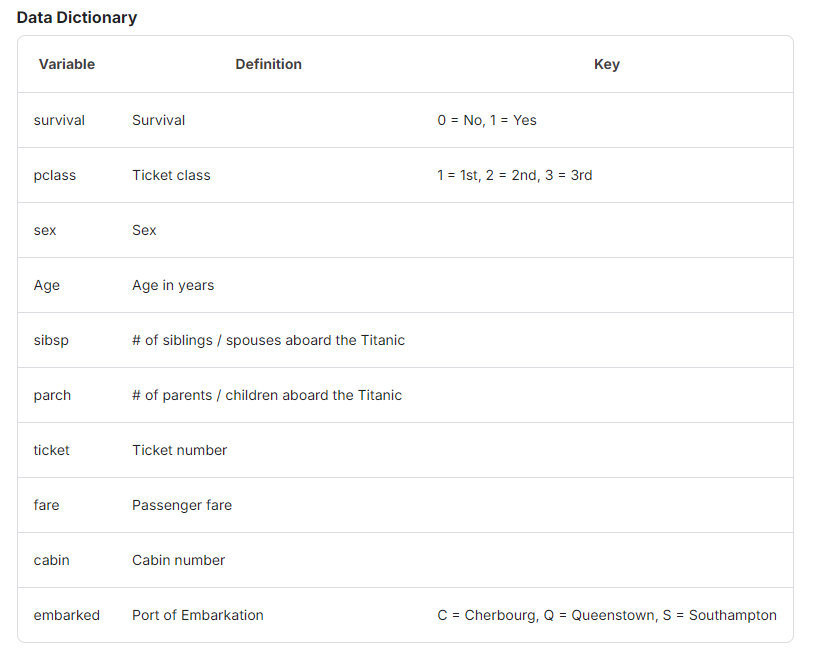

In [4]:
len(train_df)

891

In [5]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
# cabin has 687 nulls, i dont think we can learn anything using it though

In [8]:
# lets check balance now
train_df["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [9]:
class_percentages = train_df["Survived"].value_counts(normalize=True) * 100

print(class_percentages)

threshold = 70  # Adjust this as needed
is_balanced = all(class_percentages < threshold)

if is_balanced:
    print("The dataset is balanced.")
else:
    print("The dataset is imbalanced.")

Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64
The dataset is balanced.


In [10]:
# so model can easily get 61% accuracy if it always predics 0
# so this will be our basepoint

In [11]:
# check outliers
# Identify outliers for each column
for column in train_df.select_dtypes(include=[np.number]):  # Only numerical columns
    Q1 = train_df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = train_df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Column: {column}")
    print(f"Outliers: {len(train_df[(train_df[column] < lower_bound) | (train_df[column] > upper_bound)][column].tolist())}")

Column: Survived
Outliers: 0


Column: Pclass


Outliers: 0


Column: Age


Outliers: 11


Column: SibSp
Outliers: 46


Column: Parch
Outliers: 213


Column: Fare
Outliers: 116


## Create Dataset Class

/usr/local/lib/python3.10/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


/usr/local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)


/usr/local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)


/usr/local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)


/usr/local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)


/usr/local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)


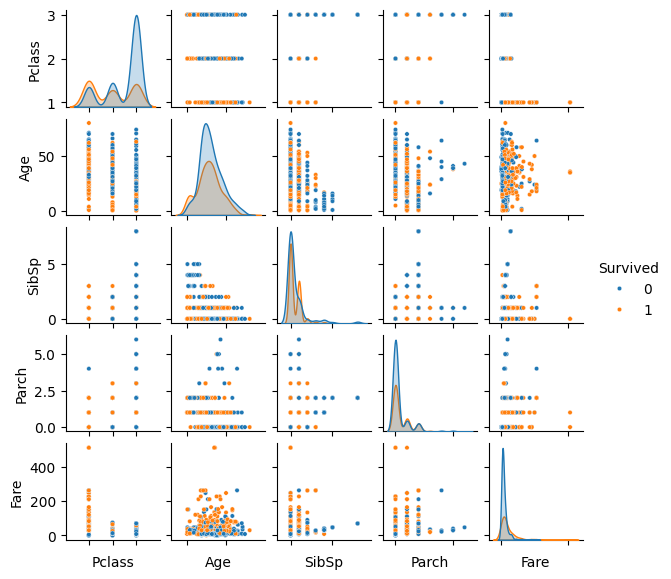

In [12]:
g = sns.pairplot(data=train_df, hue='Survived',
                 size=1.2, diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

<Axes: xlabel='Sex', ylabel='count'>

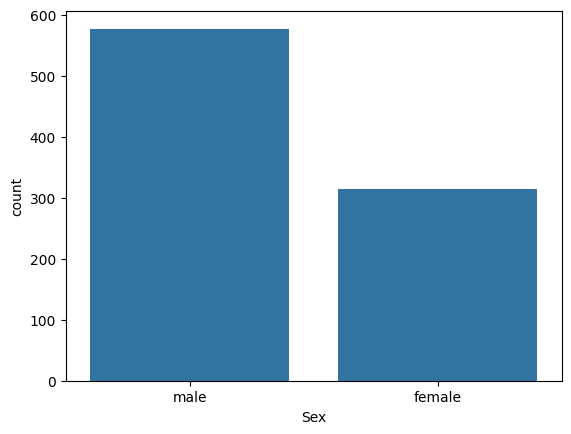

In [13]:
sns.countplot(x='Sex', data=train_df)

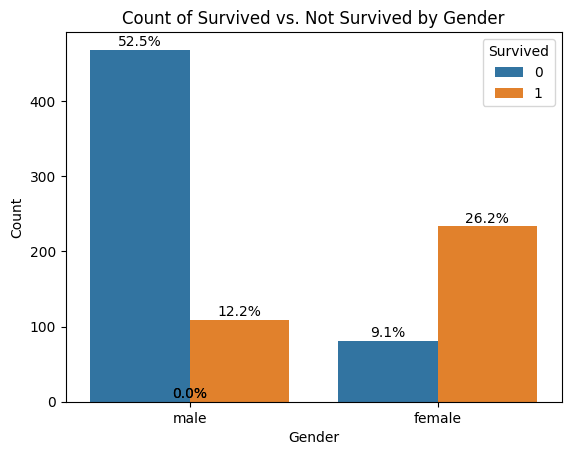

In [14]:
sns.countplot(x='Sex', hue='Survived', data=train_df)

total = len(train_df)

# Add percentage annotations

for p in plt.gca().patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get position of each bar
    percentage = height / total * 100
    plt.text(x + width / 2, y + height + 5, f'{percentage:.1f}%', ha='center')

plt.title('Count of Survived vs. Not Survived by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='Embarked', ylabel='count'>

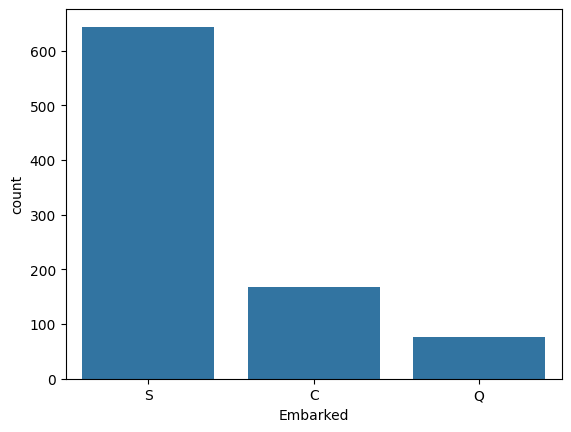

In [15]:
sns.countplot(x='Embarked', data=train_df)

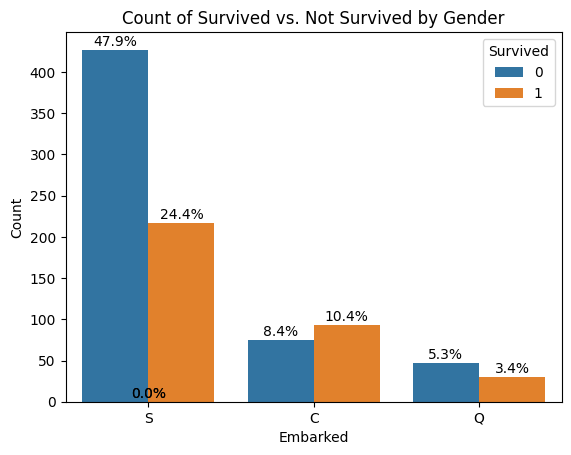

In [16]:
sns.countplot(x='Embarked', hue='Survived', data=train_df)

total = len(train_df)

# Add percentage annotations

for p in plt.gca().patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get position of each bar
    percentage = height / total * 100
    plt.text(x + width / 2, y + height + 5, f'{percentage:.1f}%', ha='center')

plt.title('Count of Survived vs. Not Survived by Gender')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='Pclass', ylabel='count'>

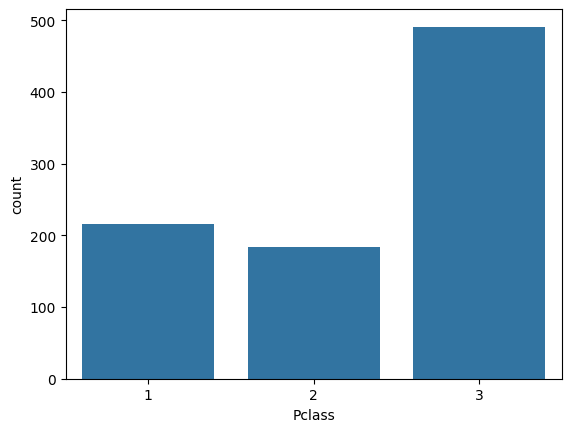

In [17]:
sns.countplot(x='Pclass', data=train_df)

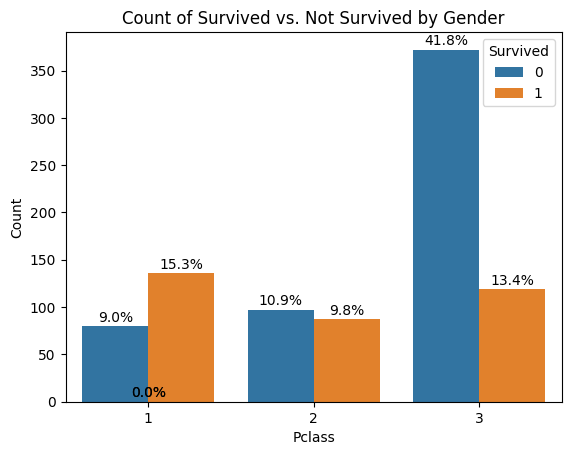

In [18]:
sns.countplot(x='Pclass', hue='Survived', data=train_df)

total = len(train_df)

# Add percentage annotations

for p in plt.gca().patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get position of each bar
    percentage = height / total * 100
    plt.text(x + width / 2, y + height + 5, f'{percentage:.1f}%', ha='center')

plt.title('Count of Survived vs. Not Survived by Gender')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='Age', ylabel='Count'>

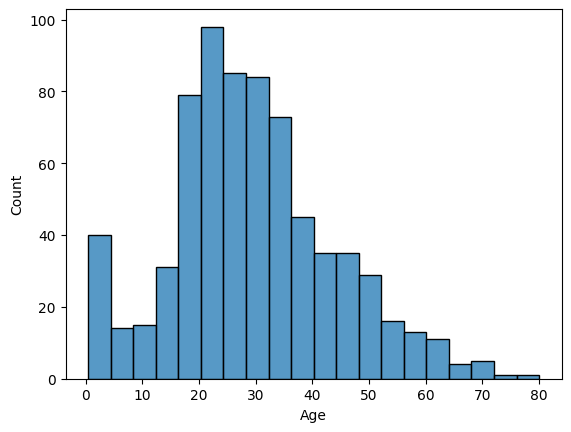

In [19]:
sns.histplot(x='Age', data=train_df)

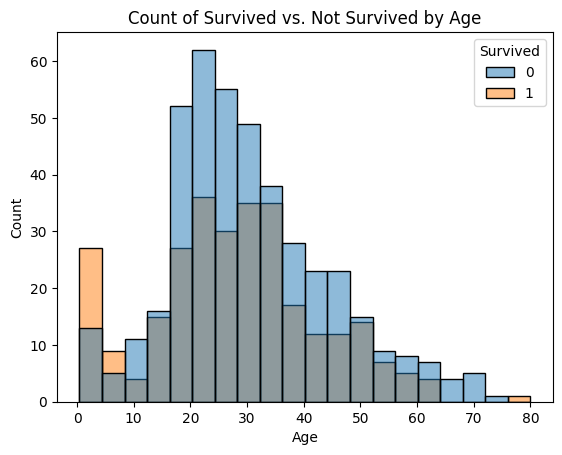

In [20]:
sns.histplot(x='Age', hue='Survived', data=train_df)
plt.title('Count of Survived vs. Not Survived by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='SibSp', ylabel='Count'>

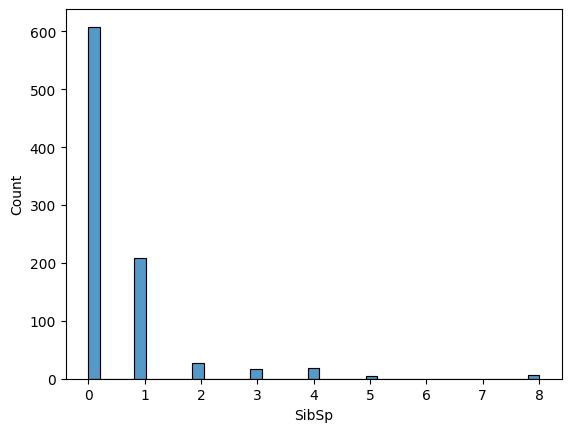

In [21]:
sns.histplot(x='SibSp', data=train_df)

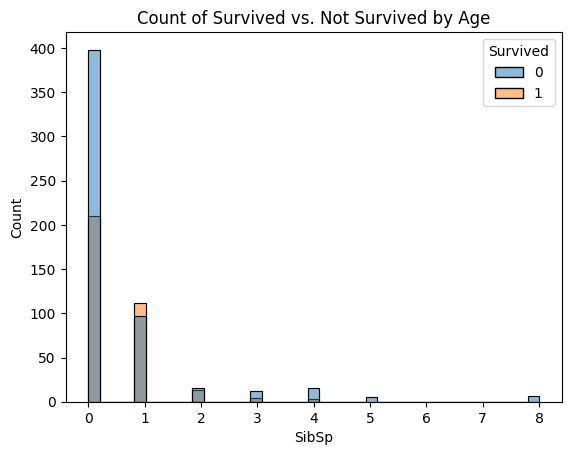

In [22]:
sns.histplot(x='SibSp', hue='Survived', data=train_df)
plt.title('Count of Survived vs. Not Survived by Age')
plt.xlabel('SibSp')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='Parch', ylabel='Count'>

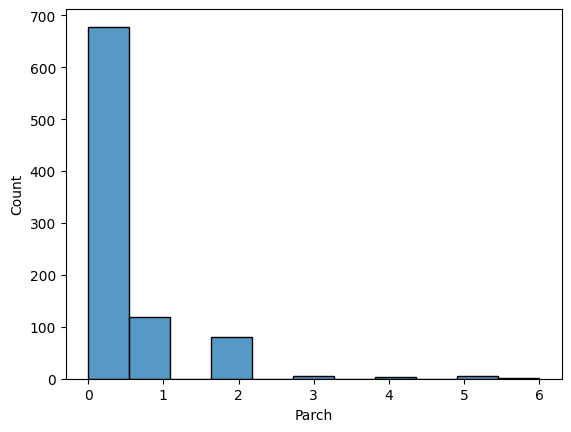

In [23]:
sns.histplot(x='Parch', data=train_df)

<Axes: xlabel='Parch', ylabel='Count'>

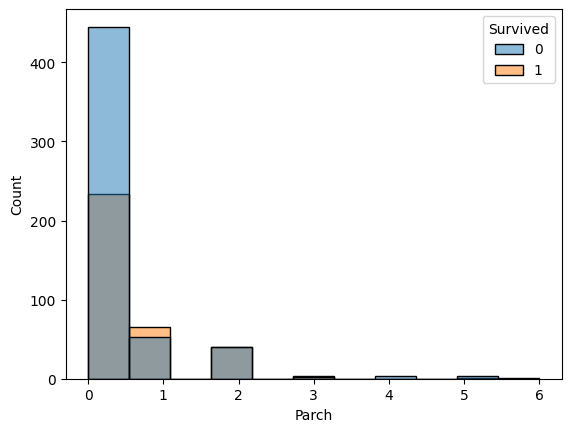

In [24]:
sns.histplot(x='Parch', hue="Survived", data=train_df)

<Axes: xlabel='Fare', ylabel='Count'>

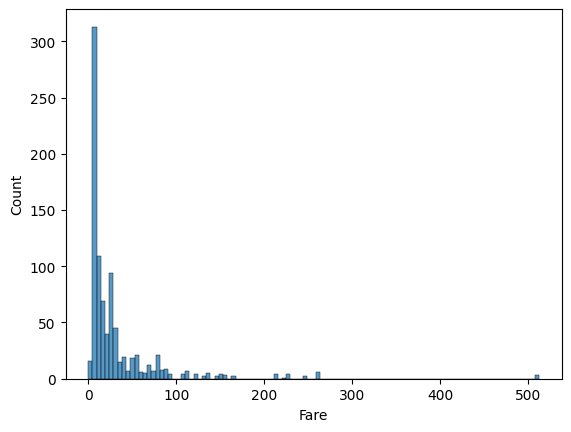

In [25]:
sns.histplot(x='Fare', data=train_df)

<Axes: xlabel='Fare', ylabel='Count'>

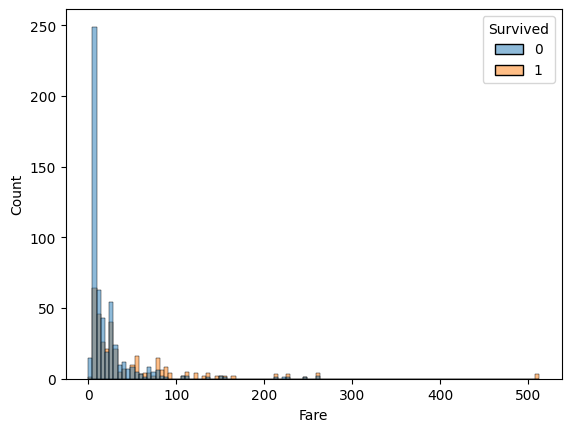

In [26]:
sns.histplot(x='Fare', hue="Survived", data=train_df)

In [27]:
train_df["Family_Name"] = train_df['Name'].str.split(',', expand=True)[0]

<Axes: xlabel='Family_Name', ylabel='Count'>

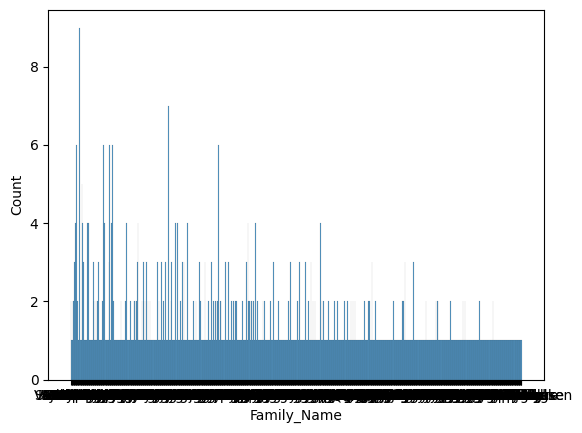

In [28]:
sns.histplot(x='Family_Name', data=train_df)

In [29]:
train_df['Name_Title'] = train_df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

#cleanup rare title names
#print(data1['Title'].value_counts())
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = (train_df['Name_Title'].value_counts() < stat_min) #this will create a true false series with title name as index

#apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
train_df['Name_Title'] = train_df['Name_Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

<Axes: xlabel='Name_Title', ylabel='Count'>

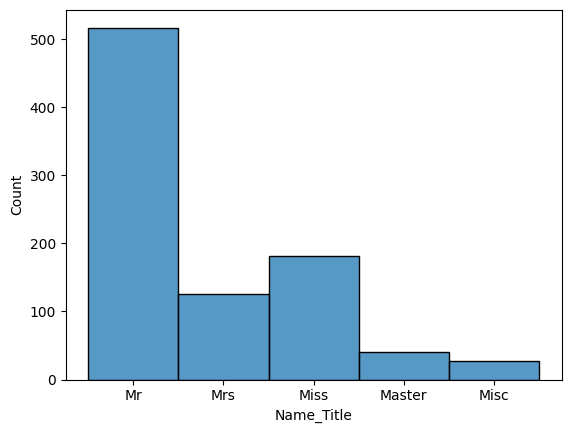

In [30]:
sns.histplot(x='Name_Title', data=train_df)

<Axes: xlabel='Name_Title', ylabel='Count'>

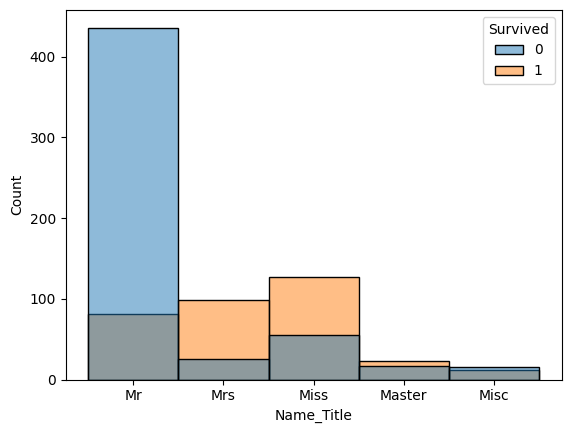

In [31]:
sns.histplot(x='Name_Title', hue="Survived", data=train_df)

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn 
from torch.utils.data import random_split
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [33]:
torch.manual_seed(42); # seed rng for reproducibility

In [34]:
class CSVDataset(Dataset):
    def __init__(self, csv_path, features_col_list, target_col_list, transform=None, entire_data_transform=None, isTest=False):
        # data loading
        self.target_col_list = []
        self.data = pd.read_csv(csv_path, index_col=0)
        
        if (isTest):
            self.data[target_col_list[0]] = 1
        
        self.transform = transform

        self.data = entire_data_transform(self.data)

        self.features_col_list = []
        for col_name in self.data.columns:
            for feature_name in features_col_list:
                if feature_name in col_name:
                    # col is one hot encoded
                    self.features_col_list.append(col_name)

            for feature_name in target_col_list:
                if feature_name in col_name:
                    # col is one hot encoded
                    self.target_col_list.append(col_name)


    def __getitem__(self, index):
        x = self.data.iloc[index][self.features_col_list]  # Features}
        y = self.data.iloc[index][self.target_col_list]  # Target

        # Apply transformations if specified
        if self.transform:
            x, y = self.transform((x,y))

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        # allow us to use len(dataset)
        return len(self.data)

In [35]:
class PreprocessCols():
    def __init__(self, col_funcs):
        self.col_funcs = col_funcs

    def __call__(self, dataset):
        for col_func in self.col_funcs:
            if (col_func["col"]=="."):
                col_func["func"](dataset)
                continue

            if ("new_col_name" in col_func.keys()):
                dataset[col_func["new_col_name"]] = dataset[col_func["col"]].apply(col_func["func"])
            else:
                dataset[col_func["col"]] = dataset[col_func["col"]].apply(col_func["func"])
                
        return dataset

class OneHotEncode():
    def __init__(self, cat_cols):
        self.encoder = ColumnTransformer(
            transformers=[
                ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)
            ],
            remainder='passthrough'
        )
        self.isFit = False
    
    def __call__(self, dataset):        
        if (self.isFit==False):
            self.isFit = True
            self.encoder.fit(dataset)
            
        encoded_dataset = self.encoder.transform(dataset)
        return pd.DataFrame(encoded_dataset, columns=self.encoder.get_feature_names_out())
        
class FillNa():
    def __init__(self, col_na_fill_rule):
        self.col_na_fill_rule = col_na_fill_rule

    def __call__(self, dataset):
        for col, na_fill in self.col_na_fill_rule.items():
            dataset[col].fillna(na_fill, inplace=True)

        return dataset

class NormalizeCol():
    def __init__(self, cols_min_max_val):
        self.cols_min_max_val = cols_min_max_val
    
    def __call__(self, sample):
        inputs, targets = sample

        for col in self.cols_min_max_val:
            inputs[col] = (inputs[col] - self.cols_min_max_val[col]["minVal"]) / (self.cols_min_max_val[col]["maxVal"] - self.cols_min_max_val[col]["minVal"])
        
        return (inputs, targets)

class ConvertNumpyArrToFloat32Tensor():
    def __call__(self, sample):
        inputs, targets = sample
        inputs = (inputs.values).astype(np.float32)
        targets = (targets.values).astype(np.float32)
        return (inputs, targets)

In [36]:
csv_file = "/kaggle/input/titanic/train.csv"
features_col_list = ["Embarked", "Sex", "Pclass", "Age", "SibSp", "Parch", "Fare", "Name_Title"]
target_col_list = ["Survived"]

cat_cols = ["Embarked", "Sex", "Pclass", "Name_Title"]
fill_na = {"Embarked": "S", "Age": train_df["Age"].median()} 
normalize_cols = {"remainder__Age": {"minVal": 0, "maxVal": 150}, "remainder__SibSp": {"minVal": 0, "maxVal": 50}, "remainder__Parch": {"minVal": 0, "maxVal": 50}, "remainder__Fare": {"minVal": 0, "maxVal": 600}}    

def createNameTitle(dataset):
    dataset['Name_Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

    #cleanup rare title names
    #print(data1['Title'].value_counts())
    stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
    title_names = (dataset['Name_Title'].value_counts() < stat_min) #this will create a true false series with title name as index
    
    #apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
    dataset['Name_Title'] = dataset['Name_Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

    return dataset
    
preprocess_col = [{"col": ".", "func": createNameTitle, "new_col_name": "."}]

transforms = torchvision.transforms.Compose([NormalizeCol(normalize_cols),
                                             ConvertNumpyArrToFloat32Tensor()])
one_hot_encode_transform = OneHotEncode(cat_cols)
entire_data_transform = torchvision.transforms.Compose([FillNa(fill_na), PreprocessCols(preprocess_col), one_hot_encode_transform])

dataset = CSVDataset(csv_file, features_col_list, target_col_list, transform=transforms, entire_data_transform=entire_data_transform)
dataset[0]

/tmp/ipykernel_74/2348786235.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[col].fillna(na_fill, inplace=True)


(tensor([0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.1467, 0.0200, 0.0000, 0.0121]),
 tensor([0.]))

In [37]:
len(dataset)

891

In [38]:
# Define split ratios
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for testing

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [39]:
# Define batch size
# since we have less data
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [41]:
debug = True

input_dim = len(next(iter(train_loader))[0][0])
hidden_neuron = 256
output_dim = len(next(iter(train_loader))[1][0])

class LinearLayer(nn.Linear):
    def __init__(self, *args, **kwargs):
        # Call the parent constructor to initialize the Linear layer
        super().__init__(*args, **kwargs)
        
    def forward(self, x):
        self.output = super().forward(x)
        return self.output

class LeakyReluLayer(nn.LeakyReLU):
    def __init__(self, *args, **kwargs):
        # Call the parent constructor to initialize the Linear layer
        super().__init__(*args, **kwargs)
        
    def forward(self, x):
        self.output = super().forward(x)
        return self.output

class BatchNorm1dLayer(nn.BatchNorm1d):
    def __init__(self, *args, **kwargs):
        # Call the parent constructor to initialize the Linear layer
        super().__init__(*args, **kwargs)
        
    def forward(self, x):
        self.output = super().forward(x)
        return self.output

class DropoutLayer(nn.Dropout):
    def __init__(self, *args, **kwargs):
        # Call the parent constructor to initialize the Linear layer
        super().__init__(*args, **kwargs)
        
    def forward(self, x):
        self.output = super().forward(x)
        return self.output

class TitanicSurvivalPredictor(nn.Module):
    def __init__(self, hidden_neuron):
        super().__init__()

        # define layers
        self.layers = nn.ModuleList([
            LinearLayer(input_dim, 1024),
            BatchNorm1dLayer(1024),
            LeakyReluLayer(),
            DropoutLayer(0.3),
            
            LinearLayer(1024, 512),
            BatchNorm1dLayer(512),
            LeakyReluLayer(),
            DropoutLayer(0.3),
            
            LinearLayer(512, 256),
            BatchNorm1dLayer(256),
            LeakyReluLayer(),
            DropoutLayer(0.3),
            
            LinearLayer(256, 128),
            BatchNorm1dLayer(128),
            LeakyReluLayer(),
            DropoutLayer(0.3),
            
            LinearLayer(128, 64),
            BatchNorm1dLayer(64),
            LeakyReluLayer(),
            DropoutLayer(0.3),

            LinearLayer(64, 32),
            BatchNorm1dLayer(32),
            LeakyReluLayer(),
            DropoutLayer(0.3),

            LinearLayer(32, 16),
            BatchNorm1dLayer(16),
            LeakyReluLayer(),
            DropoutLayer(0.3),

            LinearLayer(16, 8),
            BatchNorm1dLayer(8),
            LeakyReluLayer(),
            DropoutLayer(0.3),
                        
            LinearLayer(8, output_dim),
        ])
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

model = TitanicSurvivalPredictor(hidden_neuron)

In [42]:
activation_layers = ["LeakyReluLayer"]

In [43]:
@torch.no_grad()
def initParam(model):
    # Initialize weights using Xavier Normal
    for i, layer in enumerate(model.layers):
        if (isinstance(layer, LinearLayer)):
            if (i<len(model.layers)-1):
                nn.init.xavier_normal_(model.layers[i].weight, gain=torch.nn.init.calculate_gain("leaky_relu"))
            else:
                nn.init.xavier_normal_(model.layers[i].weight, gain=torch.nn.init.calculate_gain("sigmoid"))
            if layer.bias is not None:
                nn.init.zeros_(model.layers[i].bias)

initParam(model)

In [44]:
init_loss = 0
model = model.to(device)
bce_loss = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        pred = model(inputs)        
        loss = bce_loss(pred, labels)

        init_loss += loss.item()

init_loss /= len(train_loader)
print(f"init loss: {init_loss}")

init loss: 0.9235692076061083


In [45]:
# less lr rate since can overfit easily
learning_rate = 1e-3
# less epoch as can easily overfit
num_epoch = 10000

lossi_train = []
lossi_val = []
metric_val = []
ud = [] # update to data ration

total_samples = len(train_dataset)
n_iter = math.ceil(total_samples / batch_size)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
bce_loss = nn.BCEWithLogitsLoss()
output_grads = []

model = model.to(device)

runFirstBatch = False
for epoch in range(num_epoch):
    # reset to train mode
    model.train()
    
    train_loss = 0    
    for i, (inputs, labels) in enumerate(train_loader):
        # reset grad
        optimizer.zero_grad()
        
        # forward pass
        # print(f"inputs: {inputs}")
        # print(f"labels: {labels}")
        inputs = inputs.to(device)
        labels = labels.to(device)

        # print(f"inputs device: {inputs.device}, labels device: {labels.device}, model device: {[param.device for param in model.parameters()]}")
        
        pred = model(inputs)
        # print(f"pred: {pred}")

        # calc loss
        loss = bce_loss(pred, labels)

        if (debug):
            for layer in model.layers:
                layer.output.retain_grad() # save gradients of non leaf tensors also
        
        # backward pass
        loss.backward()
        optimizer.step()
        loss = loss.log10()
        train_loss += loss.item()

    # copied it to array since running with no grad will set grad to None
    if (debug):
        curr_grads = {}
        for i, layer in enumerate(model.layers):
            curr_grads[f"{layer.__class__.__name__}: {i}"] = layer.output.grad.clone()

        output_grads.append(curr_grads)
    
    train_loss /= len(train_loader)
    lossi_train.append(train_loss)

    # validation phase
    model.eval()
    
    # Accuracy calculation
    correct = 0
    total = 0
    accuracy = 0
    val_loss = 0
    
    with torch.no_grad():  # Disable gradient computation for validation
        ud.append([((learning_rate*p.grad.std() / p.data.std()).log10().item() if p.ndim == 2 else 0) for p in model.parameters()])
        
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            pred = model(inputs)
            predictions = torch.sigmoid(pred)  # Apply sigmoid for binary classification
            predicted_classes = (predictions > 0.5).float()  # Convert to binary (0 or 1)
            correct += (predicted_classes == labels).sum().item()
            total += labels.size(0)
            
            loss = bce_loss(pred, labels)
            loss = loss.log10()
            val_loss += loss.item()
        
        accuracy = correct / total
        metric_val.append(accuracy)
        val_loss /= len(val_loader)
        lossi_val.append(val_loss)

    if ((epoch+1)%5==0):
        print(f"Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},  Val Metric: {accuracy:.4f}")

        # if (debug):
        #     break

Epoch 5/10000, Train Loss: -0.1997, Val Loss: -0.3460,  Val Metric: 0.8427


Epoch 10/10000, Train Loss: -0.2480, Val Loss: -0.4033,  Val Metric: 0.8539


Epoch 15/10000, Train Loss: -0.2767, Val Loss: -0.4030,  Val Metric: 0.8652


Epoch 20/10000, Train Loss: -0.3002, Val Loss: -0.4085,  Val Metric: 0.8652


Epoch 25/10000, Train Loss: -0.3206, Val Loss: -0.4313,  Val Metric: 0.8652


Epoch 30/10000, Train Loss: -0.3349, Val Loss: -0.4253,  Val Metric: 0.8764


Epoch 35/10000, Train Loss: -0.3370, Val Loss: -0.4440,  Val Metric: 0.8764


Epoch 40/10000, Train Loss: -0.3393, Val Loss: -0.4431,  Val Metric: 0.8652


Epoch 45/10000, Train Loss: -0.3350, Val Loss: -0.4493,  Val Metric: 0.8764


Epoch 50/10000, Train Loss: -0.3586, Val Loss: -0.4412,  Val Metric: 0.8652


Epoch 55/10000, Train Loss: -0.3716, Val Loss: -0.4680,  Val Metric: 0.8764


Epoch 60/10000, Train Loss: -0.3679, Val Loss: -0.4356,  Val Metric: 0.8764


Epoch 65/10000, Train Loss: -0.3862, Val Loss: -0.4432,  Val Metric: 0.8764


Epoch 70/10000, Train Loss: -0.3994, Val Loss: -0.4516,  Val Metric: 0.8764


Epoch 75/10000, Train Loss: -0.4008, Val Loss: -0.4482,  Val Metric: 0.8652


Epoch 80/10000, Train Loss: -0.3888, Val Loss: -0.4635,  Val Metric: 0.8764


Epoch 85/10000, Train Loss: -0.4038, Val Loss: -0.4627,  Val Metric: 0.8652


Epoch 90/10000, Train Loss: -0.3887, Val Loss: -0.4499,  Val Metric: 0.8652


Epoch 95/10000, Train Loss: -0.4030, Val Loss: -0.4582,  Val Metric: 0.8764


Epoch 100/10000, Train Loss: -0.4035, Val Loss: -0.4725,  Val Metric: 0.8764


Epoch 105/10000, Train Loss: -0.4001, Val Loss: -0.4829,  Val Metric: 0.8876


Epoch 110/10000, Train Loss: -0.4236, Val Loss: -0.4666,  Val Metric: 0.8876


Epoch 115/10000, Train Loss: -0.4485, Val Loss: -0.4816,  Val Metric: 0.8764


Epoch 120/10000, Train Loss: -0.4372, Val Loss: -0.4676,  Val Metric: 0.8876


Epoch 125/10000, Train Loss: -0.4497, Val Loss: -0.4794,  Val Metric: 0.8764


Epoch 130/10000, Train Loss: -0.4568, Val Loss: -0.4336,  Val Metric: 0.8652


Epoch 135/10000, Train Loss: -0.4604, Val Loss: -0.4826,  Val Metric: 0.8876


Epoch 140/10000, Train Loss: -0.4281, Val Loss: -0.4480,  Val Metric: 0.8876


Epoch 145/10000, Train Loss: -0.4898, Val Loss: -0.4783,  Val Metric: 0.8764


Epoch 150/10000, Train Loss: -0.4577, Val Loss: -0.4908,  Val Metric: 0.8876


Epoch 155/10000, Train Loss: -0.4747, Val Loss: -0.4844,  Val Metric: 0.8876


Epoch 160/10000, Train Loss: -0.4970, Val Loss: -0.4512,  Val Metric: 0.8764


Epoch 165/10000, Train Loss: -0.4732, Val Loss: -0.4538,  Val Metric: 0.8764


Epoch 170/10000, Train Loss: -0.4903, Val Loss: -0.4610,  Val Metric: 0.8876


Epoch 175/10000, Train Loss: -0.5315, Val Loss: -0.4750,  Val Metric: 0.8876


Epoch 180/10000, Train Loss: -0.5096, Val Loss: -0.4700,  Val Metric: 0.8989


Epoch 185/10000, Train Loss: -0.4712, Val Loss: -0.4726,  Val Metric: 0.8764


Epoch 190/10000, Train Loss: -0.4783, Val Loss: -0.4801,  Val Metric: 0.9101


Epoch 195/10000, Train Loss: -0.5422, Val Loss: -0.4520,  Val Metric: 0.8876


Epoch 200/10000, Train Loss: -0.5152, Val Loss: -0.4736,  Val Metric: 0.8989


Epoch 205/10000, Train Loss: -0.5425, Val Loss: -0.4694,  Val Metric: 0.8876


Epoch 210/10000, Train Loss: -0.5437, Val Loss: -0.4470,  Val Metric: 0.8876


Epoch 215/10000, Train Loss: -0.5329, Val Loss: -0.4843,  Val Metric: 0.8989


Epoch 220/10000, Train Loss: -0.5468, Val Loss: -0.4335,  Val Metric: 0.8764


Epoch 225/10000, Train Loss: -0.5966, Val Loss: -0.4745,  Val Metric: 0.8876


Epoch 230/10000, Train Loss: -0.5320, Val Loss: -0.4268,  Val Metric: 0.8539


Epoch 235/10000, Train Loss: -0.5489, Val Loss: -0.4226,  Val Metric: 0.8427


Epoch 240/10000, Train Loss: -0.5245, Val Loss: -0.4872,  Val Metric: 0.8876


Epoch 245/10000, Train Loss: -0.5397, Val Loss: -0.4580,  Val Metric: 0.8764


Epoch 250/10000, Train Loss: -0.5653, Val Loss: -0.4611,  Val Metric: 0.8989


Epoch 255/10000, Train Loss: -0.5873, Val Loss: -0.4539,  Val Metric: 0.8876


Epoch 260/10000, Train Loss: -0.6112, Val Loss: -0.4831,  Val Metric: 0.8764


Epoch 265/10000, Train Loss: -0.6340, Val Loss: -0.4793,  Val Metric: 0.8876


Epoch 270/10000, Train Loss: -0.6074, Val Loss: -0.4470,  Val Metric: 0.8876


Epoch 275/10000, Train Loss: -0.6589, Val Loss: -0.4672,  Val Metric: 0.8764


Epoch 280/10000, Train Loss: -0.6273, Val Loss: -0.4360,  Val Metric: 0.8764


Epoch 285/10000, Train Loss: -0.6194, Val Loss: -0.4482,  Val Metric: 0.8764


Epoch 290/10000, Train Loss: -0.6200, Val Loss: -0.4718,  Val Metric: 0.8652


Epoch 295/10000, Train Loss: -0.5863, Val Loss: -0.4599,  Val Metric: 0.8876


Epoch 300/10000, Train Loss: -0.6068, Val Loss: -0.4367,  Val Metric: 0.8652


Epoch 305/10000, Train Loss: -0.6767, Val Loss: -0.3987,  Val Metric: 0.8876


Epoch 310/10000, Train Loss: -0.6990, Val Loss: -0.4244,  Val Metric: 0.8652


Epoch 315/10000, Train Loss: -0.6950, Val Loss: -0.4196,  Val Metric: 0.8764


Epoch 320/10000, Train Loss: -0.7186, Val Loss: -0.4346,  Val Metric: 0.8876


Epoch 325/10000, Train Loss: -0.6852, Val Loss: -0.4334,  Val Metric: 0.8764


Epoch 330/10000, Train Loss: -0.6785, Val Loss: -0.4527,  Val Metric: 0.8989


Epoch 335/10000, Train Loss: -0.6867, Val Loss: -0.4259,  Val Metric: 0.8876


Epoch 340/10000, Train Loss: -0.6998, Val Loss: -0.3253,  Val Metric: 0.8427


Epoch 345/10000, Train Loss: -0.7207, Val Loss: -0.3901,  Val Metric: 0.8652


Epoch 350/10000, Train Loss: -0.6911, Val Loss: -0.3958,  Val Metric: 0.8652


Epoch 355/10000, Train Loss: -0.7764, Val Loss: -0.3937,  Val Metric: 0.8652


Epoch 360/10000, Train Loss: -0.6965, Val Loss: -0.4303,  Val Metric: 0.8876


Epoch 365/10000, Train Loss: -0.7626, Val Loss: -0.4203,  Val Metric: 0.8876


Epoch 370/10000, Train Loss: -0.7397, Val Loss: -0.3828,  Val Metric: 0.8652


Epoch 375/10000, Train Loss: -0.6931, Val Loss: -0.3320,  Val Metric: 0.8427


Epoch 380/10000, Train Loss: -0.7460, Val Loss: -0.3865,  Val Metric: 0.8427


Epoch 385/10000, Train Loss: -0.7536, Val Loss: -0.3805,  Val Metric: 0.8427


Epoch 390/10000, Train Loss: -0.7941, Val Loss: -0.3783,  Val Metric: 0.8652


Epoch 395/10000, Train Loss: -0.7971, Val Loss: -0.3986,  Val Metric: 0.8989


Epoch 400/10000, Train Loss: -0.7908, Val Loss: -0.4076,  Val Metric: 0.8876


Epoch 405/10000, Train Loss: -0.7849, Val Loss: -0.3832,  Val Metric: 0.8876


Epoch 410/10000, Train Loss: -0.7918, Val Loss: -0.4061,  Val Metric: 0.8652


Epoch 415/10000, Train Loss: -0.8491, Val Loss: -0.3766,  Val Metric: 0.8652


Epoch 420/10000, Train Loss: -0.8844, Val Loss: -0.3515,  Val Metric: 0.8652


Epoch 425/10000, Train Loss: -0.8178, Val Loss: -0.3510,  Val Metric: 0.8315


Epoch 430/10000, Train Loss: -0.8329, Val Loss: -0.3558,  Val Metric: 0.8315


Epoch 435/10000, Train Loss: -0.8335, Val Loss: -0.4287,  Val Metric: 0.8764


Epoch 440/10000, Train Loss: -0.7644, Val Loss: -0.3195,  Val Metric: 0.8427


Epoch 445/10000, Train Loss: -0.8446, Val Loss: -0.3702,  Val Metric: 0.8652


Epoch 450/10000, Train Loss: -0.8366, Val Loss: -0.3402,  Val Metric: 0.8427


Epoch 455/10000, Train Loss: -0.8026, Val Loss: -0.2704,  Val Metric: 0.8427


Epoch 460/10000, Train Loss: -0.8103, Val Loss: -0.3509,  Val Metric: 0.8427


Epoch 465/10000, Train Loss: -0.9094, Val Loss: -0.3058,  Val Metric: 0.8427


Epoch 470/10000, Train Loss: -0.8938, Val Loss: -0.3107,  Val Metric: 0.8539


Epoch 475/10000, Train Loss: -0.8202, Val Loss: -0.3619,  Val Metric: 0.8539


Epoch 480/10000, Train Loss: -0.8611, Val Loss: -0.2852,  Val Metric: 0.8539


Epoch 485/10000, Train Loss: -0.9821, Val Loss: -0.2672,  Val Metric: 0.8427


Epoch 490/10000, Train Loss: -0.9326, Val Loss: -0.2571,  Val Metric: 0.8427


Epoch 495/10000, Train Loss: -0.7826, Val Loss: -0.3314,  Val Metric: 0.8427


Epoch 500/10000, Train Loss: -0.8869, Val Loss: -0.2740,  Val Metric: 0.8427


Epoch 505/10000, Train Loss: -0.8696, Val Loss: -0.3080,  Val Metric: 0.8315


Epoch 510/10000, Train Loss: -0.9618, Val Loss: -0.2897,  Val Metric: 0.8539


Epoch 515/10000, Train Loss: -0.8938, Val Loss: -0.2653,  Val Metric: 0.8427


Epoch 520/10000, Train Loss: -0.9705, Val Loss: -0.2631,  Val Metric: 0.8539


Epoch 525/10000, Train Loss: -0.8707, Val Loss: -0.2192,  Val Metric: 0.8315


Epoch 530/10000, Train Loss: -0.9501, Val Loss: -0.2220,  Val Metric: 0.8427


Epoch 535/10000, Train Loss: -0.9203, Val Loss: -0.2490,  Val Metric: 0.8539


Epoch 540/10000, Train Loss: -0.9638, Val Loss: -0.2443,  Val Metric: 0.8315


Epoch 545/10000, Train Loss: -1.0038, Val Loss: -0.3215,  Val Metric: 0.8652


Epoch 550/10000, Train Loss: -0.9419, Val Loss: -0.3537,  Val Metric: 0.8539


Epoch 555/10000, Train Loss: -0.9146, Val Loss: -0.2707,  Val Metric: 0.8427


Epoch 560/10000, Train Loss: -1.0702, Val Loss: -0.2610,  Val Metric: 0.8427


Epoch 565/10000, Train Loss: -0.9092, Val Loss: -0.2724,  Val Metric: 0.8202


Epoch 570/10000, Train Loss: -0.9605, Val Loss: -0.2185,  Val Metric: 0.8315


Epoch 575/10000, Train Loss: -0.9069, Val Loss: -0.2241,  Val Metric: 0.8202


Epoch 580/10000, Train Loss: -1.0279, Val Loss: -0.2152,  Val Metric: 0.8315


Epoch 585/10000, Train Loss: -0.9458, Val Loss: -0.1861,  Val Metric: 0.8539


Epoch 590/10000, Train Loss: -0.9569, Val Loss: -0.2247,  Val Metric: 0.8427


Epoch 595/10000, Train Loss: -0.8341, Val Loss: -0.1854,  Val Metric: 0.8427


Epoch 600/10000, Train Loss: -1.0116, Val Loss: -0.2779,  Val Metric: 0.8652


Epoch 605/10000, Train Loss: -1.0693, Val Loss: -0.2410,  Val Metric: 0.8315


Epoch 610/10000, Train Loss: -0.9812, Val Loss: -0.2339,  Val Metric: 0.8427


Epoch 615/10000, Train Loss: -0.9673, Val Loss: -0.3187,  Val Metric: 0.8315


Epoch 620/10000, Train Loss: -1.0323, Val Loss: -0.2934,  Val Metric: 0.8652


Epoch 625/10000, Train Loss: -1.0694, Val Loss: -0.2690,  Val Metric: 0.8539


Epoch 630/10000, Train Loss: -1.0447, Val Loss: -0.1536,  Val Metric: 0.8427


Epoch 635/10000, Train Loss: -0.9577, Val Loss: -0.1894,  Val Metric: 0.8315


Epoch 640/10000, Train Loss: -1.0847, Val Loss: -0.1948,  Val Metric: 0.8315


Epoch 645/10000, Train Loss: -1.0997, Val Loss: -0.2507,  Val Metric: 0.8315


Epoch 650/10000, Train Loss: -0.9351, Val Loss: -0.1643,  Val Metric: 0.8202


Epoch 655/10000, Train Loss: -1.0790, Val Loss: -0.2232,  Val Metric: 0.8427


Epoch 660/10000, Train Loss: -1.0166, Val Loss: -0.2213,  Val Metric: 0.8427


Epoch 665/10000, Train Loss: -0.9016, Val Loss: -0.2704,  Val Metric: 0.8202


Epoch 670/10000, Train Loss: -1.0134, Val Loss: -0.1865,  Val Metric: 0.8652


Epoch 675/10000, Train Loss: -1.0307, Val Loss: -0.3549,  Val Metric: 0.8652


Epoch 680/10000, Train Loss: -1.0283, Val Loss: -0.2442,  Val Metric: 0.8539


Epoch 685/10000, Train Loss: -1.0363, Val Loss: -0.2508,  Val Metric: 0.8764


Epoch 690/10000, Train Loss: -1.0541, Val Loss: -0.1772,  Val Metric: 0.8427


Epoch 695/10000, Train Loss: -1.0118, Val Loss: -0.2942,  Val Metric: 0.8315


Epoch 700/10000, Train Loss: -1.0897, Val Loss: -0.2829,  Val Metric: 0.8539


Epoch 705/10000, Train Loss: -1.1011, Val Loss: -0.2133,  Val Metric: 0.8090


Epoch 710/10000, Train Loss: -1.0485, Val Loss: -0.2739,  Val Metric: 0.8427


Epoch 715/10000, Train Loss: -1.1396, Val Loss: -0.1902,  Val Metric: 0.8427


Epoch 720/10000, Train Loss: -1.0547, Val Loss: -0.1785,  Val Metric: 0.7865


Epoch 725/10000, Train Loss: -1.0040, Val Loss: -0.2463,  Val Metric: 0.8539


Epoch 730/10000, Train Loss: -1.0273, Val Loss: -0.2317,  Val Metric: 0.8315


Epoch 735/10000, Train Loss: -1.0475, Val Loss: -0.1912,  Val Metric: 0.8315


Epoch 740/10000, Train Loss: -1.1043, Val Loss: -0.3000,  Val Metric: 0.8539


Epoch 745/10000, Train Loss: -1.0808, Val Loss: -0.2422,  Val Metric: 0.8652


Epoch 750/10000, Train Loss: -1.1295, Val Loss: -0.1681,  Val Metric: 0.8539


Epoch 755/10000, Train Loss: -1.1788, Val Loss: -0.1789,  Val Metric: 0.8202


Epoch 760/10000, Train Loss: -1.0876, Val Loss: -0.2491,  Val Metric: 0.8315


Epoch 765/10000, Train Loss: -1.1526, Val Loss: -0.1741,  Val Metric: 0.8427


Epoch 770/10000, Train Loss: -1.1059, Val Loss: -0.1802,  Val Metric: 0.8427


Epoch 775/10000, Train Loss: -0.8836, Val Loss: -0.2396,  Val Metric: 0.8539


Epoch 780/10000, Train Loss: -1.1192, Val Loss: -0.2288,  Val Metric: 0.8315


Epoch 785/10000, Train Loss: -1.2235, Val Loss: -0.0784,  Val Metric: 0.8090


Epoch 790/10000, Train Loss: -1.1197, Val Loss: -0.1694,  Val Metric: 0.8315


Epoch 795/10000, Train Loss: -1.0052, Val Loss: -0.1130,  Val Metric: 0.8202


Epoch 800/10000, Train Loss: -1.1267, Val Loss: -0.2223,  Val Metric: 0.8315


Epoch 805/10000, Train Loss: -1.0795, Val Loss: -0.2435,  Val Metric: 0.8427


Epoch 810/10000, Train Loss: -1.2020, Val Loss: -0.1936,  Val Metric: 0.8315


Epoch 815/10000, Train Loss: -1.1272, Val Loss: -0.2410,  Val Metric: 0.8764


Epoch 820/10000, Train Loss: -1.0637, Val Loss: -0.3418,  Val Metric: 0.8090


Epoch 825/10000, Train Loss: -1.2510, Val Loss: -0.1548,  Val Metric: 0.8315


Epoch 830/10000, Train Loss: -1.0991, Val Loss: -0.1669,  Val Metric: 0.8427


Epoch 835/10000, Train Loss: -0.9651, Val Loss: -0.1664,  Val Metric: 0.8539


Epoch 840/10000, Train Loss: -1.1322, Val Loss: -0.1523,  Val Metric: 0.8202


Epoch 845/10000, Train Loss: -1.1570, Val Loss: -0.2127,  Val Metric: 0.8427


Epoch 850/10000, Train Loss: -1.0260, Val Loss: -0.2045,  Val Metric: 0.8539


Epoch 855/10000, Train Loss: -1.2202, Val Loss: -0.0999,  Val Metric: 0.8315


Epoch 860/10000, Train Loss: -1.2462, Val Loss: -0.1506,  Val Metric: 0.8315


Epoch 865/10000, Train Loss: -1.0103, Val Loss: -0.1754,  Val Metric: 0.8539


Epoch 870/10000, Train Loss: -1.0635, Val Loss: -0.1924,  Val Metric: 0.8315


Epoch 875/10000, Train Loss: -1.0914, Val Loss: -0.2802,  Val Metric: 0.8652


Epoch 880/10000, Train Loss: -1.2105, Val Loss: -0.1711,  Val Metric: 0.8427


Epoch 885/10000, Train Loss: -1.1620, Val Loss: -0.1729,  Val Metric: 0.8315


Epoch 890/10000, Train Loss: -1.1659, Val Loss: -0.2862,  Val Metric: 0.8539


Epoch 895/10000, Train Loss: -1.1768, Val Loss: -0.1751,  Val Metric: 0.8427


Epoch 900/10000, Train Loss: -1.2531, Val Loss: -0.1394,  Val Metric: 0.8202


Epoch 905/10000, Train Loss: -1.2228, Val Loss: -0.1825,  Val Metric: 0.8539


Epoch 910/10000, Train Loss: -1.2475, Val Loss: -0.1824,  Val Metric: 0.8315


Epoch 915/10000, Train Loss: -1.1708, Val Loss: -0.2278,  Val Metric: 0.8652


Epoch 920/10000, Train Loss: -1.1864, Val Loss: -0.1765,  Val Metric: 0.8539


Epoch 925/10000, Train Loss: -1.0607, Val Loss: -0.2016,  Val Metric: 0.8652


Epoch 930/10000, Train Loss: -1.1196, Val Loss: -0.0977,  Val Metric: 0.8315


Epoch 935/10000, Train Loss: -1.0904, Val Loss: -0.2122,  Val Metric: 0.8427


Epoch 940/10000, Train Loss: -1.1508, Val Loss: -0.0980,  Val Metric: 0.8315


Epoch 945/10000, Train Loss: -1.1224, Val Loss: -0.0981,  Val Metric: 0.7978


Epoch 950/10000, Train Loss: -1.2483, Val Loss: -0.1063,  Val Metric: 0.8090


Epoch 955/10000, Train Loss: -1.1456, Val Loss: -0.1391,  Val Metric: 0.8539


Epoch 960/10000, Train Loss: -1.1491, Val Loss: -0.1182,  Val Metric: 0.8315


Epoch 965/10000, Train Loss: -1.1995, Val Loss: -0.1465,  Val Metric: 0.7978


Epoch 970/10000, Train Loss: -1.1717, Val Loss: -0.1016,  Val Metric: 0.8202


Epoch 975/10000, Train Loss: -1.1812, Val Loss: -0.1580,  Val Metric: 0.8764


Epoch 980/10000, Train Loss: -1.2567, Val Loss: -0.1785,  Val Metric: 0.8539


Epoch 985/10000, Train Loss: -1.1891, Val Loss: -0.1769,  Val Metric: 0.8764


Epoch 990/10000, Train Loss: -1.1930, Val Loss: -0.2428,  Val Metric: 0.8876


Epoch 995/10000, Train Loss: -1.1774, Val Loss: -0.1876,  Val Metric: 0.8427


Epoch 1000/10000, Train Loss: -1.2827, Val Loss: -0.0398,  Val Metric: 0.7865


Epoch 1005/10000, Train Loss: -1.1384, Val Loss: -0.1339,  Val Metric: 0.8202


Epoch 1010/10000, Train Loss: -1.1844, Val Loss: -0.0882,  Val Metric: 0.8427


Epoch 1015/10000, Train Loss: -1.2730, Val Loss: -0.1168,  Val Metric: 0.8315


Epoch 1020/10000, Train Loss: -1.3011, Val Loss: -0.0557,  Val Metric: 0.8315


Epoch 1025/10000, Train Loss: -1.2206, Val Loss: -0.1203,  Val Metric: 0.8202


Epoch 1030/10000, Train Loss: -1.2635, Val Loss: -0.0847,  Val Metric: 0.8202


Epoch 1035/10000, Train Loss: -1.1517, Val Loss: -0.0657,  Val Metric: 0.8315


Epoch 1040/10000, Train Loss: -1.1803, Val Loss: -0.1179,  Val Metric: 0.8539


Epoch 1045/10000, Train Loss: -1.0852, Val Loss: -0.0998,  Val Metric: 0.8315


Epoch 1050/10000, Train Loss: -1.1603, Val Loss: -0.0665,  Val Metric: 0.8315


Epoch 1055/10000, Train Loss: -1.3226, Val Loss: -0.0819,  Val Metric: 0.8427


Epoch 1060/10000, Train Loss: -1.2352, Val Loss: -0.2028,  Val Metric: 0.8539


Epoch 1065/10000, Train Loss: -1.0984, Val Loss: -0.1511,  Val Metric: 0.8539


Epoch 1070/10000, Train Loss: -1.2280, Val Loss: -0.1015,  Val Metric: 0.8315


Epoch 1075/10000, Train Loss: -1.2352, Val Loss: -0.1141,  Val Metric: 0.8652


Epoch 1080/10000, Train Loss: -1.2383, Val Loss: -0.1266,  Val Metric: 0.8539


Epoch 1085/10000, Train Loss: -1.1338, Val Loss: -0.1488,  Val Metric: 0.8539


Epoch 1090/10000, Train Loss: -1.1756, Val Loss: -0.1136,  Val Metric: 0.8539


Epoch 1095/10000, Train Loss: -1.2429, Val Loss: -0.1823,  Val Metric: 0.8652


Epoch 1100/10000, Train Loss: -1.2246, Val Loss: -0.1789,  Val Metric: 0.8427


Epoch 1105/10000, Train Loss: -1.2234, Val Loss: -0.1605,  Val Metric: 0.8539


Epoch 1110/10000, Train Loss: -1.1259, Val Loss: -0.1079,  Val Metric: 0.8202


Epoch 1115/10000, Train Loss: -1.3334, Val Loss: -0.1133,  Val Metric: 0.8315


Epoch 1120/10000, Train Loss: -1.1649, Val Loss: -0.1993,  Val Metric: 0.8539


Epoch 1125/10000, Train Loss: -1.2377, Val Loss: -0.0951,  Val Metric: 0.8539


Epoch 1130/10000, Train Loss: -1.3604, Val Loss: -0.1389,  Val Metric: 0.8427


Epoch 1135/10000, Train Loss: -1.2792, Val Loss: -0.0666,  Val Metric: 0.8202


Epoch 1140/10000, Train Loss: -1.1927, Val Loss: -0.0521,  Val Metric: 0.8090


Epoch 1145/10000, Train Loss: -1.1294, Val Loss: -0.1562,  Val Metric: 0.8427


Epoch 1150/10000, Train Loss: -1.3113, Val Loss: -0.1642,  Val Metric: 0.8539


Epoch 1155/10000, Train Loss: -1.1462, Val Loss: -0.1699,  Val Metric: 0.8539


Epoch 1160/10000, Train Loss: -1.2305, Val Loss: -0.1583,  Val Metric: 0.8427


Epoch 1165/10000, Train Loss: -1.2941, Val Loss: -0.1559,  Val Metric: 0.8315


Epoch 1170/10000, Train Loss: -1.2308, Val Loss: -0.1565,  Val Metric: 0.8427


Epoch 1175/10000, Train Loss: -1.2193, Val Loss: -0.2000,  Val Metric: 0.8652


Epoch 1180/10000, Train Loss: -1.2082, Val Loss: -0.0234,  Val Metric: 0.8090


Epoch 1185/10000, Train Loss: -1.2031, Val Loss: -0.0961,  Val Metric: 0.8315


Epoch 1190/10000, Train Loss: -1.2641, Val Loss: -0.0823,  Val Metric: 0.8202


Epoch 1195/10000, Train Loss: -1.2071, Val Loss: -0.2057,  Val Metric: 0.8652


Epoch 1200/10000, Train Loss: -1.2688, Val Loss: -0.1532,  Val Metric: 0.8764


Epoch 1205/10000, Train Loss: -0.9833, Val Loss: -0.2380,  Val Metric: 0.8764


Epoch 1210/10000, Train Loss: -1.1220, Val Loss: -0.1041,  Val Metric: 0.8202


Epoch 1215/10000, Train Loss: -1.4426, Val Loss: -0.0760,  Val Metric: 0.8315


Epoch 1220/10000, Train Loss: -1.2945, Val Loss: -0.1276,  Val Metric: 0.8539


Epoch 1225/10000, Train Loss: -1.2269, Val Loss: -0.1643,  Val Metric: 0.8202


Epoch 1230/10000, Train Loss: -1.2426, Val Loss: -0.1768,  Val Metric: 0.8202


Epoch 1235/10000, Train Loss: -1.2048, Val Loss: -0.1597,  Val Metric: 0.8539


Epoch 1240/10000, Train Loss: -1.2024, Val Loss: -0.1100,  Val Metric: 0.8090


Epoch 1245/10000, Train Loss: -1.2337, Val Loss: -0.0920,  Val Metric: 0.8202


Epoch 1250/10000, Train Loss: -1.2346, Val Loss: -0.1584,  Val Metric: 0.8427


Epoch 1255/10000, Train Loss: -1.3210, Val Loss: -0.1401,  Val Metric: 0.8427


Epoch 1260/10000, Train Loss: -1.2438, Val Loss: -0.1215,  Val Metric: 0.8315


Epoch 1265/10000, Train Loss: -1.4259, Val Loss: -0.1321,  Val Metric: 0.8427


Epoch 1270/10000, Train Loss: -1.5026, Val Loss: -0.1477,  Val Metric: 0.8427


Epoch 1275/10000, Train Loss: -1.1661, Val Loss: -0.1702,  Val Metric: 0.8427


Epoch 1280/10000, Train Loss: -1.2769, Val Loss: -0.2145,  Val Metric: 0.8427


Epoch 1285/10000, Train Loss: -1.2046, Val Loss: -0.0489,  Val Metric: 0.8090


Epoch 1290/10000, Train Loss: -1.2679, Val Loss: -0.1172,  Val Metric: 0.8202


Epoch 1295/10000, Train Loss: -1.1491, Val Loss: -0.1552,  Val Metric: 0.8427


Epoch 1300/10000, Train Loss: -1.1618, Val Loss: -0.1391,  Val Metric: 0.7865


Epoch 1305/10000, Train Loss: -1.2767, Val Loss: -0.1717,  Val Metric: 0.8315


Epoch 1310/10000, Train Loss: -1.3637, Val Loss: -0.1751,  Val Metric: 0.8652


Epoch 1315/10000, Train Loss: -1.2867, Val Loss: -0.0924,  Val Metric: 0.8427


Epoch 1320/10000, Train Loss: -1.2839, Val Loss: -0.1696,  Val Metric: 0.8427


Epoch 1325/10000, Train Loss: -1.2143, Val Loss: -0.1989,  Val Metric: 0.8090


Epoch 1330/10000, Train Loss: -1.1953, Val Loss: -0.2124,  Val Metric: 0.8315


Epoch 1335/10000, Train Loss: -1.3183, Val Loss: -0.0883,  Val Metric: 0.8090


Epoch 1340/10000, Train Loss: -1.3264, Val Loss: -0.0844,  Val Metric: 0.8315


Epoch 1345/10000, Train Loss: -1.0395, Val Loss: -0.1854,  Val Metric: 0.8315


Epoch 1350/10000, Train Loss: -1.1995, Val Loss: -0.1457,  Val Metric: 0.8315


Epoch 1355/10000, Train Loss: -1.2578, Val Loss: -0.1023,  Val Metric: 0.8202


Epoch 1360/10000, Train Loss: -1.3563, Val Loss: -0.1100,  Val Metric: 0.8427


Epoch 1365/10000, Train Loss: -1.3611, Val Loss: -0.0525,  Val Metric: 0.8315


Epoch 1370/10000, Train Loss: -1.2108, Val Loss: -0.1356,  Val Metric: 0.8427


Epoch 1375/10000, Train Loss: -1.2036, Val Loss: -0.0607,  Val Metric: 0.8427


Epoch 1380/10000, Train Loss: -1.3986, Val Loss: -0.1351,  Val Metric: 0.8202


Epoch 1385/10000, Train Loss: -1.1544, Val Loss: -0.2776,  Val Metric: 0.8652


Epoch 1390/10000, Train Loss: -1.3073, Val Loss: -0.1533,  Val Metric: 0.8539


Epoch 1395/10000, Train Loss: -1.1838, Val Loss: -0.1887,  Val Metric: 0.8315


Epoch 1400/10000, Train Loss: -1.2452, Val Loss: -0.1733,  Val Metric: 0.8427


Epoch 1405/10000, Train Loss: -1.2568, Val Loss: -0.1594,  Val Metric: 0.8539


Epoch 1410/10000, Train Loss: -1.4342, Val Loss: -0.1021,  Val Metric: 0.8427


Epoch 1415/10000, Train Loss: -1.1825, Val Loss: -0.1429,  Val Metric: 0.8539


Epoch 1420/10000, Train Loss: -1.2006, Val Loss: -0.1186,  Val Metric: 0.8652


Epoch 1425/10000, Train Loss: -1.1952, Val Loss: -0.1163,  Val Metric: 0.8315


Epoch 1430/10000, Train Loss: -1.2836, Val Loss: -0.1010,  Val Metric: 0.8539


Epoch 1435/10000, Train Loss: -1.3272, Val Loss: -0.0936,  Val Metric: 0.8315


Epoch 1440/10000, Train Loss: -1.2161, Val Loss: -0.1441,  Val Metric: 0.8539


Epoch 1445/10000, Train Loss: -1.4062, Val Loss: -0.1845,  Val Metric: 0.8764


Epoch 1450/10000, Train Loss: -1.3459, Val Loss: -0.1056,  Val Metric: 0.8427


Epoch 1455/10000, Train Loss: -1.2408, Val Loss: -0.0923,  Val Metric: 0.8539


Epoch 1460/10000, Train Loss: -1.3934, Val Loss: -0.1599,  Val Metric: 0.8427


Epoch 1465/10000, Train Loss: -1.4591, Val Loss: -0.0736,  Val Metric: 0.8090


Epoch 1470/10000, Train Loss: -1.3553, Val Loss: -0.0717,  Val Metric: 0.8202


Epoch 1475/10000, Train Loss: -1.2093, Val Loss: -0.1639,  Val Metric: 0.8539


Epoch 1480/10000, Train Loss: -1.3286, Val Loss: -0.0411,  Val Metric: 0.8315


Epoch 1485/10000, Train Loss: -1.3069, Val Loss: -0.1259,  Val Metric: 0.8427


Epoch 1490/10000, Train Loss: -1.3727, Val Loss: -0.1630,  Val Metric: 0.8764


Epoch 1495/10000, Train Loss: -1.3815, Val Loss: -0.0801,  Val Metric: 0.8652


Epoch 1500/10000, Train Loss: -1.2717, Val Loss: -0.0830,  Val Metric: 0.8202


Epoch 1505/10000, Train Loss: -1.2777, Val Loss: -0.0619,  Val Metric: 0.8427


Epoch 1510/10000, Train Loss: -1.3503, Val Loss: -0.1299,  Val Metric: 0.8427


Epoch 1515/10000, Train Loss: -1.3313, Val Loss: -0.0683,  Val Metric: 0.8427


Epoch 1520/10000, Train Loss: -1.3881, Val Loss: -0.1243,  Val Metric: 0.8315


Epoch 1525/10000, Train Loss: -1.3533, Val Loss: -0.0908,  Val Metric: 0.8539


Epoch 1530/10000, Train Loss: -1.3287, Val Loss: -0.1480,  Val Metric: 0.8539


Epoch 1535/10000, Train Loss: -1.2108, Val Loss: -0.1281,  Val Metric: 0.8090


Epoch 1540/10000, Train Loss: -1.3911, Val Loss: -0.0647,  Val Metric: 0.8427


Epoch 1545/10000, Train Loss: -1.4953, Val Loss: -0.1038,  Val Metric: 0.8539


Epoch 1550/10000, Train Loss: -1.3701, Val Loss: -0.0859,  Val Metric: 0.8427


Epoch 1555/10000, Train Loss: -1.2073, Val Loss: -0.1301,  Val Metric: 0.8427


Epoch 1560/10000, Train Loss: -1.2821, Val Loss: -0.2000,  Val Metric: 0.8652


Epoch 1565/10000, Train Loss: -1.2749, Val Loss: -0.1417,  Val Metric: 0.8202


Epoch 1570/10000, Train Loss: -1.3145, Val Loss: -0.1541,  Val Metric: 0.8539


Epoch 1575/10000, Train Loss: -1.2906, Val Loss: -0.1190,  Val Metric: 0.8427


Epoch 1580/10000, Train Loss: -1.3485, Val Loss: -0.1095,  Val Metric: 0.8427


Epoch 1585/10000, Train Loss: -1.3946, Val Loss: -0.0901,  Val Metric: 0.8539


Epoch 1590/10000, Train Loss: -1.2393, Val Loss: -0.0918,  Val Metric: 0.8315


Epoch 1595/10000, Train Loss: -1.4927, Val Loss: -0.1085,  Val Metric: 0.8202


Epoch 1600/10000, Train Loss: -1.3507, Val Loss: -0.0897,  Val Metric: 0.8315


Epoch 1605/10000, Train Loss: -1.1569, Val Loss: -0.1637,  Val Metric: 0.8427


Epoch 1610/10000, Train Loss: -1.4644, Val Loss: -0.0916,  Val Metric: 0.8427


Epoch 1615/10000, Train Loss: -1.4068, Val Loss: -0.1018,  Val Metric: 0.8652


Epoch 1620/10000, Train Loss: -1.1850, Val Loss: -0.2055,  Val Metric: 0.8539


Epoch 1625/10000, Train Loss: -1.3568, Val Loss: -0.1131,  Val Metric: 0.8427


Epoch 1630/10000, Train Loss: -1.4419, Val Loss: -0.1978,  Val Metric: 0.8539


Epoch 1635/10000, Train Loss: -1.3903, Val Loss: -0.0704,  Val Metric: 0.8202


Epoch 1640/10000, Train Loss: -1.4594, Val Loss: -0.0513,  Val Metric: 0.8202


Epoch 1645/10000, Train Loss: -1.3792, Val Loss: -0.1100,  Val Metric: 0.8202


Epoch 1650/10000, Train Loss: -1.2488, Val Loss: -0.1541,  Val Metric: 0.8539


Epoch 1655/10000, Train Loss: -1.2063, Val Loss: -0.2884,  Val Metric: 0.8539


Epoch 1660/10000, Train Loss: -1.3966, Val Loss: -0.0831,  Val Metric: 0.8090


Epoch 1665/10000, Train Loss: -1.3083, Val Loss: -0.0867,  Val Metric: 0.8427


Epoch 1670/10000, Train Loss: -1.3506, Val Loss: -0.0448,  Val Metric: 0.8315


Epoch 1675/10000, Train Loss: -1.3283, Val Loss: -0.0608,  Val Metric: 0.8315


Epoch 1680/10000, Train Loss: -1.4183, Val Loss: -0.1301,  Val Metric: 0.8652


Epoch 1685/10000, Train Loss: -1.4502, Val Loss: -0.1220,  Val Metric: 0.8539


Epoch 1690/10000, Train Loss: -1.4504, Val Loss: -0.0633,  Val Metric: 0.8539


Epoch 1695/10000, Train Loss: -1.3377, Val Loss: 0.0113,  Val Metric: 0.7978


Epoch 1700/10000, Train Loss: -1.1772, Val Loss: -0.0737,  Val Metric: 0.7978


Epoch 1705/10000, Train Loss: -1.3085, Val Loss: -0.4624,  Val Metric: 0.8876


Epoch 1710/10000, Train Loss: -1.4555, Val Loss: -0.1330,  Val Metric: 0.8315


Epoch 1715/10000, Train Loss: -1.3046, Val Loss: -0.2541,  Val Metric: 0.8539


Epoch 1720/10000, Train Loss: -1.3465, Val Loss: -0.1704,  Val Metric: 0.8427


Epoch 1725/10000, Train Loss: -1.3500, Val Loss: -0.0719,  Val Metric: 0.8315


Epoch 1730/10000, Train Loss: -1.2738, Val Loss: -0.1349,  Val Metric: 0.8539


Epoch 1735/10000, Train Loss: -1.4087, Val Loss: -0.0988,  Val Metric: 0.8202


Epoch 1740/10000, Train Loss: -1.2323, Val Loss: -0.0412,  Val Metric: 0.8315


Epoch 1745/10000, Train Loss: -1.1916, Val Loss: -0.0678,  Val Metric: 0.8315


Epoch 1750/10000, Train Loss: -1.2095, Val Loss: -0.1053,  Val Metric: 0.8202


Epoch 1755/10000, Train Loss: -1.4731, Val Loss: -0.0902,  Val Metric: 0.8539


Epoch 1760/10000, Train Loss: -1.5137, Val Loss: -0.1536,  Val Metric: 0.8652


Epoch 1765/10000, Train Loss: -1.2685, Val Loss: -0.1489,  Val Metric: 0.8539


Epoch 1770/10000, Train Loss: -1.4178, Val Loss: -0.1132,  Val Metric: 0.8427


Epoch 1775/10000, Train Loss: -1.2819, Val Loss: -0.2379,  Val Metric: 0.8539


Epoch 1780/10000, Train Loss: -1.3410, Val Loss: -0.1197,  Val Metric: 0.8427


Epoch 1785/10000, Train Loss: -1.3473, Val Loss: -0.0922,  Val Metric: 0.7978


Epoch 1790/10000, Train Loss: -1.3235, Val Loss: -0.0764,  Val Metric: 0.8202


Epoch 1795/10000, Train Loss: -1.3267, Val Loss: -0.2269,  Val Metric: 0.8427


Epoch 1800/10000, Train Loss: -1.3013, Val Loss: -0.1346,  Val Metric: 0.8090


Epoch 1805/10000, Train Loss: -1.4375, Val Loss: -0.1460,  Val Metric: 0.8315


Epoch 1810/10000, Train Loss: -1.1686, Val Loss: -0.1502,  Val Metric: 0.8764


Epoch 1815/10000, Train Loss: -1.4368, Val Loss: -0.0150,  Val Metric: 0.8315


Epoch 1820/10000, Train Loss: -1.4131, Val Loss: 0.0336,  Val Metric: 0.8315


Epoch 1825/10000, Train Loss: -1.3430, Val Loss: -0.0346,  Val Metric: 0.8427


Epoch 1830/10000, Train Loss: -1.5571, Val Loss: -0.0648,  Val Metric: 0.8315


Epoch 1835/10000, Train Loss: -1.3720, Val Loss: -0.0276,  Val Metric: 0.8427


Epoch 1840/10000, Train Loss: -1.2511, Val Loss: -0.1182,  Val Metric: 0.8539


Epoch 1845/10000, Train Loss: -1.3941, Val Loss: -0.0889,  Val Metric: 0.8315


Epoch 1850/10000, Train Loss: -1.5570, Val Loss: -0.0458,  Val Metric: 0.8427


Epoch 1855/10000, Train Loss: -1.5748, Val Loss: 0.0118,  Val Metric: 0.8202


Epoch 1860/10000, Train Loss: -1.4156, Val Loss: -0.0636,  Val Metric: 0.8315


Epoch 1865/10000, Train Loss: -1.4172, Val Loss: -0.0134,  Val Metric: 0.8315


Epoch 1870/10000, Train Loss: -1.1377, Val Loss: 0.0127,  Val Metric: 0.8202


Epoch 1875/10000, Train Loss: -1.4140, Val Loss: -0.1078,  Val Metric: 0.8315


Epoch 1880/10000, Train Loss: -1.3023, Val Loss: -0.0559,  Val Metric: 0.8539


Epoch 1885/10000, Train Loss: -1.5046, Val Loss: -0.1584,  Val Metric: 0.8539


Epoch 1890/10000, Train Loss: -1.3089, Val Loss: -0.2264,  Val Metric: 0.8652


Epoch 1895/10000, Train Loss: -1.4742, Val Loss: -0.1604,  Val Metric: 0.8427


Epoch 1900/10000, Train Loss: -1.4269, Val Loss: -0.1581,  Val Metric: 0.8539


Epoch 1905/10000, Train Loss: -1.2763, Val Loss: -0.1592,  Val Metric: 0.8539


Epoch 1910/10000, Train Loss: -1.3140, Val Loss: -0.1312,  Val Metric: 0.8427


Epoch 1915/10000, Train Loss: -1.5100, Val Loss: -0.0568,  Val Metric: 0.8427


Epoch 1920/10000, Train Loss: -1.4863, Val Loss: -0.0719,  Val Metric: 0.8315


Epoch 1925/10000, Train Loss: -1.2728, Val Loss: -0.0595,  Val Metric: 0.8427


Epoch 1930/10000, Train Loss: -1.4336, Val Loss: 0.0179,  Val Metric: 0.8202


Epoch 1935/10000, Train Loss: -1.2153, Val Loss: -0.2510,  Val Metric: 0.8652


Epoch 1940/10000, Train Loss: -1.4613, Val Loss: -0.1347,  Val Metric: 0.8427


Epoch 1945/10000, Train Loss: -1.2261, Val Loss: -0.0859,  Val Metric: 0.8315


Epoch 1950/10000, Train Loss: -1.3199, Val Loss: -0.0326,  Val Metric: 0.8315


Epoch 1955/10000, Train Loss: -1.4296, Val Loss: -0.0281,  Val Metric: 0.8539


Epoch 1960/10000, Train Loss: -1.4180, Val Loss: -0.1168,  Val Metric: 0.8427


Epoch 1965/10000, Train Loss: -1.1912, Val Loss: -0.1554,  Val Metric: 0.8539


Epoch 1970/10000, Train Loss: -1.2484, Val Loss: -0.1613,  Val Metric: 0.8315


Epoch 1975/10000, Train Loss: -1.2846, Val Loss: -0.1459,  Val Metric: 0.8315


Epoch 1980/10000, Train Loss: -1.3742, Val Loss: -0.1777,  Val Metric: 0.8539


Epoch 1985/10000, Train Loss: -1.4463, Val Loss: -0.0933,  Val Metric: 0.8427


Epoch 1990/10000, Train Loss: -1.3270, Val Loss: -0.1045,  Val Metric: 0.8090


Epoch 1995/10000, Train Loss: -1.3488, Val Loss: -0.1068,  Val Metric: 0.8539


Epoch 2000/10000, Train Loss: -1.5146, Val Loss: -0.0223,  Val Metric: 0.8202


Epoch 2005/10000, Train Loss: -1.3788, Val Loss: -0.0752,  Val Metric: 0.8652


Epoch 2010/10000, Train Loss: -1.4784, Val Loss: -0.0682,  Val Metric: 0.8652


Epoch 2015/10000, Train Loss: -1.4887, Val Loss: -0.0791,  Val Metric: 0.8202


Epoch 2020/10000, Train Loss: -1.5199, Val Loss: -0.1075,  Val Metric: 0.8652


Epoch 2025/10000, Train Loss: -1.3231, Val Loss: -0.1292,  Val Metric: 0.8764


Epoch 2030/10000, Train Loss: -1.3956, Val Loss: -0.1107,  Val Metric: 0.8202


Epoch 2035/10000, Train Loss: -1.4411, Val Loss: -0.2146,  Val Metric: 0.8764


Epoch 2040/10000, Train Loss: -1.3758, Val Loss: -0.1500,  Val Metric: 0.8539


Epoch 2045/10000, Train Loss: -1.2835, Val Loss: -0.1138,  Val Metric: 0.8427


Epoch 2050/10000, Train Loss: -1.4412, Val Loss: -0.1097,  Val Metric: 0.8427


Epoch 2055/10000, Train Loss: -1.2349, Val Loss: -0.1548,  Val Metric: 0.8427


Epoch 2060/10000, Train Loss: -1.5152, Val Loss: -0.0464,  Val Metric: 0.8315


Epoch 2065/10000, Train Loss: -1.4560, Val Loss: -0.0545,  Val Metric: 0.8427


Epoch 2070/10000, Train Loss: -1.3892, Val Loss: -0.1149,  Val Metric: 0.8427


Epoch 2075/10000, Train Loss: -1.4541, Val Loss: -0.0764,  Val Metric: 0.8764


Epoch 2080/10000, Train Loss: -1.4598, Val Loss: -0.0811,  Val Metric: 0.8652


Epoch 2085/10000, Train Loss: -1.4426, Val Loss: -0.2770,  Val Metric: 0.8652


Epoch 2090/10000, Train Loss: -1.4005, Val Loss: -0.1983,  Val Metric: 0.8652


Epoch 2095/10000, Train Loss: -1.4505, Val Loss: -0.0495,  Val Metric: 0.8539


Epoch 2100/10000, Train Loss: -1.4940, Val Loss: -0.1174,  Val Metric: 0.8539


Epoch 2105/10000, Train Loss: -1.5106, Val Loss: -0.0926,  Val Metric: 0.8427


Epoch 2110/10000, Train Loss: -1.4599, Val Loss: -0.0702,  Val Metric: 0.8427


Epoch 2115/10000, Train Loss: -1.3291, Val Loss: -0.0300,  Val Metric: 0.8315


Epoch 2120/10000, Train Loss: -1.4798, Val Loss: -0.0380,  Val Metric: 0.8315


Epoch 2125/10000, Train Loss: -1.3216, Val Loss: -0.0726,  Val Metric: 0.8315


Epoch 2130/10000, Train Loss: -1.4565, Val Loss: -0.1017,  Val Metric: 0.8315


Epoch 2135/10000, Train Loss: -1.5121, Val Loss: -0.1108,  Val Metric: 0.8202


Epoch 2140/10000, Train Loss: -1.3192, Val Loss: -0.1024,  Val Metric: 0.8427


Epoch 2145/10000, Train Loss: -1.4820, Val Loss: -0.0606,  Val Metric: 0.8315


Epoch 2150/10000, Train Loss: -1.2557, Val Loss: -0.3398,  Val Metric: 0.8539


Epoch 2155/10000, Train Loss: -1.4202, Val Loss: -0.1420,  Val Metric: 0.8427


Epoch 2160/10000, Train Loss: -1.5324, Val Loss: -0.1595,  Val Metric: 0.8202


Epoch 2165/10000, Train Loss: -1.3303, Val Loss: -0.3064,  Val Metric: 0.8427


Epoch 2170/10000, Train Loss: -1.4855, Val Loss: -0.2019,  Val Metric: 0.8539


Epoch 2175/10000, Train Loss: -1.5000, Val Loss: -0.1586,  Val Metric: 0.8315


Epoch 2180/10000, Train Loss: -1.2220, Val Loss: -0.1094,  Val Metric: 0.8315


Epoch 2185/10000, Train Loss: -1.2687, Val Loss: -0.1728,  Val Metric: 0.8764


Epoch 2190/10000, Train Loss: -1.2607, Val Loss: -0.2288,  Val Metric: 0.8427


Epoch 2195/10000, Train Loss: -1.4746, Val Loss: -0.1921,  Val Metric: 0.8427


Epoch 2200/10000, Train Loss: -1.4118, Val Loss: -0.0536,  Val Metric: 0.8202


Epoch 2205/10000, Train Loss: -1.3864, Val Loss: -0.0776,  Val Metric: 0.8427


Epoch 2210/10000, Train Loss: -1.3123, Val Loss: -0.1282,  Val Metric: 0.8427


Epoch 2215/10000, Train Loss: -1.4226, Val Loss: -0.1413,  Val Metric: 0.8315


Epoch 2220/10000, Train Loss: -1.3335, Val Loss: -0.1903,  Val Metric: 0.8652


Epoch 2225/10000, Train Loss: -1.6223, Val Loss: -0.0323,  Val Metric: 0.8202


Epoch 2230/10000, Train Loss: -1.4421, Val Loss: -0.0645,  Val Metric: 0.8427


Epoch 2235/10000, Train Loss: -1.5100, Val Loss: -0.1016,  Val Metric: 0.8090


Epoch 2240/10000, Train Loss: -1.2609, Val Loss: -0.2011,  Val Metric: 0.8539


Epoch 2245/10000, Train Loss: -1.3607, Val Loss: -0.1941,  Val Metric: 0.8764


Epoch 2250/10000, Train Loss: -1.5791, Val Loss: -0.1616,  Val Metric: 0.8427


Epoch 2255/10000, Train Loss: -1.5037, Val Loss: -0.1627,  Val Metric: 0.8539


Epoch 2260/10000, Train Loss: -1.3636, Val Loss: -0.0998,  Val Metric: 0.8652


Epoch 2265/10000, Train Loss: -1.3799, Val Loss: -0.0771,  Val Metric: 0.8427


Epoch 2270/10000, Train Loss: -1.4301, Val Loss: -0.0462,  Val Metric: 0.7978


Epoch 2275/10000, Train Loss: -1.4400, Val Loss: -0.1001,  Val Metric: 0.8427


Epoch 2280/10000, Train Loss: -1.4673, Val Loss: -0.1805,  Val Metric: 0.8652


Epoch 2285/10000, Train Loss: -1.4646, Val Loss: -0.1935,  Val Metric: 0.8315


Epoch 2290/10000, Train Loss: -1.4810, Val Loss: -0.1751,  Val Metric: 0.8427


Epoch 2295/10000, Train Loss: -1.2765, Val Loss: -0.0982,  Val Metric: 0.8764


Epoch 2300/10000, Train Loss: -1.2813, Val Loss: -0.1612,  Val Metric: 0.8539


Epoch 2305/10000, Train Loss: -1.4438, Val Loss: -0.1607,  Val Metric: 0.8652


Epoch 2310/10000, Train Loss: -1.3613, Val Loss: -0.2324,  Val Metric: 0.8764


Epoch 2315/10000, Train Loss: -1.4635, Val Loss: -0.0494,  Val Metric: 0.8427


Epoch 2320/10000, Train Loss: -1.4084, Val Loss: -0.0429,  Val Metric: 0.8427


Epoch 2325/10000, Train Loss: -1.2957, Val Loss: -0.0555,  Val Metric: 0.8427


Epoch 2330/10000, Train Loss: -1.4339, Val Loss: -0.0490,  Val Metric: 0.8202


Epoch 2335/10000, Train Loss: -1.5501, Val Loss: -0.0070,  Val Metric: 0.8090


Epoch 2340/10000, Train Loss: -1.3334, Val Loss: -0.1203,  Val Metric: 0.8539


Epoch 2345/10000, Train Loss: -1.4839, Val Loss: -0.1655,  Val Metric: 0.8539


Epoch 2350/10000, Train Loss: -1.4625, Val Loss: -0.1067,  Val Metric: 0.8315


Epoch 2355/10000, Train Loss: -1.3434, Val Loss: -0.1086,  Val Metric: 0.8427


Epoch 2360/10000, Train Loss: -1.3412, Val Loss: -0.1182,  Val Metric: 0.8315


Epoch 2365/10000, Train Loss: -1.4231, Val Loss: -0.0769,  Val Metric: 0.8427


Epoch 2370/10000, Train Loss: -1.5502, Val Loss: 0.0106,  Val Metric: 0.8090


Epoch 2375/10000, Train Loss: -1.4586, Val Loss: -0.0636,  Val Metric: 0.8202


Epoch 2380/10000, Train Loss: -1.4552, Val Loss: 0.0211,  Val Metric: 0.7865


Epoch 2385/10000, Train Loss: -1.3952, Val Loss: -0.0119,  Val Metric: 0.8427


Epoch 2390/10000, Train Loss: -1.4046, Val Loss: -0.0701,  Val Metric: 0.8427


Epoch 2395/10000, Train Loss: -1.3934, Val Loss: -0.1159,  Val Metric: 0.8090


Epoch 2400/10000, Train Loss: -1.4383, Val Loss: -0.0396,  Val Metric: 0.7978


Epoch 2405/10000, Train Loss: -1.4351, Val Loss: -0.0941,  Val Metric: 0.8315


Epoch 2410/10000, Train Loss: -1.3799, Val Loss: -0.1010,  Val Metric: 0.8315


Epoch 2415/10000, Train Loss: -1.4549, Val Loss: -0.0618,  Val Metric: 0.8202


Epoch 2420/10000, Train Loss: -1.3796, Val Loss: -0.1538,  Val Metric: 0.8652


Epoch 2425/10000, Train Loss: -1.4588, Val Loss: -0.0512,  Val Metric: 0.8315


Epoch 2430/10000, Train Loss: -1.4671, Val Loss: -0.0634,  Val Metric: 0.8315


Epoch 2435/10000, Train Loss: -1.4529, Val Loss: -0.0611,  Val Metric: 0.8090


Epoch 2440/10000, Train Loss: -1.6518, Val Loss: -0.0465,  Val Metric: 0.8652


Epoch 2445/10000, Train Loss: -1.4910, Val Loss: -0.0715,  Val Metric: 0.8315


Epoch 2450/10000, Train Loss: -1.5280, Val Loss: -0.0625,  Val Metric: 0.8090


Epoch 2455/10000, Train Loss: -1.3838, Val Loss: -0.1261,  Val Metric: 0.8652


Epoch 2460/10000, Train Loss: -1.3757, Val Loss: -0.0838,  Val Metric: 0.8652


Epoch 2465/10000, Train Loss: -1.4443, Val Loss: -0.0693,  Val Metric: 0.8427


Epoch 2470/10000, Train Loss: -1.2786, Val Loss: -0.1905,  Val Metric: 0.8652


Epoch 2475/10000, Train Loss: -1.5284, Val Loss: -0.1070,  Val Metric: 0.8427


Epoch 2480/10000, Train Loss: -1.5210, Val Loss: -0.0716,  Val Metric: 0.8539


Epoch 2485/10000, Train Loss: -1.2868, Val Loss: -0.1077,  Val Metric: 0.8315


Epoch 2490/10000, Train Loss: -1.3410, Val Loss: -0.2394,  Val Metric: 0.8764


Epoch 2495/10000, Train Loss: -1.3753, Val Loss: -0.2603,  Val Metric: 0.8539


Epoch 2500/10000, Train Loss: -1.4300, Val Loss: -0.1662,  Val Metric: 0.8427


Epoch 2505/10000, Train Loss: -1.3260, Val Loss: -0.1948,  Val Metric: 0.8315


Epoch 2510/10000, Train Loss: -1.3772, Val Loss: 0.0438,  Val Metric: 0.8090


Epoch 2515/10000, Train Loss: -1.3822, Val Loss: -0.0885,  Val Metric: 0.8315


Epoch 2520/10000, Train Loss: -1.4781, Val Loss: -0.1780,  Val Metric: 0.8315


Epoch 2525/10000, Train Loss: -1.4426, Val Loss: -0.1026,  Val Metric: 0.8202


Epoch 2530/10000, Train Loss: -1.5106, Val Loss: -0.1585,  Val Metric: 0.8427


Epoch 2535/10000, Train Loss: -1.4716, Val Loss: -0.0734,  Val Metric: 0.7978


Epoch 2540/10000, Train Loss: -1.3922, Val Loss: -0.1484,  Val Metric: 0.8652


Epoch 2545/10000, Train Loss: -1.3445, Val Loss: -0.1993,  Val Metric: 0.8539


Epoch 2550/10000, Train Loss: -1.3088, Val Loss: -0.2459,  Val Metric: 0.8652


Epoch 2555/10000, Train Loss: -1.5231, Val Loss: -0.1443,  Val Metric: 0.8652


Epoch 2560/10000, Train Loss: -1.3802, Val Loss: -0.2215,  Val Metric: 0.8764


Epoch 2565/10000, Train Loss: -1.4496, Val Loss: -0.1482,  Val Metric: 0.8427


Epoch 2570/10000, Train Loss: -1.4077, Val Loss: -0.1731,  Val Metric: 0.8539


Epoch 2575/10000, Train Loss: -1.4149, Val Loss: -0.2395,  Val Metric: 0.8427


Epoch 2580/10000, Train Loss: -1.2866, Val Loss: -0.1604,  Val Metric: 0.8427


Epoch 2585/10000, Train Loss: -1.6800, Val Loss: -0.0684,  Val Metric: 0.8427


Epoch 2590/10000, Train Loss: -1.5818, Val Loss: -0.0185,  Val Metric: 0.8315


Epoch 2595/10000, Train Loss: -1.4901, Val Loss: -0.0642,  Val Metric: 0.8202


Epoch 2600/10000, Train Loss: -1.3832, Val Loss: -0.0874,  Val Metric: 0.8427


Epoch 2605/10000, Train Loss: -1.4282, Val Loss: -0.0805,  Val Metric: 0.8090


Epoch 2610/10000, Train Loss: -1.4859, Val Loss: -0.1068,  Val Metric: 0.8315


Epoch 2615/10000, Train Loss: -1.4629, Val Loss: -0.0558,  Val Metric: 0.8427


Epoch 2620/10000, Train Loss: -1.3826, Val Loss: -0.0258,  Val Metric: 0.8202


Epoch 2625/10000, Train Loss: -1.4897, Val Loss: -0.0265,  Val Metric: 0.8090


Epoch 2630/10000, Train Loss: -1.4366, Val Loss: 0.0145,  Val Metric: 0.8202


Epoch 2635/10000, Train Loss: -1.5260, Val Loss: -0.2317,  Val Metric: 0.8315


Epoch 2640/10000, Train Loss: -1.4037, Val Loss: -0.1920,  Val Metric: 0.8539


Epoch 2645/10000, Train Loss: -1.2815, Val Loss: -0.0734,  Val Metric: 0.8539


Epoch 2650/10000, Train Loss: -1.5291, Val Loss: -0.1048,  Val Metric: 0.8315


Epoch 2655/10000, Train Loss: -1.5869, Val Loss: -0.0264,  Val Metric: 0.8427


Epoch 2660/10000, Train Loss: -1.5507, Val Loss: -0.1085,  Val Metric: 0.8427


Epoch 2665/10000, Train Loss: -1.3763, Val Loss: -0.0021,  Val Metric: 0.8090


Epoch 2670/10000, Train Loss: -1.2743, Val Loss: -0.1795,  Val Metric: 0.8315


Epoch 2675/10000, Train Loss: -1.4953, Val Loss: -0.1353,  Val Metric: 0.8427


Epoch 2680/10000, Train Loss: -1.5293, Val Loss: -0.1086,  Val Metric: 0.8427


Epoch 2685/10000, Train Loss: -1.4092, Val Loss: -0.1567,  Val Metric: 0.8427


Epoch 2690/10000, Train Loss: -1.1897, Val Loss: -0.2318,  Val Metric: 0.8427


Epoch 2695/10000, Train Loss: -1.3917, Val Loss: -0.2086,  Val Metric: 0.8427


Epoch 2700/10000, Train Loss: -1.3587, Val Loss: -0.1248,  Val Metric: 0.8427


Epoch 2705/10000, Train Loss: -1.4058, Val Loss: -0.1011,  Val Metric: 0.8427


Epoch 2710/10000, Train Loss: -1.3537, Val Loss: -0.1408,  Val Metric: 0.8427


Epoch 2715/10000, Train Loss: -1.3587, Val Loss: -0.0417,  Val Metric: 0.8202


Epoch 2720/10000, Train Loss: -1.4859, Val Loss: -0.2341,  Val Metric: 0.8427


Epoch 2725/10000, Train Loss: -1.5344, Val Loss: -0.1742,  Val Metric: 0.8539


Epoch 2730/10000, Train Loss: -1.3836, Val Loss: -0.1863,  Val Metric: 0.8539


Epoch 2735/10000, Train Loss: -1.4632, Val Loss: -0.0882,  Val Metric: 0.8539


Epoch 2740/10000, Train Loss: -1.5647, Val Loss: -0.0764,  Val Metric: 0.8427


Epoch 2745/10000, Train Loss: -1.3199, Val Loss: -0.1205,  Val Metric: 0.8315


Epoch 2750/10000, Train Loss: -1.4517, Val Loss: -0.0447,  Val Metric: 0.8315


Epoch 2755/10000, Train Loss: -1.4873, Val Loss: -0.0532,  Val Metric: 0.8315


Epoch 2760/10000, Train Loss: -1.3976, Val Loss: -0.0661,  Val Metric: 0.8427


Epoch 2765/10000, Train Loss: -1.5082, Val Loss: -0.0441,  Val Metric: 0.8427


Epoch 2770/10000, Train Loss: -1.5320, Val Loss: -0.0894,  Val Metric: 0.8539


Epoch 2775/10000, Train Loss: -1.5903, Val Loss: 0.0079,  Val Metric: 0.8315


Epoch 2780/10000, Train Loss: -1.5338, Val Loss: -0.0665,  Val Metric: 0.8652


Epoch 2785/10000, Train Loss: -1.5823, Val Loss: -0.0688,  Val Metric: 0.8315


Epoch 2790/10000, Train Loss: -1.3984, Val Loss: -0.1240,  Val Metric: 0.8539


Epoch 2795/10000, Train Loss: -1.3780, Val Loss: -0.0794,  Val Metric: 0.8427


Epoch 2800/10000, Train Loss: -1.5606, Val Loss: -0.0792,  Val Metric: 0.8764


Epoch 2805/10000, Train Loss: -1.5628, Val Loss: -0.1155,  Val Metric: 0.8539


Epoch 2810/10000, Train Loss: -1.4083, Val Loss: -0.0915,  Val Metric: 0.8764


Epoch 2815/10000, Train Loss: -1.4297, Val Loss: -0.1079,  Val Metric: 0.8539


Epoch 2820/10000, Train Loss: -1.4030, Val Loss: -0.0713,  Val Metric: 0.8315


Epoch 2825/10000, Train Loss: -1.6591, Val Loss: -0.0752,  Val Metric: 0.8315


Epoch 2830/10000, Train Loss: -1.4423, Val Loss: -0.1158,  Val Metric: 0.8315


Epoch 2835/10000, Train Loss: -1.5210, Val Loss: -0.0493,  Val Metric: 0.8427


Epoch 2840/10000, Train Loss: -1.3962, Val Loss: -0.0727,  Val Metric: 0.8652


Epoch 2845/10000, Train Loss: -1.4886, Val Loss: 0.0134,  Val Metric: 0.8090


Epoch 2850/10000, Train Loss: -1.4084, Val Loss: -0.1021,  Val Metric: 0.8539


Epoch 2855/10000, Train Loss: -1.4116, Val Loss: -0.1702,  Val Metric: 0.8427


Epoch 2860/10000, Train Loss: -1.4354, Val Loss: -0.1076,  Val Metric: 0.8539


Epoch 2865/10000, Train Loss: -1.6318, Val Loss: -0.0684,  Val Metric: 0.8090


Epoch 2870/10000, Train Loss: -1.5348, Val Loss: -0.1239,  Val Metric: 0.8652


Epoch 2875/10000, Train Loss: -1.3985, Val Loss: -0.0473,  Val Metric: 0.8315


Epoch 2880/10000, Train Loss: -1.5216, Val Loss: -0.1331,  Val Metric: 0.8539


Epoch 2885/10000, Train Loss: -1.5167, Val Loss: -0.1687,  Val Metric: 0.8764


Epoch 2890/10000, Train Loss: -1.4380, Val Loss: -0.1073,  Val Metric: 0.8427


Epoch 2895/10000, Train Loss: -1.5523, Val Loss: -0.1780,  Val Metric: 0.8539


Epoch 2900/10000, Train Loss: -1.4181, Val Loss: -0.1377,  Val Metric: 0.8764


Epoch 2905/10000, Train Loss: -1.5359, Val Loss: -0.1128,  Val Metric: 0.8652


Epoch 2910/10000, Train Loss: -1.6039, Val Loss: -0.0593,  Val Metric: 0.8315


Epoch 2915/10000, Train Loss: -1.6642, Val Loss: -0.0982,  Val Metric: 0.8652


Epoch 2920/10000, Train Loss: -1.4125, Val Loss: -0.0797,  Val Metric: 0.8427


Epoch 2925/10000, Train Loss: -1.5587, Val Loss: 0.0219,  Val Metric: 0.8427


Epoch 2930/10000, Train Loss: -1.7203, Val Loss: -0.0900,  Val Metric: 0.8427


Epoch 2935/10000, Train Loss: -1.4925, Val Loss: -0.0157,  Val Metric: 0.8315


Epoch 2940/10000, Train Loss: -1.4463, Val Loss: -0.0565,  Val Metric: 0.8539


Epoch 2945/10000, Train Loss: -1.4827, Val Loss: -0.1648,  Val Metric: 0.8539


Epoch 2950/10000, Train Loss: -1.5012, Val Loss: -0.0461,  Val Metric: 0.8539


Epoch 2955/10000, Train Loss: -1.5622, Val Loss: -0.1401,  Val Metric: 0.8652


Epoch 2960/10000, Train Loss: -1.5029, Val Loss: -0.0597,  Val Metric: 0.8764


Epoch 2965/10000, Train Loss: -1.4033, Val Loss: -0.1164,  Val Metric: 0.8539


Epoch 2970/10000, Train Loss: -1.4080, Val Loss: -0.1785,  Val Metric: 0.8315


Epoch 2975/10000, Train Loss: -1.2803, Val Loss: -0.1585,  Val Metric: 0.8090


Epoch 2980/10000, Train Loss: -1.4706, Val Loss: -0.1960,  Val Metric: 0.8539


Epoch 2985/10000, Train Loss: -1.6067, Val Loss: -0.1140,  Val Metric: 0.8427


Epoch 2990/10000, Train Loss: -1.4229, Val Loss: -0.0553,  Val Metric: 0.8427


Epoch 2995/10000, Train Loss: -1.7144, Val Loss: -0.0468,  Val Metric: 0.8427


Epoch 3000/10000, Train Loss: -1.4567, Val Loss: -0.0851,  Val Metric: 0.8202


Epoch 3005/10000, Train Loss: -1.6154, Val Loss: -0.0649,  Val Metric: 0.8315


Epoch 3010/10000, Train Loss: -1.4696, Val Loss: -0.1216,  Val Metric: 0.8202


Epoch 3015/10000, Train Loss: -1.6401, Val Loss: -0.0382,  Val Metric: 0.8315


Epoch 3020/10000, Train Loss: -1.5603, Val Loss: -0.0539,  Val Metric: 0.8202


Epoch 3025/10000, Train Loss: -1.4570, Val Loss: -0.0557,  Val Metric: 0.8090


Epoch 3030/10000, Train Loss: -1.4996, Val Loss: -0.0536,  Val Metric: 0.8315


Epoch 3035/10000, Train Loss: -1.3921, Val Loss: -0.1453,  Val Metric: 0.8315


Epoch 3040/10000, Train Loss: -1.3858, Val Loss: -0.1793,  Val Metric: 0.8315


Epoch 3045/10000, Train Loss: -1.3233, Val Loss: -0.1686,  Val Metric: 0.8539


Epoch 3050/10000, Train Loss: -1.5269, Val Loss: -0.1614,  Val Metric: 0.8764


Epoch 3055/10000, Train Loss: -1.6335, Val Loss: -0.1159,  Val Metric: 0.8652


Epoch 3060/10000, Train Loss: -1.5231, Val Loss: -0.1041,  Val Metric: 0.8652


Epoch 3065/10000, Train Loss: -1.4956, Val Loss: -0.1355,  Val Metric: 0.8764


Epoch 3070/10000, Train Loss: -1.7204, Val Loss: -0.0136,  Val Metric: 0.8427


Epoch 3075/10000, Train Loss: -1.6239, Val Loss: -0.0910,  Val Metric: 0.8539


Epoch 3080/10000, Train Loss: -1.6333, Val Loss: -0.0601,  Val Metric: 0.8315


Epoch 3085/10000, Train Loss: -1.3878, Val Loss: -0.1241,  Val Metric: 0.8652


Epoch 3090/10000, Train Loss: -1.4109, Val Loss: -0.1096,  Val Metric: 0.8652


Epoch 3095/10000, Train Loss: -1.6901, Val Loss: 0.0594,  Val Metric: 0.8202


Epoch 3100/10000, Train Loss: -1.4173, Val Loss: -0.0333,  Val Metric: 0.8202


Epoch 3105/10000, Train Loss: -1.5496, Val Loss: -0.1043,  Val Metric: 0.8315


Epoch 3110/10000, Train Loss: -1.5792, Val Loss: -0.1528,  Val Metric: 0.8652


Epoch 3115/10000, Train Loss: -1.5691, Val Loss: -0.0647,  Val Metric: 0.8202


Epoch 3120/10000, Train Loss: -1.3485, Val Loss: -0.1420,  Val Metric: 0.8539


Epoch 3125/10000, Train Loss: -1.5115, Val Loss: -0.1054,  Val Metric: 0.8539


Epoch 3130/10000, Train Loss: -1.5051, Val Loss: -0.1144,  Val Metric: 0.8652


Epoch 3135/10000, Train Loss: -1.6355, Val Loss: -0.1119,  Val Metric: 0.8764


Epoch 3140/10000, Train Loss: -1.4101, Val Loss: -0.2021,  Val Metric: 0.8652


Epoch 3145/10000, Train Loss: -1.7595, Val Loss: -0.1248,  Val Metric: 0.8427


Epoch 3150/10000, Train Loss: -1.4301, Val Loss: -0.1199,  Val Metric: 0.8652


Epoch 3155/10000, Train Loss: -1.5448, Val Loss: -0.1484,  Val Metric: 0.8652


Epoch 3160/10000, Train Loss: -1.5437, Val Loss: -0.1779,  Val Metric: 0.8652


Epoch 3165/10000, Train Loss: -1.3497, Val Loss: -0.1713,  Val Metric: 0.8539


Epoch 3170/10000, Train Loss: -1.3287, Val Loss: -0.1923,  Val Metric: 0.8764


Epoch 3175/10000, Train Loss: -1.5047, Val Loss: -0.1041,  Val Metric: 0.8539


Epoch 3180/10000, Train Loss: -1.5831, Val Loss: -0.1257,  Val Metric: 0.8652


Epoch 3185/10000, Train Loss: -1.5425, Val Loss: -0.0310,  Val Metric: 0.8427


Epoch 3190/10000, Train Loss: -1.4096, Val Loss: -0.1148,  Val Metric: 0.8427


Epoch 3195/10000, Train Loss: -1.5544, Val Loss: -0.0681,  Val Metric: 0.8427


Epoch 3200/10000, Train Loss: -1.4887, Val Loss: -0.0850,  Val Metric: 0.8652


Epoch 3205/10000, Train Loss: -1.5316, Val Loss: -0.0366,  Val Metric: 0.8202


Epoch 3210/10000, Train Loss: -1.4334, Val Loss: -0.1728,  Val Metric: 0.8764


Epoch 3215/10000, Train Loss: -1.3875, Val Loss: -0.1913,  Val Metric: 0.8539


Epoch 3220/10000, Train Loss: -1.5426, Val Loss: -0.0953,  Val Metric: 0.8652


Epoch 3225/10000, Train Loss: -1.5749, Val Loss: -0.1274,  Val Metric: 0.8539


Epoch 3230/10000, Train Loss: -1.4948, Val Loss: -0.1596,  Val Metric: 0.8539


Epoch 3235/10000, Train Loss: -1.5104, Val Loss: -0.0996,  Val Metric: 0.8539


Epoch 3240/10000, Train Loss: -1.4924, Val Loss: -0.1167,  Val Metric: 0.8427


Epoch 3245/10000, Train Loss: -1.5922, Val Loss: -0.1094,  Val Metric: 0.8427


Epoch 3250/10000, Train Loss: -1.4643, Val Loss: -0.3446,  Val Metric: 0.8427


Epoch 3255/10000, Train Loss: -1.5398, Val Loss: -0.1187,  Val Metric: 0.8427


Epoch 3260/10000, Train Loss: -1.4737, Val Loss: -0.1338,  Val Metric: 0.8539


Epoch 3265/10000, Train Loss: -1.4020, Val Loss: -0.0275,  Val Metric: 0.8090


Epoch 3270/10000, Train Loss: -1.4793, Val Loss: -0.0663,  Val Metric: 0.8427


Epoch 3275/10000, Train Loss: -1.6260, Val Loss: -0.0786,  Val Metric: 0.8427


Epoch 3280/10000, Train Loss: -1.4237, Val Loss: -0.1488,  Val Metric: 0.8652


Epoch 3285/10000, Train Loss: -1.4139, Val Loss: -0.1066,  Val Metric: 0.8202


Epoch 3290/10000, Train Loss: -1.4529, Val Loss: -0.1361,  Val Metric: 0.8427


Epoch 3295/10000, Train Loss: -1.3691, Val Loss: -0.1854,  Val Metric: 0.8539


Epoch 3300/10000, Train Loss: -1.3755, Val Loss: -0.1648,  Val Metric: 0.8539


Epoch 3305/10000, Train Loss: -1.3920, Val Loss: -0.2008,  Val Metric: 0.8427


Epoch 3310/10000, Train Loss: -1.4268, Val Loss: -0.0414,  Val Metric: 0.8202


Epoch 3315/10000, Train Loss: -1.6056, Val Loss: -0.0790,  Val Metric: 0.8202


Epoch 3320/10000, Train Loss: -1.4312, Val Loss: -0.0586,  Val Metric: 0.8315


Epoch 3325/10000, Train Loss: -1.2471, Val Loss: 0.0237,  Val Metric: 0.7978


Epoch 3330/10000, Train Loss: -1.4625, Val Loss: -0.0642,  Val Metric: 0.8315


Epoch 3335/10000, Train Loss: -1.5194, Val Loss: -0.0310,  Val Metric: 0.8652


Epoch 3340/10000, Train Loss: -1.3847, Val Loss: -0.2491,  Val Metric: 0.8539


Epoch 3345/10000, Train Loss: -1.3849, Val Loss: -0.1195,  Val Metric: 0.8652


Epoch 3350/10000, Train Loss: -1.5415, Val Loss: -0.1237,  Val Metric: 0.8652


Epoch 3355/10000, Train Loss: -1.4981, Val Loss: -0.0382,  Val Metric: 0.8539


Epoch 3360/10000, Train Loss: -1.5659, Val Loss: -0.1064,  Val Metric: 0.8764


Epoch 3365/10000, Train Loss: -1.5374, Val Loss: -0.0106,  Val Metric: 0.8539


Epoch 3370/10000, Train Loss: -1.4440, Val Loss: -0.1106,  Val Metric: 0.8539


Epoch 3375/10000, Train Loss: -1.3801, Val Loss: -0.0820,  Val Metric: 0.8539


Epoch 3380/10000, Train Loss: -1.5040, Val Loss: -0.0048,  Val Metric: 0.8202


Epoch 3385/10000, Train Loss: -1.5429, Val Loss: -0.0879,  Val Metric: 0.8652


Epoch 3390/10000, Train Loss: -1.4988, Val Loss: -0.0642,  Val Metric: 0.8539


Epoch 3395/10000, Train Loss: -1.5782, Val Loss: -0.0449,  Val Metric: 0.8427


Epoch 3400/10000, Train Loss: -1.5489, Val Loss: -0.0494,  Val Metric: 0.8652


Epoch 3405/10000, Train Loss: -1.5552, Val Loss: -0.1769,  Val Metric: 0.8539


Epoch 3410/10000, Train Loss: -1.4160, Val Loss: -0.1655,  Val Metric: 0.8539


Epoch 3415/10000, Train Loss: -1.5855, Val Loss: -0.1199,  Val Metric: 0.8539


Epoch 3420/10000, Train Loss: -1.5544, Val Loss: -0.1077,  Val Metric: 0.8539


Epoch 3425/10000, Train Loss: -1.3543, Val Loss: -0.2821,  Val Metric: 0.8652


Epoch 3430/10000, Train Loss: -1.3793, Val Loss: -0.1713,  Val Metric: 0.8427


Epoch 3435/10000, Train Loss: -1.5621, Val Loss: -0.2010,  Val Metric: 0.8652


Epoch 3440/10000, Train Loss: -1.3127, Val Loss: -0.1554,  Val Metric: 0.8539


Epoch 3445/10000, Train Loss: -1.4215, Val Loss: -0.2137,  Val Metric: 0.8427


Epoch 3450/10000, Train Loss: -1.6967, Val Loss: -0.0819,  Val Metric: 0.8202


Epoch 3455/10000, Train Loss: -1.5224, Val Loss: -0.1368,  Val Metric: 0.8539


Epoch 3460/10000, Train Loss: -1.4023, Val Loss: -0.1769,  Val Metric: 0.8539


Epoch 3465/10000, Train Loss: -1.5088, Val Loss: -0.2586,  Val Metric: 0.8539


Epoch 3470/10000, Train Loss: -1.6408, Val Loss: -0.1683,  Val Metric: 0.8652


Epoch 3475/10000, Train Loss: -1.4974, Val Loss: -0.1810,  Val Metric: 0.8539


Epoch 3480/10000, Train Loss: -1.4561, Val Loss: -0.2010,  Val Metric: 0.8652


Epoch 3485/10000, Train Loss: -1.4223, Val Loss: -0.1059,  Val Metric: 0.8539


Epoch 3490/10000, Train Loss: -1.3829, Val Loss: -0.1713,  Val Metric: 0.8427


Epoch 3495/10000, Train Loss: -1.5217, Val Loss: -0.1373,  Val Metric: 0.8539


Epoch 3500/10000, Train Loss: -1.3551, Val Loss: -0.2522,  Val Metric: 0.8652


Epoch 3505/10000, Train Loss: -1.4049, Val Loss: -0.2214,  Val Metric: 0.8539


Epoch 3510/10000, Train Loss: -1.5787, Val Loss: -0.1977,  Val Metric: 0.8539


Epoch 3515/10000, Train Loss: -1.4879, Val Loss: -0.2385,  Val Metric: 0.8427


Epoch 3520/10000, Train Loss: -1.5790, Val Loss: -0.1804,  Val Metric: 0.8539


Epoch 3525/10000, Train Loss: -1.4063, Val Loss: -0.0822,  Val Metric: 0.8427


Epoch 3530/10000, Train Loss: -1.4112, Val Loss: -0.1461,  Val Metric: 0.8427


Epoch 3535/10000, Train Loss: -1.5392, Val Loss: -0.2016,  Val Metric: 0.8427


Epoch 3540/10000, Train Loss: -1.2241, Val Loss: -0.0724,  Val Metric: 0.8202


Epoch 3545/10000, Train Loss: -1.5779, Val Loss: -0.0957,  Val Metric: 0.8427


Epoch 3550/10000, Train Loss: -1.3764, Val Loss: -0.0039,  Val Metric: 0.8202


Epoch 3555/10000, Train Loss: -1.5096, Val Loss: -0.0391,  Val Metric: 0.8427


Epoch 3560/10000, Train Loss: -1.5872, Val Loss: -0.0575,  Val Metric: 0.8539


Epoch 3565/10000, Train Loss: -1.4563, Val Loss: -0.1026,  Val Metric: 0.8427


Epoch 3570/10000, Train Loss: -1.5673, Val Loss: 0.0128,  Val Metric: 0.8315


Epoch 3575/10000, Train Loss: -1.5017, Val Loss: 0.0022,  Val Metric: 0.8315


Epoch 3580/10000, Train Loss: -1.4952, Val Loss: -0.0328,  Val Metric: 0.8539


Epoch 3585/10000, Train Loss: -1.5576, Val Loss: -0.0843,  Val Metric: 0.8427


Epoch 3590/10000, Train Loss: -1.5861, Val Loss: -0.1794,  Val Metric: 0.8652


Epoch 3595/10000, Train Loss: -1.4229, Val Loss: -0.1297,  Val Metric: 0.8427


Epoch 3600/10000, Train Loss: -1.4938, Val Loss: -0.1071,  Val Metric: 0.8315


Epoch 3605/10000, Train Loss: -1.3680, Val Loss: -0.1387,  Val Metric: 0.8427


Epoch 3610/10000, Train Loss: -1.3707, Val Loss: -0.1587,  Val Metric: 0.8764


Epoch 3615/10000, Train Loss: -1.5969, Val Loss: -0.1307,  Val Metric: 0.8652


Epoch 3620/10000, Train Loss: -1.6020, Val Loss: -0.0563,  Val Metric: 0.8202


Epoch 3625/10000, Train Loss: -1.4828, Val Loss: -0.0940,  Val Metric: 0.8202


Epoch 3630/10000, Train Loss: -1.4027, Val Loss: -0.0772,  Val Metric: 0.8315


Epoch 3635/10000, Train Loss: -1.4711, Val Loss: -0.1164,  Val Metric: 0.8427


Epoch 3640/10000, Train Loss: -1.7218, Val Loss: -0.0522,  Val Metric: 0.8427


Epoch 3645/10000, Train Loss: -1.3144, Val Loss: -0.0772,  Val Metric: 0.8427


Epoch 3650/10000, Train Loss: -1.4787, Val Loss: -0.1424,  Val Metric: 0.8427


Epoch 3655/10000, Train Loss: -1.3153, Val Loss: -0.0971,  Val Metric: 0.8090


Epoch 3660/10000, Train Loss: -1.4217, Val Loss: -0.1582,  Val Metric: 0.8427


Epoch 3665/10000, Train Loss: -1.4425, Val Loss: -0.1129,  Val Metric: 0.8427


Epoch 3670/10000, Train Loss: -1.5287, Val Loss: -0.1287,  Val Metric: 0.8539


Epoch 3675/10000, Train Loss: -1.4872, Val Loss: -0.0892,  Val Metric: 0.8427


Epoch 3680/10000, Train Loss: -1.4732, Val Loss: -0.1962,  Val Metric: 0.8652


Epoch 3685/10000, Train Loss: -1.4220, Val Loss: -0.1476,  Val Metric: 0.8315


Epoch 3690/10000, Train Loss: -1.5319, Val Loss: -0.1265,  Val Metric: 0.8427


Epoch 3695/10000, Train Loss: -1.4970, Val Loss: -0.0852,  Val Metric: 0.8427


Epoch 3700/10000, Train Loss: -1.5402, Val Loss: -0.2161,  Val Metric: 0.8652


Epoch 3705/10000, Train Loss: -1.3669, Val Loss: -0.1574,  Val Metric: 0.8315


Epoch 3710/10000, Train Loss: -1.4502, Val Loss: -0.1431,  Val Metric: 0.8315


Epoch 3715/10000, Train Loss: -1.5085, Val Loss: -0.1165,  Val Metric: 0.8427


Epoch 3720/10000, Train Loss: -1.5312, Val Loss: -0.1922,  Val Metric: 0.8652


Epoch 3725/10000, Train Loss: -1.5406, Val Loss: -0.0402,  Val Metric: 0.8315


Epoch 3730/10000, Train Loss: -1.6255, Val Loss: -0.0706,  Val Metric: 0.8539


Epoch 3735/10000, Train Loss: -1.4686, Val Loss: -0.0323,  Val Metric: 0.8315


Epoch 3740/10000, Train Loss: -1.5833, Val Loss: -0.1215,  Val Metric: 0.8539


Epoch 3745/10000, Train Loss: -1.4685, Val Loss: -0.0509,  Val Metric: 0.8539


Epoch 3750/10000, Train Loss: -1.4922, Val Loss: -0.0456,  Val Metric: 0.8539


Epoch 3755/10000, Train Loss: -1.5653, Val Loss: -0.1816,  Val Metric: 0.8539


Epoch 3760/10000, Train Loss: -1.6309, Val Loss: -0.0741,  Val Metric: 0.8315


Epoch 3765/10000, Train Loss: -1.4599, Val Loss: -0.0727,  Val Metric: 0.8315


Epoch 3770/10000, Train Loss: -1.4115, Val Loss: -0.1961,  Val Metric: 0.8427


Epoch 3775/10000, Train Loss: -1.3840, Val Loss: -0.1868,  Val Metric: 0.8652


Epoch 3780/10000, Train Loss: -1.4770, Val Loss: -0.1485,  Val Metric: 0.8539


Epoch 3785/10000, Train Loss: -1.3765, Val Loss: -0.1842,  Val Metric: 0.8539


Epoch 3790/10000, Train Loss: -1.4427, Val Loss: -0.1992,  Val Metric: 0.8539


Epoch 3795/10000, Train Loss: -1.3487, Val Loss: -0.1923,  Val Metric: 0.8427


Epoch 3800/10000, Train Loss: -1.4199, Val Loss: -0.1465,  Val Metric: 0.8202


Epoch 3805/10000, Train Loss: -1.4211, Val Loss: -0.1739,  Val Metric: 0.8539


Epoch 3810/10000, Train Loss: -1.5389, Val Loss: -0.1104,  Val Metric: 0.8652


Epoch 3815/10000, Train Loss: -1.4561, Val Loss: -0.1597,  Val Metric: 0.8539


Epoch 3820/10000, Train Loss: -1.4758, Val Loss: -0.1109,  Val Metric: 0.8427


Epoch 3825/10000, Train Loss: -1.4418, Val Loss: -0.0637,  Val Metric: 0.8427


Epoch 3830/10000, Train Loss: -1.5821, Val Loss: -0.0683,  Val Metric: 0.8427


Epoch 3835/10000, Train Loss: -1.4512, Val Loss: -0.0769,  Val Metric: 0.8539


Epoch 3840/10000, Train Loss: -1.7422, Val Loss: -0.0715,  Val Metric: 0.8427


Epoch 3845/10000, Train Loss: -1.5229, Val Loss: -0.0363,  Val Metric: 0.8427


Epoch 3850/10000, Train Loss: -1.4556, Val Loss: -0.1214,  Val Metric: 0.8539


Epoch 3855/10000, Train Loss: -1.5118, Val Loss: -0.2066,  Val Metric: 0.8539


Epoch 3860/10000, Train Loss: -1.6012, Val Loss: -0.1768,  Val Metric: 0.8539


Epoch 3865/10000, Train Loss: -1.3962, Val Loss: -0.1717,  Val Metric: 0.8652


Epoch 3870/10000, Train Loss: -1.3704, Val Loss: -0.1198,  Val Metric: 0.8315


Epoch 3875/10000, Train Loss: -1.4788, Val Loss: -0.1470,  Val Metric: 0.8315


Epoch 3880/10000, Train Loss: -1.5384, Val Loss: -0.1875,  Val Metric: 0.8876


Epoch 3885/10000, Train Loss: -1.4425, Val Loss: -0.1205,  Val Metric: 0.8427


Epoch 3890/10000, Train Loss: -1.4925, Val Loss: -0.0877,  Val Metric: 0.8539


Epoch 3895/10000, Train Loss: -1.4510, Val Loss: -0.1414,  Val Metric: 0.8202


Epoch 3900/10000, Train Loss: -1.6161, Val Loss: -0.0983,  Val Metric: 0.8427


Epoch 3905/10000, Train Loss: -1.5720, Val Loss: -0.1197,  Val Metric: 0.8652


Epoch 3910/10000, Train Loss: -1.4878, Val Loss: -0.1371,  Val Metric: 0.8427


Epoch 3915/10000, Train Loss: -1.6797, Val Loss: -0.1292,  Val Metric: 0.8652


Epoch 3920/10000, Train Loss: -1.4622, Val Loss: -0.1424,  Val Metric: 0.8539


Epoch 3925/10000, Train Loss: -1.5801, Val Loss: -0.0872,  Val Metric: 0.8539


Epoch 3930/10000, Train Loss: -1.5732, Val Loss: -0.1384,  Val Metric: 0.8539


Epoch 3935/10000, Train Loss: -1.3490, Val Loss: -0.2027,  Val Metric: 0.8652


Epoch 3940/10000, Train Loss: -1.5429, Val Loss: -0.1230,  Val Metric: 0.8539


Epoch 3945/10000, Train Loss: -1.5956, Val Loss: -0.0896,  Val Metric: 0.8315


Epoch 3950/10000, Train Loss: -1.5912, Val Loss: -0.1124,  Val Metric: 0.8202


Epoch 3955/10000, Train Loss: -1.5297, Val Loss: -0.1313,  Val Metric: 0.8539


Epoch 3960/10000, Train Loss: -1.4868, Val Loss: -0.0466,  Val Metric: 0.8427


Epoch 3965/10000, Train Loss: -1.5180, Val Loss: -0.0916,  Val Metric: 0.8539


Epoch 3970/10000, Train Loss: -1.3802, Val Loss: -0.3998,  Val Metric: 0.8764


Epoch 3975/10000, Train Loss: -1.4524, Val Loss: -0.2234,  Val Metric: 0.8315


Epoch 3980/10000, Train Loss: -1.4095, Val Loss: -0.2132,  Val Metric: 0.8652


Epoch 3985/10000, Train Loss: -1.4013, Val Loss: -0.1475,  Val Metric: 0.8090


Epoch 3990/10000, Train Loss: -1.5296, Val Loss: -0.1276,  Val Metric: 0.8427


Epoch 3995/10000, Train Loss: -1.6135, Val Loss: -0.0636,  Val Metric: 0.8315


Epoch 4000/10000, Train Loss: -1.5504, Val Loss: -0.1884,  Val Metric: 0.8427


Epoch 4005/10000, Train Loss: -1.4421, Val Loss: -0.2627,  Val Metric: 0.8539


Epoch 4010/10000, Train Loss: -1.4749, Val Loss: -0.0537,  Val Metric: 0.8427


Epoch 4015/10000, Train Loss: -1.5171, Val Loss: 0.0146,  Val Metric: 0.7865


Epoch 4020/10000, Train Loss: -1.3981, Val Loss: -0.1132,  Val Metric: 0.8315


Epoch 4025/10000, Train Loss: -1.6255, Val Loss: -0.1061,  Val Metric: 0.8202


Epoch 4030/10000, Train Loss: -1.6177, Val Loss: -0.0685,  Val Metric: 0.8315


Epoch 4035/10000, Train Loss: -1.5988, Val Loss: -0.1252,  Val Metric: 0.8090


Epoch 4040/10000, Train Loss: -1.5631, Val Loss: -0.1040,  Val Metric: 0.8427


Epoch 4045/10000, Train Loss: -1.6114, Val Loss: -0.0871,  Val Metric: 0.8539


Epoch 4050/10000, Train Loss: -1.6817, Val Loss: -0.1000,  Val Metric: 0.8539


Epoch 4055/10000, Train Loss: -1.6332, Val Loss: -0.1156,  Val Metric: 0.8652


Epoch 4060/10000, Train Loss: -1.5756, Val Loss: -0.0645,  Val Metric: 0.7978


Epoch 4065/10000, Train Loss: -1.4157, Val Loss: -0.1059,  Val Metric: 0.8427


Epoch 4070/10000, Train Loss: -1.3062, Val Loss: -0.1808,  Val Metric: 0.8315


Epoch 4075/10000, Train Loss: -1.4151, Val Loss: -0.1904,  Val Metric: 0.8315


Epoch 4080/10000, Train Loss: -1.4444, Val Loss: -0.1458,  Val Metric: 0.8427


Epoch 4085/10000, Train Loss: -1.5244, Val Loss: -0.0913,  Val Metric: 0.8202


Epoch 4090/10000, Train Loss: -1.6847, Val Loss: -0.0921,  Val Metric: 0.7753


Epoch 4095/10000, Train Loss: -1.4216, Val Loss: -0.1049,  Val Metric: 0.8315


Epoch 4100/10000, Train Loss: -1.5196, Val Loss: -0.0762,  Val Metric: 0.8315


Epoch 4105/10000, Train Loss: -1.4869, Val Loss: -0.1889,  Val Metric: 0.8652


Epoch 4110/10000, Train Loss: -1.5461, Val Loss: -0.1060,  Val Metric: 0.8090


Epoch 4115/10000, Train Loss: -1.5929, Val Loss: -0.1250,  Val Metric: 0.8427


Epoch 4120/10000, Train Loss: -1.5005, Val Loss: -0.1336,  Val Metric: 0.8652


Epoch 4125/10000, Train Loss: -1.6472, Val Loss: -0.0925,  Val Metric: 0.8427


Epoch 4130/10000, Train Loss: -1.5414, Val Loss: -0.0885,  Val Metric: 0.8539


Epoch 4135/10000, Train Loss: -1.6669, Val Loss: -0.0593,  Val Metric: 0.8652


Epoch 4140/10000, Train Loss: -1.5796, Val Loss: -0.0449,  Val Metric: 0.8315


Epoch 4145/10000, Train Loss: -1.6392, Val Loss: -0.0708,  Val Metric: 0.8315


Epoch 4150/10000, Train Loss: -1.5125, Val Loss: -0.0307,  Val Metric: 0.8539


Epoch 4155/10000, Train Loss: -1.6699, Val Loss: -0.1202,  Val Metric: 0.8652


Epoch 4160/10000, Train Loss: -1.4990, Val Loss: -0.0640,  Val Metric: 0.8202


Epoch 4165/10000, Train Loss: -1.7081, Val Loss: -0.1225,  Val Metric: 0.8539


Epoch 4170/10000, Train Loss: -1.4431, Val Loss: -0.0548,  Val Metric: 0.7978


Epoch 4175/10000, Train Loss: -1.5574, Val Loss: -0.0500,  Val Metric: 0.8427


Epoch 4180/10000, Train Loss: -1.6120, Val Loss: -0.1054,  Val Metric: 0.8652


Epoch 4185/10000, Train Loss: -1.7237, Val Loss: -0.0927,  Val Metric: 0.8764


Epoch 4190/10000, Train Loss: -1.4942, Val Loss: -0.1398,  Val Metric: 0.8539


Epoch 4195/10000, Train Loss: -1.6672, Val Loss: -0.0986,  Val Metric: 0.8315


Epoch 4200/10000, Train Loss: -1.5673, Val Loss: -0.0088,  Val Metric: 0.7978


Epoch 4205/10000, Train Loss: -1.5583, Val Loss: -0.0489,  Val Metric: 0.8090


Epoch 4210/10000, Train Loss: -1.5024, Val Loss: -0.0021,  Val Metric: 0.7865


Epoch 4215/10000, Train Loss: -1.5722, Val Loss: -0.0530,  Val Metric: 0.8090


Epoch 4220/10000, Train Loss: -1.5533, Val Loss: -0.1261,  Val Metric: 0.8315


Epoch 4225/10000, Train Loss: -1.4216, Val Loss: -0.1912,  Val Metric: 0.8315


Epoch 4230/10000, Train Loss: -1.5129, Val Loss: -0.0825,  Val Metric: 0.8202


Epoch 4235/10000, Train Loss: -1.4071, Val Loss: -0.1252,  Val Metric: 0.8202


Epoch 4240/10000, Train Loss: -1.6113, Val Loss: -0.1144,  Val Metric: 0.8652


Epoch 4245/10000, Train Loss: -1.5184, Val Loss: -0.0995,  Val Metric: 0.8427


Epoch 4250/10000, Train Loss: -1.2389, Val Loss: -0.1698,  Val Metric: 0.8539


Epoch 4255/10000, Train Loss: -1.4074, Val Loss: -0.1229,  Val Metric: 0.8539


Epoch 4260/10000, Train Loss: -1.5631, Val Loss: -0.1029,  Val Metric: 0.8539


Epoch 4265/10000, Train Loss: -1.5210, Val Loss: -0.0892,  Val Metric: 0.8202


Epoch 4270/10000, Train Loss: -1.4941, Val Loss: -0.1197,  Val Metric: 0.8539


Epoch 4275/10000, Train Loss: -1.5641, Val Loss: -0.0949,  Val Metric: 0.8202


Epoch 4280/10000, Train Loss: -1.3813, Val Loss: -0.1608,  Val Metric: 0.8427


Epoch 4285/10000, Train Loss: -1.4405, Val Loss: -0.0977,  Val Metric: 0.8427


Epoch 4290/10000, Train Loss: -1.5196, Val Loss: -0.0960,  Val Metric: 0.8539


Epoch 4295/10000, Train Loss: -1.6748, Val Loss: -0.0502,  Val Metric: 0.8315


Epoch 4300/10000, Train Loss: -1.4749, Val Loss: -0.0854,  Val Metric: 0.8427


Epoch 4305/10000, Train Loss: -1.6311, Val Loss: -0.0850,  Val Metric: 0.8427


Epoch 4310/10000, Train Loss: -1.4331, Val Loss: -0.0902,  Val Metric: 0.8539


Epoch 4315/10000, Train Loss: -1.5422, Val Loss: -0.1743,  Val Metric: 0.8539


Epoch 4320/10000, Train Loss: -1.4362, Val Loss: -0.0688,  Val Metric: 0.8202


Epoch 4325/10000, Train Loss: -1.3990, Val Loss: -0.0813,  Val Metric: 0.8427


Epoch 4330/10000, Train Loss: -1.5236, Val Loss: -0.1602,  Val Metric: 0.8315


Epoch 4335/10000, Train Loss: -1.4957, Val Loss: -0.1748,  Val Metric: 0.8539


Epoch 4340/10000, Train Loss: -1.4938, Val Loss: -0.1082,  Val Metric: 0.8315


Epoch 4345/10000, Train Loss: -1.6022, Val Loss: -0.0985,  Val Metric: 0.8652


Epoch 4350/10000, Train Loss: -1.5044, Val Loss: -0.0745,  Val Metric: 0.8427


Epoch 4355/10000, Train Loss: -1.4582, Val Loss: -0.1541,  Val Metric: 0.8652


Epoch 4360/10000, Train Loss: -1.3583, Val Loss: -0.1320,  Val Metric: 0.8539


Epoch 4365/10000, Train Loss: -1.4556, Val Loss: -0.2194,  Val Metric: 0.8427


Epoch 4370/10000, Train Loss: -1.4490, Val Loss: -0.0937,  Val Metric: 0.8427


Epoch 4375/10000, Train Loss: -1.4605, Val Loss: -0.0451,  Val Metric: 0.8202


Epoch 4380/10000, Train Loss: -1.4452, Val Loss: -0.1163,  Val Metric: 0.8539


Epoch 4385/10000, Train Loss: -1.4266, Val Loss: -0.0840,  Val Metric: 0.8539


Epoch 4390/10000, Train Loss: -1.4331, Val Loss: -0.0845,  Val Metric: 0.8427


Epoch 4395/10000, Train Loss: -1.4959, Val Loss: -0.0599,  Val Metric: 0.8427


Epoch 4400/10000, Train Loss: -1.4360, Val Loss: -0.2442,  Val Metric: 0.8652


Epoch 4405/10000, Train Loss: -1.3013, Val Loss: -0.1797,  Val Metric: 0.8652


Epoch 4410/10000, Train Loss: -1.6164, Val Loss: -0.1904,  Val Metric: 0.8315


Epoch 4415/10000, Train Loss: -1.6605, Val Loss: -0.0963,  Val Metric: 0.8315


Epoch 4420/10000, Train Loss: -1.5608, Val Loss: -0.1266,  Val Metric: 0.8315


Epoch 4425/10000, Train Loss: -1.5176, Val Loss: -0.0806,  Val Metric: 0.8202


Epoch 4430/10000, Train Loss: -1.4737, Val Loss: -0.1123,  Val Metric: 0.8652


Epoch 4435/10000, Train Loss: -1.3702, Val Loss: -0.1379,  Val Metric: 0.8539


Epoch 4440/10000, Train Loss: -1.4702, Val Loss: -0.2408,  Val Metric: 0.8764


Epoch 4445/10000, Train Loss: -1.3219, Val Loss: -0.2965,  Val Metric: 0.8764


Epoch 4450/10000, Train Loss: -1.5652, Val Loss: -0.1484,  Val Metric: 0.8652


Epoch 4455/10000, Train Loss: -1.4137, Val Loss: -0.1085,  Val Metric: 0.8652


Epoch 4460/10000, Train Loss: -1.6638, Val Loss: -0.0877,  Val Metric: 0.8652


Epoch 4465/10000, Train Loss: -1.5496, Val Loss: -0.0563,  Val Metric: 0.8539


Epoch 4470/10000, Train Loss: -1.5234, Val Loss: -0.1419,  Val Metric: 0.8539


Epoch 4475/10000, Train Loss: -1.5386, Val Loss: -0.1491,  Val Metric: 0.8652


Epoch 4480/10000, Train Loss: -1.4228, Val Loss: -0.2150,  Val Metric: 0.8652


Epoch 4485/10000, Train Loss: -1.7341, Val Loss: -0.1482,  Val Metric: 0.8764


Epoch 4490/10000, Train Loss: -1.5103, Val Loss: -0.0588,  Val Metric: 0.8427


Epoch 4495/10000, Train Loss: -1.4643, Val Loss: -0.1547,  Val Metric: 0.8652


Epoch 4500/10000, Train Loss: -1.5950, Val Loss: -0.0868,  Val Metric: 0.8652


Epoch 4505/10000, Train Loss: -1.6573, Val Loss: -0.0779,  Val Metric: 0.8315


Epoch 4510/10000, Train Loss: -1.5871, Val Loss: -0.0917,  Val Metric: 0.8764


Epoch 4515/10000, Train Loss: -1.4488, Val Loss: -0.1212,  Val Metric: 0.8764


Epoch 4520/10000, Train Loss: -1.5851, Val Loss: -0.1809,  Val Metric: 0.8652


Epoch 4525/10000, Train Loss: -1.6572, Val Loss: -0.0864,  Val Metric: 0.8764


Epoch 4530/10000, Train Loss: -1.5546, Val Loss: -0.0331,  Val Metric: 0.8315


Epoch 4535/10000, Train Loss: -1.4464, Val Loss: -0.1405,  Val Metric: 0.8315


Epoch 4540/10000, Train Loss: -1.5670, Val Loss: -0.0333,  Val Metric: 0.7978


Epoch 4545/10000, Train Loss: -1.7332, Val Loss: 0.0058,  Val Metric: 0.8090


Epoch 4550/10000, Train Loss: -1.4261, Val Loss: -0.1305,  Val Metric: 0.8539


Epoch 4555/10000, Train Loss: -1.5642, Val Loss: -0.1463,  Val Metric: 0.8427


Epoch 4560/10000, Train Loss: -1.4882, Val Loss: -0.1117,  Val Metric: 0.8427


Epoch 4565/10000, Train Loss: -1.4843, Val Loss: -0.0752,  Val Metric: 0.8652


Epoch 4570/10000, Train Loss: -1.6605, Val Loss: -0.0792,  Val Metric: 0.8652


Epoch 4575/10000, Train Loss: -1.5820, Val Loss: -0.1059,  Val Metric: 0.8539


Epoch 4580/10000, Train Loss: -1.6446, Val Loss: -0.0605,  Val Metric: 0.8652


Epoch 4585/10000, Train Loss: -1.5215, Val Loss: -0.0625,  Val Metric: 0.8315


Epoch 4590/10000, Train Loss: -1.3689, Val Loss: -0.1302,  Val Metric: 0.8652


Epoch 4595/10000, Train Loss: -1.2902, Val Loss: -0.3174,  Val Metric: 0.8539


Epoch 4600/10000, Train Loss: -1.3723, Val Loss: -0.1456,  Val Metric: 0.8315


Epoch 4605/10000, Train Loss: -1.3938, Val Loss: -0.1513,  Val Metric: 0.8315


Epoch 4610/10000, Train Loss: -1.4572, Val Loss: -0.2040,  Val Metric: 0.8652


Epoch 4615/10000, Train Loss: -1.5405, Val Loss: -0.0754,  Val Metric: 0.8315


Epoch 4620/10000, Train Loss: -1.2929, Val Loss: -0.2040,  Val Metric: 0.8539


Epoch 4625/10000, Train Loss: -1.4108, Val Loss: -0.1227,  Val Metric: 0.8427


Epoch 4630/10000, Train Loss: -1.4379, Val Loss: -0.1585,  Val Metric: 0.8315


Epoch 4635/10000, Train Loss: -1.5869, Val Loss: -0.1536,  Val Metric: 0.8539


Epoch 4640/10000, Train Loss: -1.6319, Val Loss: -0.1183,  Val Metric: 0.8539


Epoch 4645/10000, Train Loss: -1.4663, Val Loss: -0.0981,  Val Metric: 0.8427


Epoch 4650/10000, Train Loss: -1.4858, Val Loss: -0.0768,  Val Metric: 0.8539


Epoch 4655/10000, Train Loss: -1.5962, Val Loss: -0.0855,  Val Metric: 0.8539


Epoch 4660/10000, Train Loss: -1.6735, Val Loss: -0.0722,  Val Metric: 0.8427


Epoch 4665/10000, Train Loss: -1.5918, Val Loss: -0.0548,  Val Metric: 0.8427


Epoch 4670/10000, Train Loss: -1.4321, Val Loss: -0.1052,  Val Metric: 0.8652


Epoch 4675/10000, Train Loss: -1.6283, Val Loss: -0.1316,  Val Metric: 0.8427


Epoch 4680/10000, Train Loss: -1.6530, Val Loss: -0.0731,  Val Metric: 0.8427


Epoch 4685/10000, Train Loss: -1.5345, Val Loss: -0.2574,  Val Metric: 0.8539


Epoch 4690/10000, Train Loss: -1.5708, Val Loss: -0.1310,  Val Metric: 0.8427


Epoch 4695/10000, Train Loss: -1.5626, Val Loss: -0.1409,  Val Metric: 0.8539


Epoch 4700/10000, Train Loss: -1.5621, Val Loss: -0.0421,  Val Metric: 0.8090


Epoch 4705/10000, Train Loss: -1.4747, Val Loss: -0.1123,  Val Metric: 0.8315


Epoch 4710/10000, Train Loss: -1.5339, Val Loss: -0.1478,  Val Metric: 0.8315


Epoch 4715/10000, Train Loss: -1.5876, Val Loss: -0.0861,  Val Metric: 0.8202


Epoch 4720/10000, Train Loss: -1.4249, Val Loss: -0.0321,  Val Metric: 0.8202


Epoch 4725/10000, Train Loss: -1.5058, Val Loss: -0.1465,  Val Metric: 0.8539


Epoch 4730/10000, Train Loss: -1.3355, Val Loss: -0.1921,  Val Metric: 0.8539


Epoch 4735/10000, Train Loss: -1.5859, Val Loss: -0.1828,  Val Metric: 0.8652


Epoch 4740/10000, Train Loss: -1.4306, Val Loss: -0.2027,  Val Metric: 0.8652


Epoch 4745/10000, Train Loss: -1.6348, Val Loss: -0.0904,  Val Metric: 0.8427


Epoch 4750/10000, Train Loss: -1.6210, Val Loss: -0.1315,  Val Metric: 0.8652


Epoch 4755/10000, Train Loss: -1.4814, Val Loss: -0.1275,  Val Metric: 0.8315


Epoch 4760/10000, Train Loss: -1.5793, Val Loss: -0.2516,  Val Metric: 0.8764


Epoch 4765/10000, Train Loss: -1.5767, Val Loss: -0.1167,  Val Metric: 0.8764


Epoch 4770/10000, Train Loss: -1.5460, Val Loss: -0.1908,  Val Metric: 0.8652


Epoch 4775/10000, Train Loss: -1.5039, Val Loss: -0.1272,  Val Metric: 0.8539


Epoch 4780/10000, Train Loss: -1.4219, Val Loss: -0.0296,  Val Metric: 0.8202


Epoch 4785/10000, Train Loss: -1.4537, Val Loss: -0.2360,  Val Metric: 0.8652


Epoch 4790/10000, Train Loss: -1.6409, Val Loss: -0.1008,  Val Metric: 0.8427


Epoch 4795/10000, Train Loss: -1.4929, Val Loss: -0.1280,  Val Metric: 0.8427


Epoch 4800/10000, Train Loss: -1.6116, Val Loss: -0.0688,  Val Metric: 0.8427


Epoch 4805/10000, Train Loss: -1.5454, Val Loss: -0.0416,  Val Metric: 0.8315


Epoch 4810/10000, Train Loss: -1.6462, Val Loss: -0.0012,  Val Metric: 0.8427


Epoch 4815/10000, Train Loss: -1.4288, Val Loss: -0.1479,  Val Metric: 0.8427


Epoch 4820/10000, Train Loss: -1.3289, Val Loss: -0.0812,  Val Metric: 0.8652


Epoch 4825/10000, Train Loss: -1.5329, Val Loss: -0.1168,  Val Metric: 0.8764


Epoch 4830/10000, Train Loss: -1.5923, Val Loss: -0.0247,  Val Metric: 0.8202


Epoch 4835/10000, Train Loss: -1.4997, Val Loss: -0.0306,  Val Metric: 0.8315


Epoch 4840/10000, Train Loss: -1.5856, Val Loss: -0.0672,  Val Metric: 0.8427


Epoch 4845/10000, Train Loss: -1.4219, Val Loss: -0.1242,  Val Metric: 0.8315


Epoch 4850/10000, Train Loss: -1.5838, Val Loss: -0.1101,  Val Metric: 0.8315


Epoch 4855/10000, Train Loss: -1.7294, Val Loss: -0.1116,  Val Metric: 0.8764


Epoch 4860/10000, Train Loss: -1.4154, Val Loss: -0.2671,  Val Metric: 0.8652


Epoch 4865/10000, Train Loss: -1.6131, Val Loss: -0.1789,  Val Metric: 0.8652


Epoch 4870/10000, Train Loss: -1.5830, Val Loss: -0.1354,  Val Metric: 0.8652


Epoch 4875/10000, Train Loss: -1.5867, Val Loss: -0.1251,  Val Metric: 0.8539


Epoch 4880/10000, Train Loss: -1.5676, Val Loss: -0.1810,  Val Metric: 0.8652


Epoch 4885/10000, Train Loss: -1.3628, Val Loss: -0.1751,  Val Metric: 0.8652


Epoch 4890/10000, Train Loss: -1.3814, Val Loss: -0.1754,  Val Metric: 0.8652


Epoch 4895/10000, Train Loss: -1.6228, Val Loss: -0.1335,  Val Metric: 0.8764


Epoch 4900/10000, Train Loss: -1.4099, Val Loss: -0.1614,  Val Metric: 0.8764


Epoch 4905/10000, Train Loss: -1.4541, Val Loss: -0.1526,  Val Metric: 0.8652


Epoch 4910/10000, Train Loss: -1.5250, Val Loss: -0.1482,  Val Metric: 0.8764


Epoch 4915/10000, Train Loss: -1.4680, Val Loss: -0.1244,  Val Metric: 0.8764


Epoch 4920/10000, Train Loss: -1.4629, Val Loss: -0.1042,  Val Metric: 0.8539


Epoch 4925/10000, Train Loss: -1.5054, Val Loss: -0.1021,  Val Metric: 0.8427


Epoch 4930/10000, Train Loss: -1.5280, Val Loss: -0.1194,  Val Metric: 0.8764


Epoch 4935/10000, Train Loss: -1.4093, Val Loss: -0.1483,  Val Metric: 0.8539


Epoch 4940/10000, Train Loss: -1.5953, Val Loss: -0.1661,  Val Metric: 0.8876


Epoch 4945/10000, Train Loss: -1.4399, Val Loss: -0.1669,  Val Metric: 0.8652


Epoch 4950/10000, Train Loss: -1.5060, Val Loss: -0.1030,  Val Metric: 0.8652


Epoch 4955/10000, Train Loss: -1.5079, Val Loss: -0.1502,  Val Metric: 0.8539


Epoch 4960/10000, Train Loss: -1.6885, Val Loss: -0.1087,  Val Metric: 0.8764


Epoch 4965/10000, Train Loss: -1.5075, Val Loss: -0.2162,  Val Metric: 0.8652


Epoch 4970/10000, Train Loss: -1.5233, Val Loss: -0.1564,  Val Metric: 0.8652


Epoch 4975/10000, Train Loss: -1.4489, Val Loss: -0.1254,  Val Metric: 0.8315


Epoch 4980/10000, Train Loss: -1.4556, Val Loss: -0.1507,  Val Metric: 0.8539


Epoch 4985/10000, Train Loss: -1.5100, Val Loss: -0.2153,  Val Metric: 0.8764


Epoch 4990/10000, Train Loss: -1.6831, Val Loss: -0.1414,  Val Metric: 0.8652


Epoch 4995/10000, Train Loss: -1.4792, Val Loss: -0.1671,  Val Metric: 0.8764


Epoch 5000/10000, Train Loss: -1.4056, Val Loss: -0.2638,  Val Metric: 0.8652


Epoch 5005/10000, Train Loss: -1.4639, Val Loss: -0.2242,  Val Metric: 0.8652


Epoch 5010/10000, Train Loss: -1.5998, Val Loss: -0.1556,  Val Metric: 0.8539


Epoch 5015/10000, Train Loss: -1.5569, Val Loss: -0.1536,  Val Metric: 0.8764


Epoch 5020/10000, Train Loss: -1.6771, Val Loss: -0.1420,  Val Metric: 0.8652


Epoch 5025/10000, Train Loss: -1.3923, Val Loss: -0.1702,  Val Metric: 0.8539


Epoch 5030/10000, Train Loss: -1.6385, Val Loss: -0.0846,  Val Metric: 0.8652


Epoch 5035/10000, Train Loss: -1.5095, Val Loss: -0.2677,  Val Metric: 0.8652


Epoch 5040/10000, Train Loss: -1.5203, Val Loss: -0.2126,  Val Metric: 0.8652


Epoch 5045/10000, Train Loss: -1.5773, Val Loss: -0.1578,  Val Metric: 0.8539


Epoch 5050/10000, Train Loss: -1.4993, Val Loss: -0.2489,  Val Metric: 0.8764


Epoch 5055/10000, Train Loss: -1.7416, Val Loss: -0.2048,  Val Metric: 0.8427


Epoch 5060/10000, Train Loss: -1.6893, Val Loss: -0.0626,  Val Metric: 0.8202


Epoch 5065/10000, Train Loss: -1.4440, Val Loss: -0.2876,  Val Metric: 0.8427


Epoch 5070/10000, Train Loss: -1.6310, Val Loss: -0.2170,  Val Metric: 0.8764


Epoch 5075/10000, Train Loss: -1.4518, Val Loss: -0.1887,  Val Metric: 0.8652


Epoch 5080/10000, Train Loss: -1.5367, Val Loss: -0.1132,  Val Metric: 0.8539


Epoch 5085/10000, Train Loss: -1.5267, Val Loss: -0.1539,  Val Metric: 0.8652


Epoch 5090/10000, Train Loss: -1.6483, Val Loss: -0.0916,  Val Metric: 0.8652


Epoch 5095/10000, Train Loss: -1.4903, Val Loss: -0.1950,  Val Metric: 0.8652


Epoch 5100/10000, Train Loss: -1.6402, Val Loss: -0.1155,  Val Metric: 0.8652


Epoch 5105/10000, Train Loss: -1.5141, Val Loss: -0.1912,  Val Metric: 0.8652


Epoch 5110/10000, Train Loss: -1.5377, Val Loss: -0.1500,  Val Metric: 0.8539


Epoch 5115/10000, Train Loss: -1.6390, Val Loss: -0.1518,  Val Metric: 0.8652


Epoch 5120/10000, Train Loss: -1.6340, Val Loss: -0.1584,  Val Metric: 0.8652


Epoch 5125/10000, Train Loss: -1.5300, Val Loss: -0.1929,  Val Metric: 0.8652


Epoch 5130/10000, Train Loss: -1.6797, Val Loss: -0.1205,  Val Metric: 0.8764


Epoch 5135/10000, Train Loss: -1.4747, Val Loss: -0.1449,  Val Metric: 0.8427


Epoch 5140/10000, Train Loss: -1.5146, Val Loss: -0.0998,  Val Metric: 0.8539


Epoch 5145/10000, Train Loss: -1.5593, Val Loss: -0.1986,  Val Metric: 0.8427


Epoch 5150/10000, Train Loss: -1.5718, Val Loss: -0.1106,  Val Metric: 0.8764


Epoch 5155/10000, Train Loss: -1.4831, Val Loss: -0.1187,  Val Metric: 0.8315


Epoch 5160/10000, Train Loss: -1.6070, Val Loss: -0.1778,  Val Metric: 0.8427


Epoch 5165/10000, Train Loss: -1.7458, Val Loss: -0.1377,  Val Metric: 0.8539


Epoch 5170/10000, Train Loss: -1.4803, Val Loss: -0.1331,  Val Metric: 0.8539


Epoch 5175/10000, Train Loss: -1.6905, Val Loss: -0.1563,  Val Metric: 0.8652


Epoch 5180/10000, Train Loss: -1.3238, Val Loss: -0.2615,  Val Metric: 0.8652


Epoch 5185/10000, Train Loss: -1.5452, Val Loss: -0.1691,  Val Metric: 0.8652


Epoch 5190/10000, Train Loss: -1.7577, Val Loss: -0.0853,  Val Metric: 0.8539


Epoch 5195/10000, Train Loss: -1.8238, Val Loss: -0.0270,  Val Metric: 0.8427


Epoch 5200/10000, Train Loss: -1.5869, Val Loss: -0.0908,  Val Metric: 0.8539


Epoch 5205/10000, Train Loss: -1.5392, Val Loss: -0.0766,  Val Metric: 0.8315


Epoch 5210/10000, Train Loss: -1.5234, Val Loss: -0.0526,  Val Metric: 0.8315


Epoch 5215/10000, Train Loss: -1.7254, Val Loss: -0.0370,  Val Metric: 0.8427


Epoch 5220/10000, Train Loss: -1.5908, Val Loss: -0.0524,  Val Metric: 0.8427


Epoch 5225/10000, Train Loss: -1.4776, Val Loss: -0.0830,  Val Metric: 0.8202


Epoch 5230/10000, Train Loss: -1.6191, Val Loss: -0.0879,  Val Metric: 0.8315


Epoch 5235/10000, Train Loss: -1.4383, Val Loss: -0.1146,  Val Metric: 0.8427


Epoch 5240/10000, Train Loss: -1.5222, Val Loss: -0.1720,  Val Metric: 0.8539


Epoch 5245/10000, Train Loss: -1.6876, Val Loss: -0.1273,  Val Metric: 0.8427


Epoch 5250/10000, Train Loss: -1.5931, Val Loss: -0.0715,  Val Metric: 0.8315


Epoch 5255/10000, Train Loss: -1.4757, Val Loss: -0.0971,  Val Metric: 0.8427


Epoch 5260/10000, Train Loss: -1.6111, Val Loss: -0.0871,  Val Metric: 0.8202


Epoch 5265/10000, Train Loss: -1.5710, Val Loss: -0.0484,  Val Metric: 0.8090


Epoch 5270/10000, Train Loss: -1.6393, Val Loss: -0.0933,  Val Metric: 0.8427


Epoch 5275/10000, Train Loss: -1.4207, Val Loss: -0.1595,  Val Metric: 0.8427


Epoch 5280/10000, Train Loss: -1.4065, Val Loss: -0.2067,  Val Metric: 0.8427


Epoch 5285/10000, Train Loss: -1.4999, Val Loss: -0.1695,  Val Metric: 0.8652


Epoch 5290/10000, Train Loss: -1.3801, Val Loss: -0.1779,  Val Metric: 0.8202


Epoch 5295/10000, Train Loss: -1.4338, Val Loss: -0.2076,  Val Metric: 0.8539


Epoch 5300/10000, Train Loss: -1.5240, Val Loss: -0.1940,  Val Metric: 0.8539


Epoch 5305/10000, Train Loss: -1.5781, Val Loss: -0.1783,  Val Metric: 0.8539


Epoch 5310/10000, Train Loss: -1.6556, Val Loss: -0.0894,  Val Metric: 0.8427


Epoch 5315/10000, Train Loss: -1.3674, Val Loss: -0.1491,  Val Metric: 0.8539


Epoch 5320/10000, Train Loss: -1.7301, Val Loss: -0.1061,  Val Metric: 0.8539


Epoch 5325/10000, Train Loss: -1.5285, Val Loss: -0.1455,  Val Metric: 0.8652


Epoch 5330/10000, Train Loss: -1.5484, Val Loss: -0.1002,  Val Metric: 0.8427


Epoch 5335/10000, Train Loss: -1.6638, Val Loss: -0.1117,  Val Metric: 0.8090


Epoch 5340/10000, Train Loss: -1.4451, Val Loss: -0.3333,  Val Metric: 0.8427


Epoch 5345/10000, Train Loss: -1.4894, Val Loss: -0.1724,  Val Metric: 0.8652


Epoch 5350/10000, Train Loss: -1.4065, Val Loss: -0.1723,  Val Metric: 0.8427


Epoch 5355/10000, Train Loss: -1.5399, Val Loss: -0.0996,  Val Metric: 0.8652


Epoch 5360/10000, Train Loss: -1.5732, Val Loss: -0.0803,  Val Metric: 0.8539


Epoch 5365/10000, Train Loss: -1.4165, Val Loss: -0.2784,  Val Metric: 0.8539


Epoch 5370/10000, Train Loss: -1.4828, Val Loss: -0.1887,  Val Metric: 0.8315


Epoch 5375/10000, Train Loss: -1.4848, Val Loss: -0.2321,  Val Metric: 0.8315


Epoch 5380/10000, Train Loss: -1.5508, Val Loss: -0.1931,  Val Metric: 0.8315


Epoch 5385/10000, Train Loss: -1.5888, Val Loss: -0.1456,  Val Metric: 0.8652


Epoch 5390/10000, Train Loss: -1.5846, Val Loss: -0.1957,  Val Metric: 0.8764


Epoch 5395/10000, Train Loss: -1.3824, Val Loss: -0.1821,  Val Metric: 0.8652


Epoch 5400/10000, Train Loss: -1.3422, Val Loss: -0.1176,  Val Metric: 0.8202


Epoch 5405/10000, Train Loss: -1.4796, Val Loss: -0.1559,  Val Metric: 0.8652


Epoch 5410/10000, Train Loss: -1.5162, Val Loss: -0.1631,  Val Metric: 0.8539


Epoch 5415/10000, Train Loss: -1.5232, Val Loss: -0.1047,  Val Metric: 0.8539


Epoch 5420/10000, Train Loss: -1.4655, Val Loss: -0.2124,  Val Metric: 0.8764


Epoch 5425/10000, Train Loss: -1.3612, Val Loss: -0.2640,  Val Metric: 0.8652


Epoch 5430/10000, Train Loss: -1.5678, Val Loss: -0.1296,  Val Metric: 0.8539


Epoch 5435/10000, Train Loss: -1.4245, Val Loss: -0.1296,  Val Metric: 0.8539


Epoch 5440/10000, Train Loss: -1.4384, Val Loss: -0.1994,  Val Metric: 0.8764


Epoch 5445/10000, Train Loss: -1.5313, Val Loss: -0.1505,  Val Metric: 0.8764


Epoch 5450/10000, Train Loss: -1.6318, Val Loss: -0.0871,  Val Metric: 0.8764


Epoch 5455/10000, Train Loss: -1.6686, Val Loss: -0.0917,  Val Metric: 0.8764


Epoch 5460/10000, Train Loss: -1.3848, Val Loss: -0.1039,  Val Metric: 0.8090


Epoch 5465/10000, Train Loss: -1.3678, Val Loss: -0.2019,  Val Metric: 0.8652


Epoch 5470/10000, Train Loss: -1.4542, Val Loss: -0.2351,  Val Metric: 0.8202


Epoch 5475/10000, Train Loss: -1.5411, Val Loss: -0.1227,  Val Metric: 0.8652


Epoch 5480/10000, Train Loss: -1.6108, Val Loss: -0.0856,  Val Metric: 0.8652


Epoch 5485/10000, Train Loss: -1.4143, Val Loss: -0.1683,  Val Metric: 0.8427


Epoch 5490/10000, Train Loss: -1.3957, Val Loss: -0.2041,  Val Metric: 0.8539


Epoch 5495/10000, Train Loss: -1.4821, Val Loss: -0.1702,  Val Metric: 0.8539


Epoch 5500/10000, Train Loss: -1.4077, Val Loss: -0.1890,  Val Metric: 0.8652


Epoch 5505/10000, Train Loss: -1.5174, Val Loss: -0.2393,  Val Metric: 0.8427


Epoch 5510/10000, Train Loss: -1.7319, Val Loss: -0.1232,  Val Metric: 0.8315


Epoch 5515/10000, Train Loss: -1.5760, Val Loss: -0.2763,  Val Metric: 0.8652


Epoch 5520/10000, Train Loss: -1.5452, Val Loss: -0.2129,  Val Metric: 0.8764


Epoch 5525/10000, Train Loss: -1.4921, Val Loss: -0.1743,  Val Metric: 0.8427


Epoch 5530/10000, Train Loss: -1.6947, Val Loss: -0.0872,  Val Metric: 0.8539


Epoch 5535/10000, Train Loss: -1.5304, Val Loss: -0.1784,  Val Metric: 0.8539


Epoch 5540/10000, Train Loss: -1.4973, Val Loss: -0.0750,  Val Metric: 0.8539


Epoch 5545/10000, Train Loss: -1.4031, Val Loss: -0.1027,  Val Metric: 0.8652


Epoch 5550/10000, Train Loss: -1.3483, Val Loss: -0.3079,  Val Metric: 0.8764


Epoch 5555/10000, Train Loss: -1.4910, Val Loss: -0.1665,  Val Metric: 0.8652


Epoch 5560/10000, Train Loss: -1.6000, Val Loss: -0.1169,  Val Metric: 0.8315


Epoch 5565/10000, Train Loss: -1.5050, Val Loss: -0.1314,  Val Metric: 0.8427


Epoch 5570/10000, Train Loss: -1.5513, Val Loss: -0.0964,  Val Metric: 0.8427


Epoch 5575/10000, Train Loss: -1.5073, Val Loss: -0.1489,  Val Metric: 0.8539


Epoch 5580/10000, Train Loss: -1.6281, Val Loss: -0.0880,  Val Metric: 0.8427


Epoch 5585/10000, Train Loss: -1.6566, Val Loss: -0.0702,  Val Metric: 0.8427


Epoch 5590/10000, Train Loss: -1.5628, Val Loss: -0.1085,  Val Metric: 0.8539


Epoch 5595/10000, Train Loss: -1.6746, Val Loss: -0.0962,  Val Metric: 0.8202


Epoch 5600/10000, Train Loss: -1.6226, Val Loss: -0.0471,  Val Metric: 0.8427


Epoch 5605/10000, Train Loss: -1.3629, Val Loss: -0.1352,  Val Metric: 0.8427


Epoch 5610/10000, Train Loss: -1.4450, Val Loss: -0.1677,  Val Metric: 0.8764


Epoch 5615/10000, Train Loss: -1.7278, Val Loss: -0.0887,  Val Metric: 0.7978


Epoch 5620/10000, Train Loss: -1.4206, Val Loss: -0.1087,  Val Metric: 0.8652


Epoch 5625/10000, Train Loss: -1.7246, Val Loss: -0.0592,  Val Metric: 0.8427


Epoch 5630/10000, Train Loss: -1.6646, Val Loss: -0.0576,  Val Metric: 0.8539


Epoch 5635/10000, Train Loss: -1.6377, Val Loss: -0.0380,  Val Metric: 0.8315


Epoch 5640/10000, Train Loss: -1.5613, Val Loss: -0.1121,  Val Metric: 0.8539


Epoch 5645/10000, Train Loss: -1.6441, Val Loss: -0.1071,  Val Metric: 0.8764


Epoch 5650/10000, Train Loss: -1.5323, Val Loss: -0.0895,  Val Metric: 0.8652


Epoch 5655/10000, Train Loss: -1.6122, Val Loss: -0.1342,  Val Metric: 0.8539


Epoch 5660/10000, Train Loss: -1.4865, Val Loss: -0.1083,  Val Metric: 0.8315


Epoch 5665/10000, Train Loss: -1.6835, Val Loss: -0.1132,  Val Metric: 0.8652


Epoch 5670/10000, Train Loss: -1.4889, Val Loss: -0.0627,  Val Metric: 0.8652


Epoch 5675/10000, Train Loss: -1.3665, Val Loss: -0.0691,  Val Metric: 0.8539


Epoch 5680/10000, Train Loss: -1.6291, Val Loss: -0.1100,  Val Metric: 0.8764


Epoch 5685/10000, Train Loss: -1.5107, Val Loss: -0.0943,  Val Metric: 0.8652


Epoch 5690/10000, Train Loss: -1.6017, Val Loss: -0.0794,  Val Metric: 0.8427


Epoch 5695/10000, Train Loss: -1.6282, Val Loss: -0.1197,  Val Metric: 0.8539


Epoch 5700/10000, Train Loss: -1.4502, Val Loss: -0.2591,  Val Metric: 0.8427


Epoch 5705/10000, Train Loss: -1.4559, Val Loss: -0.1105,  Val Metric: 0.8427


Epoch 5710/10000, Train Loss: -1.6185, Val Loss: -0.0363,  Val Metric: 0.8202


Epoch 5715/10000, Train Loss: -1.4859, Val Loss: -0.1355,  Val Metric: 0.8202


Epoch 5720/10000, Train Loss: -1.5950, Val Loss: -0.1304,  Val Metric: 0.8539


Epoch 5725/10000, Train Loss: -1.5190, Val Loss: -0.0469,  Val Metric: 0.8764


Epoch 5730/10000, Train Loss: -1.5840, Val Loss: -0.1459,  Val Metric: 0.8315


Epoch 5735/10000, Train Loss: -1.6953, Val Loss: -0.0826,  Val Metric: 0.8652


Epoch 5740/10000, Train Loss: -1.7286, Val Loss: -0.0587,  Val Metric: 0.8427


Epoch 5745/10000, Train Loss: -1.6133, Val Loss: -0.1917,  Val Metric: 0.8539


Epoch 5750/10000, Train Loss: -1.4422, Val Loss: -0.0453,  Val Metric: 0.8427


Epoch 5755/10000, Train Loss: -1.3171, Val Loss: -0.2254,  Val Metric: 0.8427


Epoch 5760/10000, Train Loss: -1.5930, Val Loss: -0.1880,  Val Metric: 0.8764


Epoch 5765/10000, Train Loss: -1.5736, Val Loss: -0.1440,  Val Metric: 0.8652


Epoch 5770/10000, Train Loss: -1.5950, Val Loss: -0.0798,  Val Metric: 0.8427


Epoch 5775/10000, Train Loss: -1.6662, Val Loss: -0.0570,  Val Metric: 0.8539


Epoch 5780/10000, Train Loss: -1.5780, Val Loss: -0.0908,  Val Metric: 0.8652


Epoch 5785/10000, Train Loss: -1.4363, Val Loss: -0.2466,  Val Metric: 0.8652


Epoch 5790/10000, Train Loss: -1.5343, Val Loss: -0.2123,  Val Metric: 0.8764


Epoch 5795/10000, Train Loss: -1.4802, Val Loss: -0.1631,  Val Metric: 0.8539


Epoch 5800/10000, Train Loss: -1.4255, Val Loss: -0.1284,  Val Metric: 0.8427


Epoch 5805/10000, Train Loss: -1.5643, Val Loss: -0.1923,  Val Metric: 0.8652


Epoch 5810/10000, Train Loss: -1.6195, Val Loss: -0.0966,  Val Metric: 0.8427


Epoch 5815/10000, Train Loss: -1.6434, Val Loss: -0.1455,  Val Metric: 0.8202


Epoch 5820/10000, Train Loss: -1.5998, Val Loss: -0.1611,  Val Metric: 0.8202


Epoch 5825/10000, Train Loss: -1.5308, Val Loss: -0.0841,  Val Metric: 0.8427


Epoch 5830/10000, Train Loss: -1.4973, Val Loss: -0.2045,  Val Metric: 0.8427


Epoch 5835/10000, Train Loss: -1.2592, Val Loss: -0.1265,  Val Metric: 0.7978


Epoch 5840/10000, Train Loss: -1.4156, Val Loss: -0.1173,  Val Metric: 0.8539


Epoch 5845/10000, Train Loss: -1.5187, Val Loss: -0.2111,  Val Metric: 0.8764


Epoch 5850/10000, Train Loss: -1.7331, Val Loss: -0.1121,  Val Metric: 0.8315


Epoch 5855/10000, Train Loss: -1.4516, Val Loss: -0.1546,  Val Metric: 0.8652


Epoch 5860/10000, Train Loss: -1.6916, Val Loss: -0.1209,  Val Metric: 0.8427


Epoch 5865/10000, Train Loss: -1.5761, Val Loss: -0.2129,  Val Metric: 0.8764


Epoch 5870/10000, Train Loss: -1.5221, Val Loss: -0.1577,  Val Metric: 0.8539


Epoch 5875/10000, Train Loss: -1.5686, Val Loss: -0.0893,  Val Metric: 0.8315


Epoch 5880/10000, Train Loss: -1.5724, Val Loss: -0.1159,  Val Metric: 0.8427


Epoch 5885/10000, Train Loss: -1.6274, Val Loss: -0.2180,  Val Metric: 0.8427


Epoch 5890/10000, Train Loss: -1.6449, Val Loss: -0.1064,  Val Metric: 0.8427


Epoch 5895/10000, Train Loss: -1.6379, Val Loss: -0.2809,  Val Metric: 0.8539


Epoch 5900/10000, Train Loss: -1.5701, Val Loss: -0.1107,  Val Metric: 0.8427


Epoch 5905/10000, Train Loss: -1.5537, Val Loss: -0.0941,  Val Metric: 0.8315


Epoch 5910/10000, Train Loss: -1.6308, Val Loss: -0.2035,  Val Metric: 0.8539


Epoch 5915/10000, Train Loss: -1.6044, Val Loss: -0.1159,  Val Metric: 0.8539


Epoch 5920/10000, Train Loss: -1.5015, Val Loss: -0.1678,  Val Metric: 0.8652


Epoch 5925/10000, Train Loss: -1.4057, Val Loss: -0.2924,  Val Metric: 0.7978


Epoch 5930/10000, Train Loss: -1.5296, Val Loss: -0.1167,  Val Metric: 0.8202


Epoch 5935/10000, Train Loss: -1.5209, Val Loss: -0.1524,  Val Metric: 0.8315


Epoch 5940/10000, Train Loss: -1.5057, Val Loss: -0.2201,  Val Metric: 0.8764


Epoch 5945/10000, Train Loss: -1.5252, Val Loss: -0.1356,  Val Metric: 0.8427


Epoch 5950/10000, Train Loss: -1.6349, Val Loss: -0.1676,  Val Metric: 0.8427


Epoch 5955/10000, Train Loss: -1.5118, Val Loss: -0.0976,  Val Metric: 0.8652


Epoch 5960/10000, Train Loss: -1.3903, Val Loss: -0.1209,  Val Metric: 0.8427


Epoch 5965/10000, Train Loss: -1.5152, Val Loss: -0.0504,  Val Metric: 0.8427


Epoch 5970/10000, Train Loss: -1.5815, Val Loss: -0.0492,  Val Metric: 0.8427


Epoch 5975/10000, Train Loss: -1.4980, Val Loss: -0.1014,  Val Metric: 0.8427


Epoch 5980/10000, Train Loss: -1.5557, Val Loss: -0.0514,  Val Metric: 0.7978


Epoch 5985/10000, Train Loss: -1.3867, Val Loss: -0.1873,  Val Metric: 0.8652


Epoch 5990/10000, Train Loss: -1.5989, Val Loss: -0.0938,  Val Metric: 0.8539


Epoch 5995/10000, Train Loss: -1.6220, Val Loss: -0.0586,  Val Metric: 0.8202


Epoch 6000/10000, Train Loss: -1.3804, Val Loss: -0.1996,  Val Metric: 0.8539


Epoch 6005/10000, Train Loss: -1.4368, Val Loss: -0.2439,  Val Metric: 0.8652


Epoch 6010/10000, Train Loss: -1.4791, Val Loss: -0.2237,  Val Metric: 0.8539


Epoch 6015/10000, Train Loss: -1.8075, Val Loss: -0.1699,  Val Metric: 0.8427


Epoch 6020/10000, Train Loss: -1.6277, Val Loss: -0.2065,  Val Metric: 0.8539


Epoch 6025/10000, Train Loss: -1.6497, Val Loss: -0.2264,  Val Metric: 0.8539


Epoch 6030/10000, Train Loss: -1.6358, Val Loss: -0.0995,  Val Metric: 0.8539


Epoch 6035/10000, Train Loss: -1.6332, Val Loss: -0.1172,  Val Metric: 0.8652


Epoch 6040/10000, Train Loss: -1.4036, Val Loss: -0.1277,  Val Metric: 0.8652


Epoch 6045/10000, Train Loss: -1.4206, Val Loss: -0.1502,  Val Metric: 0.8539


Epoch 6050/10000, Train Loss: -1.4086, Val Loss: -0.1909,  Val Metric: 0.8876


Epoch 6055/10000, Train Loss: -1.5073, Val Loss: -0.1749,  Val Metric: 0.8764


Epoch 6060/10000, Train Loss: -1.5200, Val Loss: -0.2140,  Val Metric: 0.8427


Epoch 6065/10000, Train Loss: -1.4518, Val Loss: -0.1895,  Val Metric: 0.8315


Epoch 6070/10000, Train Loss: -1.6450, Val Loss: -0.1657,  Val Metric: 0.8315


Epoch 6075/10000, Train Loss: -1.4432, Val Loss: -0.1498,  Val Metric: 0.8539


Epoch 6080/10000, Train Loss: -1.6459, Val Loss: -0.1728,  Val Metric: 0.8764


Epoch 6085/10000, Train Loss: -1.4440, Val Loss: -0.2782,  Val Metric: 0.8652


Epoch 6090/10000, Train Loss: -1.4473, Val Loss: -0.4029,  Val Metric: 0.8876


Epoch 6095/10000, Train Loss: -1.4627, Val Loss: -0.3751,  Val Metric: 0.8652


Epoch 6100/10000, Train Loss: -1.4044, Val Loss: -0.2883,  Val Metric: 0.8652


Epoch 6105/10000, Train Loss: -1.3108, Val Loss: -0.2012,  Val Metric: 0.8764


Epoch 6110/10000, Train Loss: -1.4992, Val Loss: -0.1714,  Val Metric: 0.8427


Epoch 6115/10000, Train Loss: -1.4951, Val Loss: -0.2028,  Val Metric: 0.8764


Epoch 6120/10000, Train Loss: -1.4852, Val Loss: -0.1830,  Val Metric: 0.8652


Epoch 6125/10000, Train Loss: -1.7234, Val Loss: -0.1560,  Val Metric: 0.8539


Epoch 6130/10000, Train Loss: -1.4218, Val Loss: -0.2122,  Val Metric: 0.8652


Epoch 6135/10000, Train Loss: -1.5159, Val Loss: -0.1962,  Val Metric: 0.8652


Epoch 6140/10000, Train Loss: -1.4712, Val Loss: -0.2662,  Val Metric: 0.8764


Epoch 6145/10000, Train Loss: -1.5411, Val Loss: -0.1703,  Val Metric: 0.8652


Epoch 6150/10000, Train Loss: -1.4966, Val Loss: -0.2668,  Val Metric: 0.8764


Epoch 6155/10000, Train Loss: -1.4101, Val Loss: -0.1924,  Val Metric: 0.8427


Epoch 6160/10000, Train Loss: -1.2615, Val Loss: -0.1651,  Val Metric: 0.8427


Epoch 6165/10000, Train Loss: -1.4680, Val Loss: -0.1686,  Val Metric: 0.8652


Epoch 6170/10000, Train Loss: -1.5456, Val Loss: -0.0964,  Val Metric: 0.8427


Epoch 6175/10000, Train Loss: -1.6200, Val Loss: -0.1134,  Val Metric: 0.8539


Epoch 6180/10000, Train Loss: -1.5147, Val Loss: -0.1270,  Val Metric: 0.8539


Epoch 6185/10000, Train Loss: -1.7440, Val Loss: -0.1116,  Val Metric: 0.8652


Epoch 6190/10000, Train Loss: -1.5679, Val Loss: -0.1304,  Val Metric: 0.8652


Epoch 6195/10000, Train Loss: -1.4442, Val Loss: -0.2692,  Val Metric: 0.8652


Epoch 6200/10000, Train Loss: -1.6358, Val Loss: -0.1387,  Val Metric: 0.8652


Epoch 6205/10000, Train Loss: -1.4981, Val Loss: -0.2209,  Val Metric: 0.8652


Epoch 6210/10000, Train Loss: -1.4583, Val Loss: -0.1555,  Val Metric: 0.8652


Epoch 6215/10000, Train Loss: -1.6353, Val Loss: -0.1104,  Val Metric: 0.8652


Epoch 6220/10000, Train Loss: -1.5962, Val Loss: -0.1202,  Val Metric: 0.8539


Epoch 6225/10000, Train Loss: -1.7007, Val Loss: -0.0887,  Val Metric: 0.8652


Epoch 6230/10000, Train Loss: -1.5943, Val Loss: -0.2027,  Val Metric: 0.8315


Epoch 6235/10000, Train Loss: -1.4599, Val Loss: -0.2064,  Val Metric: 0.8539


Epoch 6240/10000, Train Loss: -1.4764, Val Loss: -0.2276,  Val Metric: 0.8652


Epoch 6245/10000, Train Loss: -1.3681, Val Loss: -0.3370,  Val Metric: 0.8652


Epoch 6250/10000, Train Loss: -1.6207, Val Loss: -0.2015,  Val Metric: 0.8539


Epoch 6255/10000, Train Loss: -1.5571, Val Loss: -0.1145,  Val Metric: 0.8652


Epoch 6260/10000, Train Loss: -1.5941, Val Loss: -0.1513,  Val Metric: 0.8539


Epoch 6265/10000, Train Loss: -1.4304, Val Loss: -0.2146,  Val Metric: 0.8539


Epoch 6270/10000, Train Loss: -1.4798, Val Loss: -0.3021,  Val Metric: 0.8427


Epoch 6275/10000, Train Loss: -1.6406, Val Loss: -0.1217,  Val Metric: 0.8652


Epoch 6280/10000, Train Loss: -1.5474, Val Loss: -0.1014,  Val Metric: 0.8539


Epoch 6285/10000, Train Loss: -1.6237, Val Loss: -0.0952,  Val Metric: 0.8539


Epoch 6290/10000, Train Loss: -1.6033, Val Loss: -0.1739,  Val Metric: 0.8764


Epoch 6295/10000, Train Loss: -1.6481, Val Loss: -0.1387,  Val Metric: 0.8539


Epoch 6300/10000, Train Loss: -1.5740, Val Loss: -0.0859,  Val Metric: 0.8427


Epoch 6305/10000, Train Loss: -1.6005, Val Loss: -0.0357,  Val Metric: 0.8090


Epoch 6310/10000, Train Loss: -1.4982, Val Loss: -0.0698,  Val Metric: 0.8315


Epoch 6315/10000, Train Loss: -1.4709, Val Loss: -0.0588,  Val Metric: 0.8202


Epoch 6320/10000, Train Loss: -1.4621, Val Loss: -0.0931,  Val Metric: 0.8539


Epoch 6325/10000, Train Loss: -1.6675, Val Loss: -0.0002,  Val Metric: 0.8315


Epoch 6330/10000, Train Loss: -1.7627, Val Loss: -0.1039,  Val Metric: 0.8876


Epoch 6335/10000, Train Loss: -1.5224, Val Loss: -0.1185,  Val Metric: 0.8652


Epoch 6340/10000, Train Loss: -1.4640, Val Loss: -0.1573,  Val Metric: 0.8764


Epoch 6345/10000, Train Loss: -1.4127, Val Loss: -0.1855,  Val Metric: 0.8764


Epoch 6350/10000, Train Loss: -1.7841, Val Loss: -0.1210,  Val Metric: 0.8539


Epoch 6355/10000, Train Loss: -1.3731, Val Loss: -0.1848,  Val Metric: 0.8539


Epoch 6360/10000, Train Loss: -1.5807, Val Loss: -0.1176,  Val Metric: 0.8427


Epoch 6365/10000, Train Loss: -1.6312, Val Loss: -0.0920,  Val Metric: 0.8539


Epoch 6370/10000, Train Loss: -1.4240, Val Loss: -0.0905,  Val Metric: 0.8427


Epoch 6375/10000, Train Loss: -1.5400, Val Loss: -0.1022,  Val Metric: 0.8427


Epoch 6380/10000, Train Loss: -1.5037, Val Loss: -0.0977,  Val Metric: 0.8427


Epoch 6385/10000, Train Loss: -1.4163, Val Loss: -0.2379,  Val Metric: 0.8539


Epoch 6390/10000, Train Loss: -1.3982, Val Loss: -0.2402,  Val Metric: 0.8764


Epoch 6395/10000, Train Loss: -1.5601, Val Loss: -0.1414,  Val Metric: 0.8652


Epoch 6400/10000, Train Loss: -1.4186, Val Loss: -0.1243,  Val Metric: 0.8652


Epoch 6405/10000, Train Loss: -1.4672, Val Loss: -0.0906,  Val Metric: 0.8427


Epoch 6410/10000, Train Loss: -1.5852, Val Loss: -0.0311,  Val Metric: 0.8427


Epoch 6415/10000, Train Loss: -1.4457, Val Loss: -0.0603,  Val Metric: 0.8427


Epoch 6420/10000, Train Loss: -1.5496, Val Loss: -0.1311,  Val Metric: 0.8315


Epoch 6425/10000, Train Loss: -1.6526, Val Loss: -0.0775,  Val Metric: 0.8539


Epoch 6430/10000, Train Loss: -1.4902, Val Loss: -0.1750,  Val Metric: 0.8539


Epoch 6435/10000, Train Loss: -1.5693, Val Loss: -0.1051,  Val Metric: 0.8539


Epoch 6440/10000, Train Loss: -1.3437, Val Loss: -0.0794,  Val Metric: 0.8202


Epoch 6445/10000, Train Loss: -1.6760, Val Loss: -0.1258,  Val Metric: 0.8427


Epoch 6450/10000, Train Loss: -1.3971, Val Loss: -0.1747,  Val Metric: 0.8427


Epoch 6455/10000, Train Loss: -1.4992, Val Loss: -0.2100,  Val Metric: 0.8427


Epoch 6460/10000, Train Loss: -1.5912, Val Loss: -0.1186,  Val Metric: 0.8539


Epoch 6465/10000, Train Loss: -1.5686, Val Loss: -0.1750,  Val Metric: 0.8764


Epoch 6470/10000, Train Loss: -1.3668, Val Loss: -0.1714,  Val Metric: 0.8315


Epoch 6475/10000, Train Loss: -1.5733, Val Loss: -0.1267,  Val Metric: 0.8427


Epoch 6480/10000, Train Loss: -1.5570, Val Loss: -0.1179,  Val Metric: 0.8539


Epoch 6485/10000, Train Loss: -1.6463, Val Loss: -0.0858,  Val Metric: 0.8427


Epoch 6490/10000, Train Loss: -1.5948, Val Loss: -0.1401,  Val Metric: 0.8652


Epoch 6495/10000, Train Loss: -1.4681, Val Loss: -0.1792,  Val Metric: 0.8539


Epoch 6500/10000, Train Loss: -1.5768, Val Loss: -0.1960,  Val Metric: 0.8202


Epoch 6505/10000, Train Loss: -1.6920, Val Loss: -0.1649,  Val Metric: 0.8764


Epoch 6510/10000, Train Loss: -1.6371, Val Loss: -0.0690,  Val Metric: 0.8539


Epoch 6515/10000, Train Loss: -1.5453, Val Loss: -0.0955,  Val Metric: 0.8764


Epoch 6520/10000, Train Loss: -1.5562, Val Loss: -0.1602,  Val Metric: 0.8315


Epoch 6525/10000, Train Loss: -1.4755, Val Loss: -0.1003,  Val Metric: 0.8427


Epoch 6530/10000, Train Loss: -1.5750, Val Loss: -0.1728,  Val Metric: 0.8427


Epoch 6535/10000, Train Loss: -1.6448, Val Loss: -0.1064,  Val Metric: 0.8539


Epoch 6540/10000, Train Loss: -1.6495, Val Loss: -0.0910,  Val Metric: 0.8427


Epoch 6545/10000, Train Loss: -1.5300, Val Loss: -0.1020,  Val Metric: 0.8764


Epoch 6550/10000, Train Loss: -1.6513, Val Loss: -0.1119,  Val Metric: 0.8539


Epoch 6555/10000, Train Loss: -1.5932, Val Loss: -0.1593,  Val Metric: 0.8652


Epoch 6560/10000, Train Loss: -1.5889, Val Loss: -0.0508,  Val Metric: 0.8090


Epoch 6565/10000, Train Loss: -1.5486, Val Loss: -0.0940,  Val Metric: 0.8427


Epoch 6570/10000, Train Loss: -1.4907, Val Loss: -0.1222,  Val Metric: 0.8315


Epoch 6575/10000, Train Loss: -1.3755, Val Loss: -0.0555,  Val Metric: 0.8202


Epoch 6580/10000, Train Loss: -1.6359, Val Loss: -0.1054,  Val Metric: 0.8539


Epoch 6585/10000, Train Loss: -1.6105, Val Loss: -0.1088,  Val Metric: 0.8652


Epoch 6590/10000, Train Loss: -1.5386, Val Loss: -0.1817,  Val Metric: 0.8764


Epoch 6595/10000, Train Loss: -1.6053, Val Loss: -0.1160,  Val Metric: 0.8764


Epoch 6600/10000, Train Loss: -1.4007, Val Loss: -0.2027,  Val Metric: 0.8652


Epoch 6605/10000, Train Loss: -1.6560, Val Loss: -0.0992,  Val Metric: 0.8539


Epoch 6610/10000, Train Loss: -1.4675, Val Loss: -0.2234,  Val Metric: 0.8764


Epoch 6615/10000, Train Loss: -1.5800, Val Loss: -0.1017,  Val Metric: 0.8764


Epoch 6620/10000, Train Loss: -1.3633, Val Loss: -0.0858,  Val Metric: 0.8652


Epoch 6625/10000, Train Loss: -1.5894, Val Loss: -0.1120,  Val Metric: 0.8652


Epoch 6630/10000, Train Loss: -1.4946, Val Loss: -0.2519,  Val Metric: 0.8427


Epoch 6635/10000, Train Loss: -1.4156, Val Loss: -0.1731,  Val Metric: 0.8202


Epoch 6640/10000, Train Loss: -1.4294, Val Loss: -0.2085,  Val Metric: 0.8652


Epoch 6645/10000, Train Loss: -1.5671, Val Loss: -0.1208,  Val Metric: 0.8652


Epoch 6650/10000, Train Loss: -1.5449, Val Loss: -0.0249,  Val Metric: 0.8090


Epoch 6655/10000, Train Loss: -1.5343, Val Loss: -0.1280,  Val Metric: 0.8652


Epoch 6660/10000, Train Loss: -1.6481, Val Loss: -0.0655,  Val Metric: 0.8539


Epoch 6665/10000, Train Loss: -1.4487, Val Loss: -0.1839,  Val Metric: 0.8652


Epoch 6670/10000, Train Loss: -1.5031, Val Loss: -0.2590,  Val Metric: 0.8539


Epoch 6675/10000, Train Loss: -1.7474, Val Loss: -0.1686,  Val Metric: 0.8427


Epoch 6680/10000, Train Loss: -1.8836, Val Loss: -0.1348,  Val Metric: 0.8427


Epoch 6685/10000, Train Loss: -1.6974, Val Loss: -0.1779,  Val Metric: 0.8427


Epoch 6690/10000, Train Loss: -1.3891, Val Loss: -0.1881,  Val Metric: 0.8427


Epoch 6695/10000, Train Loss: -1.3123, Val Loss: -0.2667,  Val Metric: 0.8315


Epoch 6700/10000, Train Loss: -1.4637, Val Loss: -0.1418,  Val Metric: 0.8539


Epoch 6705/10000, Train Loss: -1.6401, Val Loss: -0.1288,  Val Metric: 0.8315


Epoch 6710/10000, Train Loss: -1.5786, Val Loss: -0.2707,  Val Metric: 0.8539


Epoch 6715/10000, Train Loss: -1.5266, Val Loss: -0.1535,  Val Metric: 0.8539


Epoch 6720/10000, Train Loss: -1.6624, Val Loss: -0.0961,  Val Metric: 0.8652


Epoch 6725/10000, Train Loss: -1.8106, Val Loss: -0.0632,  Val Metric: 0.8539


Epoch 6730/10000, Train Loss: -1.4122, Val Loss: -0.1603,  Val Metric: 0.8652


Epoch 6735/10000, Train Loss: -1.4357, Val Loss: -0.1582,  Val Metric: 0.8539


Epoch 6740/10000, Train Loss: -1.3985, Val Loss: -0.1719,  Val Metric: 0.8539


Epoch 6745/10000, Train Loss: -1.6112, Val Loss: -0.1071,  Val Metric: 0.8427


Epoch 6750/10000, Train Loss: -1.5730, Val Loss: -0.1016,  Val Metric: 0.8539


Epoch 6755/10000, Train Loss: -1.5912, Val Loss: -0.0971,  Val Metric: 0.8427


Epoch 6760/10000, Train Loss: -1.5637, Val Loss: -0.1075,  Val Metric: 0.8539


Epoch 6765/10000, Train Loss: -1.5509, Val Loss: -0.1449,  Val Metric: 0.8539


Epoch 6770/10000, Train Loss: -1.4475, Val Loss: -0.1202,  Val Metric: 0.8427


Epoch 6775/10000, Train Loss: -1.6817, Val Loss: -0.0827,  Val Metric: 0.8427


Epoch 6780/10000, Train Loss: -1.4656, Val Loss: -0.2339,  Val Metric: 0.8315


Epoch 6785/10000, Train Loss: -1.5612, Val Loss: -0.1694,  Val Metric: 0.8539


Epoch 6790/10000, Train Loss: -1.5033, Val Loss: -0.1291,  Val Metric: 0.8427


Epoch 6795/10000, Train Loss: -1.5248, Val Loss: -0.1204,  Val Metric: 0.8427


Epoch 6800/10000, Train Loss: -1.7199, Val Loss: -0.0755,  Val Metric: 0.8539


Epoch 6805/10000, Train Loss: -1.5318, Val Loss: -0.1550,  Val Metric: 0.8539


Epoch 6810/10000, Train Loss: -1.7374, Val Loss: -0.0555,  Val Metric: 0.8539


Epoch 6815/10000, Train Loss: -1.5549, Val Loss: -0.0813,  Val Metric: 0.8539


Epoch 6820/10000, Train Loss: -1.4503, Val Loss: -0.0968,  Val Metric: 0.8652


Epoch 6825/10000, Train Loss: -1.4346, Val Loss: -0.0656,  Val Metric: 0.8202


Epoch 6830/10000, Train Loss: -1.5007, Val Loss: -0.1859,  Val Metric: 0.8652


Epoch 6835/10000, Train Loss: -1.5967, Val Loss: -0.1307,  Val Metric: 0.8539


Epoch 6840/10000, Train Loss: -1.5049, Val Loss: -0.2061,  Val Metric: 0.8315


Epoch 6845/10000, Train Loss: -1.5167, Val Loss: -0.1671,  Val Metric: 0.8315


Epoch 6850/10000, Train Loss: -1.4175, Val Loss: -0.1568,  Val Metric: 0.8315


Epoch 6855/10000, Train Loss: -1.4912, Val Loss: -0.1673,  Val Metric: 0.8652


Epoch 6860/10000, Train Loss: -1.5452, Val Loss: -0.1812,  Val Metric: 0.8539


Epoch 6865/10000, Train Loss: -1.7067, Val Loss: -0.0968,  Val Metric: 0.8539


Epoch 6870/10000, Train Loss: -1.5723, Val Loss: -0.0436,  Val Metric: 0.8090


Epoch 6875/10000, Train Loss: -1.6788, Val Loss: -0.0468,  Val Metric: 0.8315


Epoch 6880/10000, Train Loss: -1.6543, Val Loss: -0.0842,  Val Metric: 0.8427


Epoch 6885/10000, Train Loss: -1.5425, Val Loss: -0.0682,  Val Metric: 0.8315


Epoch 6890/10000, Train Loss: -1.5167, Val Loss: -0.1017,  Val Metric: 0.8539


Epoch 6895/10000, Train Loss: -1.5732, Val Loss: -0.2033,  Val Metric: 0.8539


Epoch 6900/10000, Train Loss: -1.3823, Val Loss: -0.1261,  Val Metric: 0.8315


Epoch 6905/10000, Train Loss: -1.6093, Val Loss: -0.1824,  Val Metric: 0.8427


Epoch 6910/10000, Train Loss: -1.5796, Val Loss: -0.1371,  Val Metric: 0.8427


Epoch 6915/10000, Train Loss: -1.6406, Val Loss: -0.0827,  Val Metric: 0.8427


Epoch 6920/10000, Train Loss: -1.4090, Val Loss: -0.1387,  Val Metric: 0.8427


Epoch 6925/10000, Train Loss: -1.6145, Val Loss: -0.0857,  Val Metric: 0.8427


Epoch 6930/10000, Train Loss: -1.3690, Val Loss: -0.0773,  Val Metric: 0.8427


Epoch 6935/10000, Train Loss: -1.5190, Val Loss: -0.1667,  Val Metric: 0.8539


Epoch 6940/10000, Train Loss: -1.5282, Val Loss: -0.0912,  Val Metric: 0.8427


Epoch 6945/10000, Train Loss: -1.4998, Val Loss: -0.1337,  Val Metric: 0.8539


Epoch 6950/10000, Train Loss: -1.5160, Val Loss: -0.0800,  Val Metric: 0.8652


Epoch 6955/10000, Train Loss: -1.4538, Val Loss: -0.1333,  Val Metric: 0.8539


Epoch 6960/10000, Train Loss: -1.5725, Val Loss: -0.1117,  Val Metric: 0.8427


Epoch 6965/10000, Train Loss: -1.3554, Val Loss: -0.0832,  Val Metric: 0.8539


Epoch 6970/10000, Train Loss: -1.5112, Val Loss: -0.0108,  Val Metric: 0.8315


Epoch 6975/10000, Train Loss: -1.5789, Val Loss: -0.1182,  Val Metric: 0.8315


Epoch 6980/10000, Train Loss: -1.5261, Val Loss: -0.0590,  Val Metric: 0.8202


Epoch 6985/10000, Train Loss: -1.6904, Val Loss: -0.0012,  Val Metric: 0.8202


Epoch 6990/10000, Train Loss: -1.6947, Val Loss: 0.0291,  Val Metric: 0.8315


Epoch 6995/10000, Train Loss: -1.5131, Val Loss: -0.0398,  Val Metric: 0.8539


Epoch 7000/10000, Train Loss: -1.6195, Val Loss: -0.0997,  Val Metric: 0.8652


Epoch 7005/10000, Train Loss: -1.6819, Val Loss: -0.1278,  Val Metric: 0.8652


Epoch 7010/10000, Train Loss: -1.6316, Val Loss: -0.1017,  Val Metric: 0.8539


Epoch 7015/10000, Train Loss: -1.6575, Val Loss: -0.2112,  Val Metric: 0.8539


Epoch 7020/10000, Train Loss: -1.5724, Val Loss: -0.1738,  Val Metric: 0.8652


Epoch 7025/10000, Train Loss: -1.4777, Val Loss: -0.0618,  Val Metric: 0.8427


Epoch 7030/10000, Train Loss: -1.3847, Val Loss: -0.1459,  Val Metric: 0.8427


Epoch 7035/10000, Train Loss: -1.5073, Val Loss: -0.0894,  Val Metric: 0.8652


Epoch 7040/10000, Train Loss: -1.4091, Val Loss: -0.1564,  Val Metric: 0.8652


Epoch 7045/10000, Train Loss: -1.5723, Val Loss: -0.0804,  Val Metric: 0.8652


Epoch 7050/10000, Train Loss: -1.7255, Val Loss: -0.1196,  Val Metric: 0.8652


Epoch 7055/10000, Train Loss: -1.5395, Val Loss: -0.1768,  Val Metric: 0.8539


Epoch 7060/10000, Train Loss: -1.3303, Val Loss: -0.3328,  Val Metric: 0.8652


Epoch 7065/10000, Train Loss: -1.3397, Val Loss: -0.1928,  Val Metric: 0.8764


Epoch 7070/10000, Train Loss: -1.4965, Val Loss: -0.1287,  Val Metric: 0.8652


Epoch 7075/10000, Train Loss: -1.4978, Val Loss: -0.1441,  Val Metric: 0.8652


Epoch 7080/10000, Train Loss: -1.4037, Val Loss: -0.1874,  Val Metric: 0.8652


Epoch 7085/10000, Train Loss: -1.6085, Val Loss: -0.1681,  Val Metric: 0.8764


Epoch 7090/10000, Train Loss: -1.5100, Val Loss: -0.1147,  Val Metric: 0.8539


Epoch 7095/10000, Train Loss: -1.6442, Val Loss: -0.0522,  Val Metric: 0.8202


Epoch 7100/10000, Train Loss: -1.6514, Val Loss: -0.1142,  Val Metric: 0.8764


Epoch 7105/10000, Train Loss: -1.4785, Val Loss: -0.0504,  Val Metric: 0.8652


Epoch 7110/10000, Train Loss: -1.5862, Val Loss: -0.0846,  Val Metric: 0.8539


Epoch 7115/10000, Train Loss: -1.5114, Val Loss: -0.0782,  Val Metric: 0.8539


Epoch 7120/10000, Train Loss: -1.6174, Val Loss: -0.0560,  Val Metric: 0.8315


Epoch 7125/10000, Train Loss: -1.4779, Val Loss: -0.0643,  Val Metric: 0.8315


Epoch 7130/10000, Train Loss: -1.4577, Val Loss: -0.1352,  Val Metric: 0.8652


Epoch 7135/10000, Train Loss: -1.5325, Val Loss: -0.1683,  Val Metric: 0.8539


Epoch 7140/10000, Train Loss: -1.4423, Val Loss: -0.2403,  Val Metric: 0.8652


Epoch 7145/10000, Train Loss: -1.4880, Val Loss: -0.1419,  Val Metric: 0.8539


Epoch 7150/10000, Train Loss: -1.5528, Val Loss: -0.2144,  Val Metric: 0.8652


Epoch 7155/10000, Train Loss: -1.5739, Val Loss: -0.1549,  Val Metric: 0.8427


Epoch 7160/10000, Train Loss: -1.4504, Val Loss: -0.1709,  Val Metric: 0.8652


Epoch 7165/10000, Train Loss: -1.7523, Val Loss: -0.1540,  Val Metric: 0.8652


Epoch 7170/10000, Train Loss: -1.3981, Val Loss: -0.1788,  Val Metric: 0.8539


Epoch 7175/10000, Train Loss: -1.7356, Val Loss: -0.1154,  Val Metric: 0.8539


Epoch 7180/10000, Train Loss: -1.4698, Val Loss: -0.1021,  Val Metric: 0.8539


Epoch 7185/10000, Train Loss: -1.5438, Val Loss: -0.0957,  Val Metric: 0.8539


Epoch 7190/10000, Train Loss: -1.7032, Val Loss: -0.0319,  Val Metric: 0.8652


Epoch 7195/10000, Train Loss: -1.4353, Val Loss: -0.0771,  Val Metric: 0.8539


Epoch 7200/10000, Train Loss: -1.4820, Val Loss: -0.1156,  Val Metric: 0.8539


Epoch 7205/10000, Train Loss: -1.4214, Val Loss: -0.1559,  Val Metric: 0.8427


Epoch 7210/10000, Train Loss: -1.4443, Val Loss: -0.2744,  Val Metric: 0.8652


Epoch 7215/10000, Train Loss: -1.4762, Val Loss: -0.2285,  Val Metric: 0.8652


Epoch 7220/10000, Train Loss: -1.4939, Val Loss: -0.1596,  Val Metric: 0.8539


Epoch 7225/10000, Train Loss: -1.5691, Val Loss: -0.1741,  Val Metric: 0.8652


Epoch 7230/10000, Train Loss: -1.4753, Val Loss: -0.1383,  Val Metric: 0.8315


Epoch 7235/10000, Train Loss: -1.4458, Val Loss: -0.1491,  Val Metric: 0.8652


Epoch 7240/10000, Train Loss: -1.5333, Val Loss: -0.1664,  Val Metric: 0.8652


Epoch 7245/10000, Train Loss: -1.5032, Val Loss: -0.1195,  Val Metric: 0.8539


Epoch 7250/10000, Train Loss: -1.5445, Val Loss: -0.1051,  Val Metric: 0.8427


Epoch 7255/10000, Train Loss: -1.3410, Val Loss: -0.2000,  Val Metric: 0.8539


Epoch 7260/10000, Train Loss: -1.3505, Val Loss: -0.2334,  Val Metric: 0.8539


Epoch 7265/10000, Train Loss: -1.6044, Val Loss: -0.1738,  Val Metric: 0.8652


Epoch 7270/10000, Train Loss: -1.5602, Val Loss: -0.1254,  Val Metric: 0.8539


Epoch 7275/10000, Train Loss: -1.5936, Val Loss: -0.1370,  Val Metric: 0.8652


Epoch 7280/10000, Train Loss: -1.4827, Val Loss: -0.2738,  Val Metric: 0.8764


Epoch 7285/10000, Train Loss: -1.4976, Val Loss: -0.1315,  Val Metric: 0.8764


Epoch 7290/10000, Train Loss: -1.6148, Val Loss: -0.1062,  Val Metric: 0.8427


Epoch 7295/10000, Train Loss: -1.5683, Val Loss: -0.1167,  Val Metric: 0.8539


Epoch 7300/10000, Train Loss: -1.7657, Val Loss: -0.0758,  Val Metric: 0.8652


Epoch 7305/10000, Train Loss: -1.5213, Val Loss: -0.2121,  Val Metric: 0.8652


Epoch 7310/10000, Train Loss: -1.6437, Val Loss: -0.1516,  Val Metric: 0.8539


Epoch 7315/10000, Train Loss: -1.5940, Val Loss: -0.1806,  Val Metric: 0.8652


Epoch 7320/10000, Train Loss: -1.3358, Val Loss: -0.1424,  Val Metric: 0.8427


Epoch 7325/10000, Train Loss: -1.4235, Val Loss: -0.0308,  Val Metric: 0.8202


Epoch 7330/10000, Train Loss: -1.6339, Val Loss: -0.0663,  Val Metric: 0.8539


Epoch 7335/10000, Train Loss: -1.3995, Val Loss: -0.1911,  Val Metric: 0.8539


Epoch 7340/10000, Train Loss: -1.6035, Val Loss: -0.1561,  Val Metric: 0.8764


Epoch 7345/10000, Train Loss: -1.5919, Val Loss: -0.1503,  Val Metric: 0.8652


Epoch 7350/10000, Train Loss: -1.4696, Val Loss: -0.1722,  Val Metric: 0.8539


Epoch 7355/10000, Train Loss: -1.6072, Val Loss: -0.1695,  Val Metric: 0.8427


Epoch 7360/10000, Train Loss: -1.5900, Val Loss: -0.0920,  Val Metric: 0.8539


Epoch 7365/10000, Train Loss: -1.6998, Val Loss: -0.1603,  Val Metric: 0.8652


Epoch 7370/10000, Train Loss: -1.3857, Val Loss: -0.1446,  Val Metric: 0.8539


Epoch 7375/10000, Train Loss: -1.5756, Val Loss: -0.1058,  Val Metric: 0.8539


Epoch 7380/10000, Train Loss: -1.5450, Val Loss: -0.0937,  Val Metric: 0.8427


Epoch 7385/10000, Train Loss: -1.3760, Val Loss: -0.1421,  Val Metric: 0.8652


Epoch 7390/10000, Train Loss: -1.5254, Val Loss: -0.2209,  Val Metric: 0.8539


Epoch 7395/10000, Train Loss: -1.4713, Val Loss: -0.1661,  Val Metric: 0.8764


Epoch 7400/10000, Train Loss: -1.5458, Val Loss: -0.1205,  Val Metric: 0.8652


Epoch 7405/10000, Train Loss: -1.5821, Val Loss: -0.1545,  Val Metric: 0.8652


Epoch 7410/10000, Train Loss: -1.5307, Val Loss: -0.1426,  Val Metric: 0.8539


Epoch 7415/10000, Train Loss: -1.6569, Val Loss: -0.1316,  Val Metric: 0.8652


Epoch 7420/10000, Train Loss: -1.5917, Val Loss: -0.1051,  Val Metric: 0.8652


Epoch 7425/10000, Train Loss: -1.4145, Val Loss: -0.1175,  Val Metric: 0.8539


Epoch 7430/10000, Train Loss: -1.4843, Val Loss: -0.2519,  Val Metric: 0.8652


Epoch 7435/10000, Train Loss: -1.5707, Val Loss: -0.1796,  Val Metric: 0.8764


Epoch 7440/10000, Train Loss: -1.5743, Val Loss: -0.1794,  Val Metric: 0.8764


Epoch 7445/10000, Train Loss: -1.3255, Val Loss: -0.2136,  Val Metric: 0.8652


Epoch 7450/10000, Train Loss: -1.6821, Val Loss: -0.1649,  Val Metric: 0.8539


Epoch 7455/10000, Train Loss: -1.6187, Val Loss: -0.1815,  Val Metric: 0.8652


Epoch 7460/10000, Train Loss: -1.5308, Val Loss: -0.1539,  Val Metric: 0.8539


Epoch 7465/10000, Train Loss: -1.5645, Val Loss: -0.1339,  Val Metric: 0.8539


Epoch 7470/10000, Train Loss: -1.6466, Val Loss: -0.0544,  Val Metric: 0.8090


Epoch 7475/10000, Train Loss: -1.6739, Val Loss: -0.0796,  Val Metric: 0.8427


Epoch 7480/10000, Train Loss: -1.5868, Val Loss: -0.1202,  Val Metric: 0.8315


Epoch 7485/10000, Train Loss: -1.7593, Val Loss: -0.1840,  Val Metric: 0.8427


Epoch 7490/10000, Train Loss: -1.5695, Val Loss: -0.0111,  Val Metric: 0.8315


Epoch 7495/10000, Train Loss: -1.2857, Val Loss: -0.1316,  Val Metric: 0.8427


Epoch 7500/10000, Train Loss: -1.4167, Val Loss: -0.1221,  Val Metric: 0.8539


Epoch 7505/10000, Train Loss: -1.5432, Val Loss: -0.0933,  Val Metric: 0.8539


Epoch 7510/10000, Train Loss: -1.7149, Val Loss: -0.0798,  Val Metric: 0.8539


Epoch 7515/10000, Train Loss: -1.6489, Val Loss: -0.0483,  Val Metric: 0.8427


Epoch 7520/10000, Train Loss: -1.4766, Val Loss: -0.0632,  Val Metric: 0.8539


Epoch 7525/10000, Train Loss: -1.3916, Val Loss: -0.2238,  Val Metric: 0.7978


Epoch 7530/10000, Train Loss: -1.5477, Val Loss: -0.1437,  Val Metric: 0.8427


Epoch 7535/10000, Train Loss: -1.6678, Val Loss: -0.0752,  Val Metric: 0.8427


Epoch 7540/10000, Train Loss: -1.4600, Val Loss: -0.0263,  Val Metric: 0.8315


Epoch 7545/10000, Train Loss: -1.4170, Val Loss: -0.1602,  Val Metric: 0.8315


Epoch 7550/10000, Train Loss: -1.4485, Val Loss: -0.1834,  Val Metric: 0.8539


Epoch 7555/10000, Train Loss: -1.5524, Val Loss: -0.2085,  Val Metric: 0.8539


Epoch 7560/10000, Train Loss: -1.6120, Val Loss: -0.1255,  Val Metric: 0.8539


Epoch 7565/10000, Train Loss: -1.6698, Val Loss: -0.2024,  Val Metric: 0.8764


Epoch 7570/10000, Train Loss: -1.4272, Val Loss: -0.1207,  Val Metric: 0.8652


Epoch 7575/10000, Train Loss: -1.5361, Val Loss: -0.1037,  Val Metric: 0.8427


Epoch 7580/10000, Train Loss: -1.6552, Val Loss: -0.0288,  Val Metric: 0.8652


Epoch 7585/10000, Train Loss: -1.4933, Val Loss: -0.1049,  Val Metric: 0.8652


Epoch 7590/10000, Train Loss: -1.5758, Val Loss: -0.1497,  Val Metric: 0.8876


Epoch 7595/10000, Train Loss: -1.6453, Val Loss: -0.1371,  Val Metric: 0.8202


Epoch 7600/10000, Train Loss: -1.4238, Val Loss: -0.0860,  Val Metric: 0.8652


Epoch 7605/10000, Train Loss: -1.4480, Val Loss: -0.0881,  Val Metric: 0.8876


Epoch 7610/10000, Train Loss: -1.7762, Val Loss: -0.0473,  Val Metric: 0.8764


Epoch 7615/10000, Train Loss: -1.6640, Val Loss: -0.0321,  Val Metric: 0.8652


Epoch 7620/10000, Train Loss: -1.6998, Val Loss: -0.0769,  Val Metric: 0.8652


Epoch 7625/10000, Train Loss: -1.4992, Val Loss: -0.2303,  Val Metric: 0.8764


Epoch 7630/10000, Train Loss: -1.4825, Val Loss: -0.1445,  Val Metric: 0.8764


Epoch 7635/10000, Train Loss: -1.5838, Val Loss: -0.1014,  Val Metric: 0.8652


Epoch 7640/10000, Train Loss: -1.6326, Val Loss: -0.1287,  Val Metric: 0.8652


Epoch 7645/10000, Train Loss: -1.4498, Val Loss: -0.0793,  Val Metric: 0.8539


Epoch 7650/10000, Train Loss: -1.4832, Val Loss: -0.1185,  Val Metric: 0.8539


Epoch 7655/10000, Train Loss: -1.4783, Val Loss: -0.2942,  Val Metric: 0.8539


Epoch 7660/10000, Train Loss: -1.7490, Val Loss: -0.1369,  Val Metric: 0.8539


Epoch 7665/10000, Train Loss: -1.4599, Val Loss: -0.1278,  Val Metric: 0.8539


Epoch 7670/10000, Train Loss: -1.7166, Val Loss: -0.1267,  Val Metric: 0.8427


Epoch 7675/10000, Train Loss: -1.5812, Val Loss: -0.0871,  Val Metric: 0.8315


Epoch 7680/10000, Train Loss: -1.7794, Val Loss: -0.0887,  Val Metric: 0.8315


Epoch 7685/10000, Train Loss: -1.5812, Val Loss: -0.0077,  Val Metric: 0.7978


Epoch 7690/10000, Train Loss: -1.5846, Val Loss: -0.0490,  Val Metric: 0.8202


Epoch 7695/10000, Train Loss: -1.6497, Val Loss: -0.0686,  Val Metric: 0.8427


Epoch 7700/10000, Train Loss: -1.7010, Val Loss: -0.1247,  Val Metric: 0.8315


Epoch 7705/10000, Train Loss: -1.4551, Val Loss: -0.2197,  Val Metric: 0.8539


Epoch 7710/10000, Train Loss: -1.6161, Val Loss: -0.1743,  Val Metric: 0.8427


Epoch 7715/10000, Train Loss: -1.4786, Val Loss: -0.1526,  Val Metric: 0.8427


Epoch 7720/10000, Train Loss: -1.6011, Val Loss: -0.2079,  Val Metric: 0.8539


Epoch 7725/10000, Train Loss: -1.5311, Val Loss: -0.2877,  Val Metric: 0.8652


Epoch 7730/10000, Train Loss: -1.5059, Val Loss: -0.1463,  Val Metric: 0.8652


Epoch 7735/10000, Train Loss: -1.4619, Val Loss: -0.3278,  Val Metric: 0.8764


Epoch 7740/10000, Train Loss: -1.6060, Val Loss: -0.2304,  Val Metric: 0.8539


Epoch 7745/10000, Train Loss: -1.6057, Val Loss: -0.2492,  Val Metric: 0.8764


Epoch 7750/10000, Train Loss: -1.5499, Val Loss: -0.2360,  Val Metric: 0.8539


Epoch 7755/10000, Train Loss: -1.5653, Val Loss: -0.0664,  Val Metric: 0.8202


Epoch 7760/10000, Train Loss: -1.5434, Val Loss: -0.0664,  Val Metric: 0.8427


Epoch 7765/10000, Train Loss: -1.7075, Val Loss: -0.1188,  Val Metric: 0.8652


Epoch 7770/10000, Train Loss: -1.5417, Val Loss: -0.0809,  Val Metric: 0.8652


Epoch 7775/10000, Train Loss: -1.5609, Val Loss: -0.0865,  Val Metric: 0.8427


Epoch 7780/10000, Train Loss: -1.6592, Val Loss: -0.0002,  Val Metric: 0.8202


Epoch 7785/10000, Train Loss: -1.5769, Val Loss: -0.1186,  Val Metric: 0.8315


Epoch 7790/10000, Train Loss: -1.3724, Val Loss: -0.1139,  Val Metric: 0.8652


Epoch 7795/10000, Train Loss: -1.8331, Val Loss: -0.1334,  Val Metric: 0.8539


Epoch 7800/10000, Train Loss: -1.6903, Val Loss: -0.0938,  Val Metric: 0.8652


Epoch 7805/10000, Train Loss: -1.6477, Val Loss: -0.0753,  Val Metric: 0.8202


Epoch 7810/10000, Train Loss: -1.6755, Val Loss: -0.0426,  Val Metric: 0.8315


Epoch 7815/10000, Train Loss: -1.5890, Val Loss: -0.1387,  Val Metric: 0.8427


Epoch 7820/10000, Train Loss: -1.4863, Val Loss: -0.1659,  Val Metric: 0.8202


Epoch 7825/10000, Train Loss: -1.5414, Val Loss: -0.1394,  Val Metric: 0.8652


Epoch 7830/10000, Train Loss: -1.5226, Val Loss: -0.3037,  Val Metric: 0.8764


Epoch 7835/10000, Train Loss: -1.6428, Val Loss: -0.1963,  Val Metric: 0.8539


Epoch 7840/10000, Train Loss: -1.4333, Val Loss: -0.1398,  Val Metric: 0.8315


Epoch 7845/10000, Train Loss: -1.5177, Val Loss: -0.1810,  Val Metric: 0.8315


Epoch 7850/10000, Train Loss: -1.4708, Val Loss: -0.1953,  Val Metric: 0.8315


Epoch 7855/10000, Train Loss: -1.6684, Val Loss: -0.0725,  Val Metric: 0.8315


Epoch 7860/10000, Train Loss: -1.5549, Val Loss: -0.1895,  Val Metric: 0.8652


Epoch 7865/10000, Train Loss: -1.5528, Val Loss: -0.1921,  Val Metric: 0.8652


Epoch 7870/10000, Train Loss: -1.3696, Val Loss: -0.1482,  Val Metric: 0.8427


Epoch 7875/10000, Train Loss: -1.5392, Val Loss: -0.1176,  Val Metric: 0.8652


Epoch 7880/10000, Train Loss: -1.4974, Val Loss: -0.0639,  Val Metric: 0.8315


Epoch 7885/10000, Train Loss: -1.4451, Val Loss: -0.1803,  Val Metric: 0.8427


Epoch 7890/10000, Train Loss: -1.5223, Val Loss: -0.2143,  Val Metric: 0.8652


Epoch 7895/10000, Train Loss: -1.4742, Val Loss: -0.2342,  Val Metric: 0.8764


Epoch 7900/10000, Train Loss: -1.5750, Val Loss: -0.2294,  Val Metric: 0.8652


Epoch 7905/10000, Train Loss: -1.3544, Val Loss: -0.2191,  Val Metric: 0.8764


Epoch 7910/10000, Train Loss: -1.5699, Val Loss: -0.1072,  Val Metric: 0.8652


Epoch 7915/10000, Train Loss: -1.4729, Val Loss: -0.1926,  Val Metric: 0.8539


Epoch 7920/10000, Train Loss: -1.5718, Val Loss: -0.1738,  Val Metric: 0.8652


Epoch 7925/10000, Train Loss: -1.7386, Val Loss: -0.0936,  Val Metric: 0.8652


Epoch 7930/10000, Train Loss: -1.4648, Val Loss: -0.1020,  Val Metric: 0.8652


Epoch 7935/10000, Train Loss: -1.4725, Val Loss: -0.1002,  Val Metric: 0.8539


Epoch 7940/10000, Train Loss: -1.4935, Val Loss: -0.0840,  Val Metric: 0.8427


Epoch 7945/10000, Train Loss: -1.6604, Val Loss: -0.1983,  Val Metric: 0.8539


Epoch 7950/10000, Train Loss: -1.5952, Val Loss: -0.1228,  Val Metric: 0.8427


Epoch 7955/10000, Train Loss: -1.5395, Val Loss: -0.1052,  Val Metric: 0.8427


Epoch 7960/10000, Train Loss: -1.5993, Val Loss: -0.0965,  Val Metric: 0.8652


Epoch 7965/10000, Train Loss: -1.7017, Val Loss: -0.1291,  Val Metric: 0.8652


Epoch 7970/10000, Train Loss: -1.5786, Val Loss: -0.1194,  Val Metric: 0.8652


Epoch 7975/10000, Train Loss: -1.5806, Val Loss: -0.1055,  Val Metric: 0.8876


Epoch 7980/10000, Train Loss: -1.6011, Val Loss: -0.0754,  Val Metric: 0.8539


Epoch 7985/10000, Train Loss: -1.6571, Val Loss: -0.1483,  Val Metric: 0.8539


Epoch 7990/10000, Train Loss: -1.6552, Val Loss: -0.1044,  Val Metric: 0.8539


Epoch 7995/10000, Train Loss: -1.8104, Val Loss: -0.0851,  Val Metric: 0.8652


Epoch 8000/10000, Train Loss: -1.8073, Val Loss: -0.0700,  Val Metric: 0.8427


Epoch 8005/10000, Train Loss: -1.7254, Val Loss: -0.0393,  Val Metric: 0.8315


Epoch 8010/10000, Train Loss: -1.3988, Val Loss: -0.1626,  Val Metric: 0.8202


Epoch 8015/10000, Train Loss: -1.4970, Val Loss: -0.1566,  Val Metric: 0.8539


Epoch 8020/10000, Train Loss: -1.4884, Val Loss: -0.0343,  Val Metric: 0.7865


Epoch 8025/10000, Train Loss: -1.6477, Val Loss: -0.0981,  Val Metric: 0.8652


Epoch 8030/10000, Train Loss: -1.5651, Val Loss: -0.0863,  Val Metric: 0.8539


Epoch 8035/10000, Train Loss: -1.4696, Val Loss: -0.2318,  Val Metric: 0.8539


Epoch 8040/10000, Train Loss: -1.3739, Val Loss: -0.2238,  Val Metric: 0.8652


Epoch 8045/10000, Train Loss: -1.4020, Val Loss: -0.2677,  Val Metric: 0.8652


Epoch 8050/10000, Train Loss: -1.5171, Val Loss: -0.2383,  Val Metric: 0.8652


Epoch 8055/10000, Train Loss: -1.4872, Val Loss: -0.2354,  Val Metric: 0.8652


Epoch 8060/10000, Train Loss: -1.5479, Val Loss: -0.2809,  Val Metric: 0.8539


Epoch 8065/10000, Train Loss: -1.5330, Val Loss: -0.1641,  Val Metric: 0.8764


Epoch 8070/10000, Train Loss: -1.6017, Val Loss: -0.1169,  Val Metric: 0.8427


Epoch 8075/10000, Train Loss: -1.4965, Val Loss: -0.1287,  Val Metric: 0.8539


Epoch 8080/10000, Train Loss: -1.3650, Val Loss: -0.1570,  Val Metric: 0.8539


Epoch 8085/10000, Train Loss: -1.5353, Val Loss: -0.0984,  Val Metric: 0.8764


Epoch 8090/10000, Train Loss: -1.6098, Val Loss: -0.1197,  Val Metric: 0.8764


Epoch 8095/10000, Train Loss: -1.6723, Val Loss: -0.0843,  Val Metric: 0.8539


Epoch 8100/10000, Train Loss: -1.5542, Val Loss: -0.1294,  Val Metric: 0.8764


Epoch 8105/10000, Train Loss: -1.7190, Val Loss: -0.1245,  Val Metric: 0.8652


Epoch 8110/10000, Train Loss: -1.4044, Val Loss: -0.1902,  Val Metric: 0.8652


Epoch 8115/10000, Train Loss: -1.5933, Val Loss: -0.1212,  Val Metric: 0.8764


Epoch 8120/10000, Train Loss: -1.6152, Val Loss: -0.1951,  Val Metric: 0.8764


Epoch 8125/10000, Train Loss: -1.6066, Val Loss: -0.1329,  Val Metric: 0.8652


Epoch 8130/10000, Train Loss: -1.5623, Val Loss: -0.1958,  Val Metric: 0.8764


Epoch 8135/10000, Train Loss: -1.6563, Val Loss: -0.1958,  Val Metric: 0.8764


Epoch 8140/10000, Train Loss: -1.5745, Val Loss: -0.2077,  Val Metric: 0.8652


Epoch 8145/10000, Train Loss: -1.6764, Val Loss: -0.2958,  Val Metric: 0.8764


Epoch 8150/10000, Train Loss: -1.5070, Val Loss: -0.0900,  Val Metric: 0.8539


Epoch 8155/10000, Train Loss: -1.5817, Val Loss: -0.1871,  Val Metric: 0.8764


Epoch 8160/10000, Train Loss: -1.4532, Val Loss: -0.1842,  Val Metric: 0.8876


Epoch 8165/10000, Train Loss: -1.4652, Val Loss: -0.1123,  Val Metric: 0.8764


Epoch 8170/10000, Train Loss: -1.4998, Val Loss: -0.2153,  Val Metric: 0.8876


Epoch 8175/10000, Train Loss: -1.5246, Val Loss: -0.2384,  Val Metric: 0.8652


Epoch 8180/10000, Train Loss: -1.3700, Val Loss: -0.1383,  Val Metric: 0.8427


Epoch 8185/10000, Train Loss: -1.6502, Val Loss: -0.3056,  Val Metric: 0.8539


Epoch 8190/10000, Train Loss: -1.4804, Val Loss: -0.1595,  Val Metric: 0.8539


Epoch 8195/10000, Train Loss: -1.5914, Val Loss: -0.1537,  Val Metric: 0.8539


Epoch 8200/10000, Train Loss: -1.4854, Val Loss: -0.1592,  Val Metric: 0.8652


Epoch 8205/10000, Train Loss: -1.6610, Val Loss: -0.1509,  Val Metric: 0.8764


Epoch 8210/10000, Train Loss: -1.4820, Val Loss: -0.1011,  Val Metric: 0.8315


Epoch 8215/10000, Train Loss: -1.5303, Val Loss: -0.1124,  Val Metric: 0.8539


Epoch 8220/10000, Train Loss: -1.6894, Val Loss: -0.0547,  Val Metric: 0.8315


Epoch 8225/10000, Train Loss: -1.6146, Val Loss: -0.1473,  Val Metric: 0.8539


Epoch 8230/10000, Train Loss: -1.6914, Val Loss: -0.0758,  Val Metric: 0.8652


Epoch 8235/10000, Train Loss: -1.7054, Val Loss: -0.2160,  Val Metric: 0.8764


Epoch 8240/10000, Train Loss: -1.5014, Val Loss: -0.0994,  Val Metric: 0.8652


Epoch 8245/10000, Train Loss: -1.4715, Val Loss: -0.0789,  Val Metric: 0.8539


Epoch 8250/10000, Train Loss: -1.5289, Val Loss: -0.1424,  Val Metric: 0.8652


Epoch 8255/10000, Train Loss: -1.5686, Val Loss: -0.1259,  Val Metric: 0.8764


Epoch 8260/10000, Train Loss: -1.3202, Val Loss: -0.3236,  Val Metric: 0.8202


Epoch 8265/10000, Train Loss: -1.5384, Val Loss: -0.1538,  Val Metric: 0.8427


Epoch 8270/10000, Train Loss: -1.4757, Val Loss: -0.2087,  Val Metric: 0.8652


Epoch 8275/10000, Train Loss: -1.4376, Val Loss: -0.2730,  Val Metric: 0.8652


Epoch 8280/10000, Train Loss: -1.6364, Val Loss: -0.1774,  Val Metric: 0.8539


Epoch 8285/10000, Train Loss: -1.4527, Val Loss: -0.2121,  Val Metric: 0.8764


Epoch 8290/10000, Train Loss: -1.5646, Val Loss: -0.2156,  Val Metric: 0.8876


Epoch 8295/10000, Train Loss: -1.5026, Val Loss: -0.2051,  Val Metric: 0.8652


Epoch 8300/10000, Train Loss: -1.4433, Val Loss: -0.2616,  Val Metric: 0.8539


Epoch 8305/10000, Train Loss: -1.6557, Val Loss: -0.1533,  Val Metric: 0.8652


Epoch 8310/10000, Train Loss: -1.5395, Val Loss: -0.1623,  Val Metric: 0.8539


Epoch 8315/10000, Train Loss: -1.5638, Val Loss: -0.1297,  Val Metric: 0.8652


Epoch 8320/10000, Train Loss: -1.6472, Val Loss: -0.1347,  Val Metric: 0.8539


Epoch 8325/10000, Train Loss: -1.4672, Val Loss: -0.1545,  Val Metric: 0.8652


Epoch 8330/10000, Train Loss: -1.6515, Val Loss: -0.1804,  Val Metric: 0.8876


Epoch 8335/10000, Train Loss: -1.6169, Val Loss: -0.2271,  Val Metric: 0.8764


Epoch 8340/10000, Train Loss: -1.5886, Val Loss: -0.1514,  Val Metric: 0.8764


Epoch 8345/10000, Train Loss: -1.7076, Val Loss: -0.1901,  Val Metric: 0.8764


Epoch 8350/10000, Train Loss: -1.4045, Val Loss: -0.1828,  Val Metric: 0.8427


Epoch 8355/10000, Train Loss: -1.6216, Val Loss: -0.0647,  Val Metric: 0.8652


Epoch 8360/10000, Train Loss: -1.5274, Val Loss: -0.0923,  Val Metric: 0.8315


Epoch 8365/10000, Train Loss: -1.5864, Val Loss: -0.0677,  Val Metric: 0.8427


Epoch 8370/10000, Train Loss: -1.5076, Val Loss: -0.1021,  Val Metric: 0.8539


Epoch 8375/10000, Train Loss: -1.4371, Val Loss: -0.2293,  Val Metric: 0.8652


Epoch 8380/10000, Train Loss: -1.5833, Val Loss: -0.2114,  Val Metric: 0.8652


Epoch 8385/10000, Train Loss: -1.6002, Val Loss: -0.2249,  Val Metric: 0.8764


Epoch 8390/10000, Train Loss: -1.3914, Val Loss: -0.2735,  Val Metric: 0.8539


Epoch 8395/10000, Train Loss: -1.5607, Val Loss: -0.2609,  Val Metric: 0.8652


Epoch 8400/10000, Train Loss: -1.2956, Val Loss: -0.4074,  Val Metric: 0.8539


Epoch 8405/10000, Train Loss: -1.5502, Val Loss: -0.2073,  Val Metric: 0.8652


Epoch 8410/10000, Train Loss: -1.5393, Val Loss: -0.1830,  Val Metric: 0.8652


Epoch 8415/10000, Train Loss: -1.4063, Val Loss: -0.2530,  Val Metric: 0.8427


Epoch 8420/10000, Train Loss: -1.5484, Val Loss: -0.1765,  Val Metric: 0.8652


Epoch 8425/10000, Train Loss: -1.5274, Val Loss: -0.1293,  Val Metric: 0.8539


Epoch 8430/10000, Train Loss: -1.5393, Val Loss: -0.1664,  Val Metric: 0.8427


Epoch 8435/10000, Train Loss: -1.5062, Val Loss: -0.1145,  Val Metric: 0.8539


Epoch 8440/10000, Train Loss: -1.5739, Val Loss: -0.1426,  Val Metric: 0.8652


Epoch 8445/10000, Train Loss: -1.6407, Val Loss: -0.1344,  Val Metric: 0.8539


Epoch 8450/10000, Train Loss: -1.4969, Val Loss: -0.1406,  Val Metric: 0.8764


Epoch 8455/10000, Train Loss: -1.7253, Val Loss: -0.2191,  Val Metric: 0.8764


Epoch 8460/10000, Train Loss: -1.4215, Val Loss: -0.1239,  Val Metric: 0.8764


Epoch 8465/10000, Train Loss: -1.6128, Val Loss: -0.0942,  Val Metric: 0.8427


Epoch 8470/10000, Train Loss: -1.5326, Val Loss: -0.0982,  Val Metric: 0.8652


Epoch 8475/10000, Train Loss: -1.4909, Val Loss: -0.0391,  Val Metric: 0.8539


Epoch 8480/10000, Train Loss: -1.5260, Val Loss: -0.1927,  Val Metric: 0.8764


Epoch 8485/10000, Train Loss: -1.4192, Val Loss: -0.1709,  Val Metric: 0.8764


Epoch 8490/10000, Train Loss: -1.6844, Val Loss: -0.1207,  Val Metric: 0.8652


Epoch 8495/10000, Train Loss: -1.4977, Val Loss: -0.2157,  Val Metric: 0.8764


Epoch 8500/10000, Train Loss: -1.6841, Val Loss: -0.1246,  Val Metric: 0.8427


Epoch 8505/10000, Train Loss: -1.5464, Val Loss: -0.0581,  Val Metric: 0.8315


Epoch 8510/10000, Train Loss: -1.5690, Val Loss: -0.0628,  Val Metric: 0.8652


Epoch 8515/10000, Train Loss: -1.7543, Val Loss: -0.0946,  Val Metric: 0.8652


Epoch 8520/10000, Train Loss: -1.5535, Val Loss: -0.1373,  Val Metric: 0.8652


Epoch 8525/10000, Train Loss: -1.6176, Val Loss: -0.3207,  Val Metric: 0.8539


Epoch 8530/10000, Train Loss: -1.5721, Val Loss: -0.1931,  Val Metric: 0.8539


Epoch 8535/10000, Train Loss: -1.7187, Val Loss: -0.1178,  Val Metric: 0.8539


Epoch 8540/10000, Train Loss: -1.5685, Val Loss: -0.0565,  Val Metric: 0.8539


Epoch 8545/10000, Train Loss: -1.4410, Val Loss: -0.1257,  Val Metric: 0.8539


Epoch 8550/10000, Train Loss: -1.7822, Val Loss: -0.1250,  Val Metric: 0.8539


Epoch 8555/10000, Train Loss: -1.6429, Val Loss: -0.1998,  Val Metric: 0.8652


Epoch 8560/10000, Train Loss: -1.7562, Val Loss: -0.0973,  Val Metric: 0.8764


Epoch 8565/10000, Train Loss: -1.5766, Val Loss: -0.2009,  Val Metric: 0.8652


Epoch 8570/10000, Train Loss: -1.6654, Val Loss: -0.1461,  Val Metric: 0.8539


Epoch 8575/10000, Train Loss: -1.4424, Val Loss: -0.1773,  Val Metric: 0.8427


Epoch 8580/10000, Train Loss: -1.5096, Val Loss: -0.2209,  Val Metric: 0.8652


Epoch 8585/10000, Train Loss: -1.5217, Val Loss: -0.2562,  Val Metric: 0.8652


Epoch 8590/10000, Train Loss: -1.6330, Val Loss: -0.2050,  Val Metric: 0.8539


Epoch 8595/10000, Train Loss: -1.5615, Val Loss: -0.1752,  Val Metric: 0.8539


Epoch 8600/10000, Train Loss: -1.4742, Val Loss: -0.2116,  Val Metric: 0.8427


Epoch 8605/10000, Train Loss: -1.2875, Val Loss: -0.3673,  Val Metric: 0.8652


Epoch 8610/10000, Train Loss: -1.5562, Val Loss: -0.2327,  Val Metric: 0.8539


Epoch 8615/10000, Train Loss: -1.5030, Val Loss: -0.2261,  Val Metric: 0.8539


Epoch 8620/10000, Train Loss: -1.5959, Val Loss: -0.2747,  Val Metric: 0.8539


Epoch 8625/10000, Train Loss: -1.5192, Val Loss: -0.1853,  Val Metric: 0.8539


Epoch 8630/10000, Train Loss: -1.6059, Val Loss: -0.1377,  Val Metric: 0.8652


Epoch 8635/10000, Train Loss: -1.3741, Val Loss: -0.1167,  Val Metric: 0.8539


Epoch 8640/10000, Train Loss: -1.4360, Val Loss: -0.1826,  Val Metric: 0.8539


Epoch 8645/10000, Train Loss: -1.4936, Val Loss: -0.1724,  Val Metric: 0.8427


Epoch 8650/10000, Train Loss: -1.5028, Val Loss: -0.1051,  Val Metric: 0.8539


Epoch 8655/10000, Train Loss: -1.5866, Val Loss: -0.1008,  Val Metric: 0.8652


Epoch 8660/10000, Train Loss: -1.5256, Val Loss: -0.1487,  Val Metric: 0.8539


Epoch 8665/10000, Train Loss: -1.6386, Val Loss: -0.0365,  Val Metric: 0.8539


Epoch 8670/10000, Train Loss: -1.4834, Val Loss: -0.2209,  Val Metric: 0.8764


Epoch 8675/10000, Train Loss: -1.3667, Val Loss: -0.1796,  Val Metric: 0.8652


Epoch 8680/10000, Train Loss: -1.5462, Val Loss: -0.1613,  Val Metric: 0.8652


Epoch 8685/10000, Train Loss: -1.5904, Val Loss: -0.0937,  Val Metric: 0.8652


Epoch 8690/10000, Train Loss: -1.6085, Val Loss: -0.0488,  Val Metric: 0.8427


Epoch 8695/10000, Train Loss: -1.5965, Val Loss: -0.0859,  Val Metric: 0.8315


Epoch 8700/10000, Train Loss: -1.4163, Val Loss: -0.3207,  Val Metric: 0.8652


Epoch 8705/10000, Train Loss: -1.5493, Val Loss: -0.1776,  Val Metric: 0.8652


Epoch 8710/10000, Train Loss: -1.4117, Val Loss: -0.0960,  Val Metric: 0.8652


Epoch 8715/10000, Train Loss: -1.6169, Val Loss: -0.1939,  Val Metric: 0.8652


Epoch 8720/10000, Train Loss: -1.6094, Val Loss: -0.2026,  Val Metric: 0.8764


Epoch 8725/10000, Train Loss: -1.4963, Val Loss: -0.1242,  Val Metric: 0.8427


Epoch 8730/10000, Train Loss: -1.6219, Val Loss: -0.1471,  Val Metric: 0.8652


Epoch 8735/10000, Train Loss: -1.7006, Val Loss: -0.0333,  Val Metric: 0.8202


Epoch 8740/10000, Train Loss: -1.4253, Val Loss: -0.1488,  Val Metric: 0.8652


Epoch 8745/10000, Train Loss: -1.4336, Val Loss: -0.1535,  Val Metric: 0.8315


Epoch 8750/10000, Train Loss: -1.4579, Val Loss: -0.1771,  Val Metric: 0.8427


Epoch 8755/10000, Train Loss: -1.4644, Val Loss: -0.2050,  Val Metric: 0.8652


Epoch 8760/10000, Train Loss: -1.5146, Val Loss: -0.2463,  Val Metric: 0.8652


Epoch 8765/10000, Train Loss: -1.5171, Val Loss: -0.1565,  Val Metric: 0.8315


Epoch 8770/10000, Train Loss: -1.4977, Val Loss: -0.1994,  Val Metric: 0.8202


Epoch 8775/10000, Train Loss: -1.6494, Val Loss: -0.1762,  Val Metric: 0.8427


Epoch 8780/10000, Train Loss: -1.6501, Val Loss: -0.2170,  Val Metric: 0.8652


Epoch 8785/10000, Train Loss: -1.6505, Val Loss: -0.1945,  Val Metric: 0.8427


Epoch 8790/10000, Train Loss: -1.7767, Val Loss: -0.1143,  Val Metric: 0.8427


Epoch 8795/10000, Train Loss: -1.4826, Val Loss: -0.1468,  Val Metric: 0.8539


Epoch 8800/10000, Train Loss: -1.5357, Val Loss: -0.2123,  Val Metric: 0.8764


Epoch 8805/10000, Train Loss: -1.7813, Val Loss: -0.0995,  Val Metric: 0.8652


Epoch 8810/10000, Train Loss: -1.7155, Val Loss: -0.0607,  Val Metric: 0.8652


Epoch 8815/10000, Train Loss: -1.5153, Val Loss: -0.1634,  Val Metric: 0.8764


Epoch 8820/10000, Train Loss: -1.5989, Val Loss: -0.1312,  Val Metric: 0.8652


Epoch 8825/10000, Train Loss: -1.6816, Val Loss: -0.1075,  Val Metric: 0.8427


Epoch 8830/10000, Train Loss: -1.3070, Val Loss: -0.0609,  Val Metric: 0.8315


Epoch 8835/10000, Train Loss: -1.5473, Val Loss: -0.2242,  Val Metric: 0.8539


Epoch 8840/10000, Train Loss: -1.6762, Val Loss: -0.2128,  Val Metric: 0.8539


Epoch 8845/10000, Train Loss: -1.4728, Val Loss: -0.1803,  Val Metric: 0.8315


Epoch 8850/10000, Train Loss: -1.5504, Val Loss: -0.1213,  Val Metric: 0.8315


Epoch 8855/10000, Train Loss: -1.7738, Val Loss: -0.0575,  Val Metric: 0.8315


Epoch 8860/10000, Train Loss: -1.4301, Val Loss: -0.2222,  Val Metric: 0.8652


Epoch 8865/10000, Train Loss: -1.7612, Val Loss: -0.2135,  Val Metric: 0.8764


Epoch 8870/10000, Train Loss: -1.5980, Val Loss: -0.2424,  Val Metric: 0.8539


Epoch 8875/10000, Train Loss: -1.5913, Val Loss: -0.2260,  Val Metric: 0.8427


Epoch 8880/10000, Train Loss: -1.5627, Val Loss: -0.1669,  Val Metric: 0.8539


Epoch 8885/10000, Train Loss: -1.4798, Val Loss: -0.0780,  Val Metric: 0.8427


Epoch 8890/10000, Train Loss: -1.5533, Val Loss: -0.2103,  Val Metric: 0.8539


Epoch 8895/10000, Train Loss: -1.5155, Val Loss: -0.2555,  Val Metric: 0.8539


Epoch 8900/10000, Train Loss: -1.4946, Val Loss: -0.2379,  Val Metric: 0.8652


Epoch 8905/10000, Train Loss: -1.6017, Val Loss: -0.2820,  Val Metric: 0.8539


Epoch 8910/10000, Train Loss: -1.4187, Val Loss: -0.2473,  Val Metric: 0.8539


Epoch 8915/10000, Train Loss: -1.5578, Val Loss: -0.2010,  Val Metric: 0.8427


Epoch 8920/10000, Train Loss: -1.4558, Val Loss: -0.1465,  Val Metric: 0.8427


Epoch 8925/10000, Train Loss: -1.4866, Val Loss: -0.1520,  Val Metric: 0.8315


Epoch 8930/10000, Train Loss: -1.5835, Val Loss: -0.1677,  Val Metric: 0.8315


Epoch 8935/10000, Train Loss: -1.5818, Val Loss: -0.1171,  Val Metric: 0.8539


Epoch 8940/10000, Train Loss: -1.5970, Val Loss: -0.1611,  Val Metric: 0.8315


Epoch 8945/10000, Train Loss: -1.4136, Val Loss: -0.1891,  Val Metric: 0.8539


Epoch 8950/10000, Train Loss: -1.6199, Val Loss: -0.1966,  Val Metric: 0.8539


Epoch 8955/10000, Train Loss: -1.5045, Val Loss: -0.1413,  Val Metric: 0.8652


Epoch 8960/10000, Train Loss: -1.6514, Val Loss: -0.2016,  Val Metric: 0.8427


Epoch 8965/10000, Train Loss: -1.4493, Val Loss: -0.2728,  Val Metric: 0.8652


Epoch 8970/10000, Train Loss: -1.4422, Val Loss: -0.2179,  Val Metric: 0.8652


Epoch 8975/10000, Train Loss: -1.5574, Val Loss: -0.2320,  Val Metric: 0.8427


Epoch 8980/10000, Train Loss: -1.4453, Val Loss: -0.1815,  Val Metric: 0.8539


Epoch 8985/10000, Train Loss: -1.5722, Val Loss: -0.1425,  Val Metric: 0.8427


Epoch 8990/10000, Train Loss: -1.5667, Val Loss: -0.1638,  Val Metric: 0.8539


Epoch 8995/10000, Train Loss: -1.6601, Val Loss: -0.1413,  Val Metric: 0.8539


Epoch 9000/10000, Train Loss: -1.8767, Val Loss: -0.1135,  Val Metric: 0.8652


Epoch 9005/10000, Train Loss: -1.5024, Val Loss: -0.1620,  Val Metric: 0.8652


Epoch 9010/10000, Train Loss: -1.6678, Val Loss: 0.0159,  Val Metric: 0.8315


Epoch 9015/10000, Train Loss: -1.6676, Val Loss: -0.1245,  Val Metric: 0.8427


Epoch 9020/10000, Train Loss: -1.5183, Val Loss: -0.1236,  Val Metric: 0.8652


Epoch 9025/10000, Train Loss: -1.6398, Val Loss: -0.1138,  Val Metric: 0.8652


Epoch 9030/10000, Train Loss: -1.5392, Val Loss: -0.0967,  Val Metric: 0.8652


Epoch 9035/10000, Train Loss: -1.5117, Val Loss: -0.2774,  Val Metric: 0.8764


Epoch 9040/10000, Train Loss: -1.4926, Val Loss: -0.2430,  Val Metric: 0.8652


Epoch 9045/10000, Train Loss: -1.5718, Val Loss: -0.1849,  Val Metric: 0.8652


Epoch 9050/10000, Train Loss: -1.4380, Val Loss: -0.1924,  Val Metric: 0.8652


Epoch 9055/10000, Train Loss: -1.4779, Val Loss: -0.2049,  Val Metric: 0.8539


Epoch 9060/10000, Train Loss: -1.5743, Val Loss: -0.1300,  Val Metric: 0.8539


Epoch 9065/10000, Train Loss: -1.6312, Val Loss: -0.1593,  Val Metric: 0.8539


Epoch 9070/10000, Train Loss: -1.4514, Val Loss: -0.0781,  Val Metric: 0.8202


Epoch 9075/10000, Train Loss: -1.4169, Val Loss: -0.1749,  Val Metric: 0.8652


Epoch 9080/10000, Train Loss: -1.4214, Val Loss: -0.2382,  Val Metric: 0.8427


Epoch 9085/10000, Train Loss: -1.3688, Val Loss: -0.1733,  Val Metric: 0.8427


Epoch 9090/10000, Train Loss: -1.6192, Val Loss: -0.1645,  Val Metric: 0.8764


Epoch 9095/10000, Train Loss: -1.4767, Val Loss: -0.1063,  Val Metric: 0.8652


Epoch 9100/10000, Train Loss: -1.6235, Val Loss: -0.0948,  Val Metric: 0.8427


Epoch 9105/10000, Train Loss: -1.5376, Val Loss: -0.0962,  Val Metric: 0.8539


Epoch 9110/10000, Train Loss: -1.7171, Val Loss: -0.1585,  Val Metric: 0.8652


Epoch 9115/10000, Train Loss: -1.6458, Val Loss: -0.1333,  Val Metric: 0.8652


Epoch 9120/10000, Train Loss: -1.6001, Val Loss: -0.1126,  Val Metric: 0.8764


Epoch 9125/10000, Train Loss: -1.4810, Val Loss: -0.1511,  Val Metric: 0.8539


Epoch 9130/10000, Train Loss: -1.3424, Val Loss: -0.2406,  Val Metric: 0.8427


Epoch 9135/10000, Train Loss: -1.4910, Val Loss: -0.2216,  Val Metric: 0.8427


Epoch 9140/10000, Train Loss: -1.6801, Val Loss: -0.1379,  Val Metric: 0.8539


Epoch 9145/10000, Train Loss: -1.5705, Val Loss: -0.1352,  Val Metric: 0.8427


Epoch 9150/10000, Train Loss: -1.4570, Val Loss: -0.1763,  Val Metric: 0.8539


Epoch 9155/10000, Train Loss: -1.6549, Val Loss: -0.1133,  Val Metric: 0.8652


Epoch 9160/10000, Train Loss: -1.4843, Val Loss: -0.1448,  Val Metric: 0.8652


Epoch 9165/10000, Train Loss: -1.5518, Val Loss: -0.1602,  Val Metric: 0.8315


Epoch 9170/10000, Train Loss: -1.3887, Val Loss: -0.2910,  Val Metric: 0.8764


Epoch 9175/10000, Train Loss: -1.6334, Val Loss: -0.2058,  Val Metric: 0.8764


Epoch 9180/10000, Train Loss: -1.7022, Val Loss: -0.1437,  Val Metric: 0.8764


Epoch 9185/10000, Train Loss: -1.5523, Val Loss: -0.1418,  Val Metric: 0.8427


Epoch 9190/10000, Train Loss: -1.4017, Val Loss: -0.1729,  Val Metric: 0.8427


Epoch 9195/10000, Train Loss: -1.2946, Val Loss: -0.1953,  Val Metric: 0.8427


Epoch 9200/10000, Train Loss: -1.4605, Val Loss: -0.2385,  Val Metric: 0.8764


Epoch 9205/10000, Train Loss: -1.5157, Val Loss: -0.1517,  Val Metric: 0.8652


Epoch 9210/10000, Train Loss: -1.5490, Val Loss: -0.1720,  Val Metric: 0.8652


Epoch 9215/10000, Train Loss: -1.5785, Val Loss: -0.1976,  Val Metric: 0.8652


Epoch 9220/10000, Train Loss: -1.5886, Val Loss: -0.1296,  Val Metric: 0.8764


Epoch 9225/10000, Train Loss: -1.5157, Val Loss: -0.1744,  Val Metric: 0.8764


Epoch 9230/10000, Train Loss: -1.4749, Val Loss: -0.2092,  Val Metric: 0.8652


Epoch 9235/10000, Train Loss: -1.4125, Val Loss: -0.1628,  Val Metric: 0.8539


Epoch 9240/10000, Train Loss: -1.6188, Val Loss: -0.2075,  Val Metric: 0.8539


Epoch 9245/10000, Train Loss: -1.5199, Val Loss: -0.2431,  Val Metric: 0.8539


Epoch 9250/10000, Train Loss: -1.4923, Val Loss: -0.2517,  Val Metric: 0.8764


Epoch 9255/10000, Train Loss: -1.7789, Val Loss: -0.1724,  Val Metric: 0.8764


Epoch 9260/10000, Train Loss: -1.5602, Val Loss: -0.1278,  Val Metric: 0.8427


Epoch 9265/10000, Train Loss: -1.5517, Val Loss: -0.1243,  Val Metric: 0.8315


Epoch 9270/10000, Train Loss: -1.6551, Val Loss: -0.0782,  Val Metric: 0.8315


Epoch 9275/10000, Train Loss: -1.6027, Val Loss: -0.1186,  Val Metric: 0.8539


Epoch 9280/10000, Train Loss: -1.6278, Val Loss: -0.1178,  Val Metric: 0.8764


Epoch 9285/10000, Train Loss: -1.3633, Val Loss: -0.1366,  Val Metric: 0.8539


Epoch 9290/10000, Train Loss: -1.4965, Val Loss: -0.1328,  Val Metric: 0.8202


Epoch 9295/10000, Train Loss: -1.4871, Val Loss: -0.0884,  Val Metric: 0.8427


Epoch 9300/10000, Train Loss: -1.5837, Val Loss: -0.2460,  Val Metric: 0.8652


Epoch 9305/10000, Train Loss: -1.5904, Val Loss: -0.0968,  Val Metric: 0.8427


Epoch 9310/10000, Train Loss: -1.7203, Val Loss: -0.1268,  Val Metric: 0.8764


Epoch 9315/10000, Train Loss: -1.4851, Val Loss: -0.1908,  Val Metric: 0.8876


Epoch 9320/10000, Train Loss: -1.4136, Val Loss: -0.1522,  Val Metric: 0.8652


Epoch 9325/10000, Train Loss: -1.5656, Val Loss: -0.4290,  Val Metric: 0.8539


Epoch 9330/10000, Train Loss: -1.7026, Val Loss: -0.2455,  Val Metric: 0.8652


Epoch 9335/10000, Train Loss: -1.5919, Val Loss: -0.3064,  Val Metric: 0.8764


Epoch 9340/10000, Train Loss: -1.7162, Val Loss: -0.1056,  Val Metric: 0.8652


Epoch 9345/10000, Train Loss: -1.5002, Val Loss: -0.2067,  Val Metric: 0.8652


Epoch 9350/10000, Train Loss: -1.4989, Val Loss: -0.1763,  Val Metric: 0.8876


Epoch 9355/10000, Train Loss: -1.5178, Val Loss: -0.2380,  Val Metric: 0.8652


Epoch 9360/10000, Train Loss: -1.5351, Val Loss: -0.1554,  Val Metric: 0.8539


Epoch 9365/10000, Train Loss: -1.5619, Val Loss: -0.1529,  Val Metric: 0.8652


Epoch 9370/10000, Train Loss: -1.6492, Val Loss: -0.0418,  Val Metric: 0.8652


Epoch 9375/10000, Train Loss: -1.5364, Val Loss: -0.1258,  Val Metric: 0.8539


Epoch 9380/10000, Train Loss: -1.5976, Val Loss: -0.0564,  Val Metric: 0.8652


Epoch 9385/10000, Train Loss: -1.4497, Val Loss: -0.1494,  Val Metric: 0.8652


Epoch 9390/10000, Train Loss: -1.4963, Val Loss: -0.0741,  Val Metric: 0.8202


Epoch 9395/10000, Train Loss: -1.5327, Val Loss: -0.0912,  Val Metric: 0.8202


Epoch 9400/10000, Train Loss: -1.6379, Val Loss: -0.0512,  Val Metric: 0.8427


Epoch 9405/10000, Train Loss: -1.6520, Val Loss: -0.1313,  Val Metric: 0.8652


Epoch 9410/10000, Train Loss: -1.6558, Val Loss: -0.1034,  Val Metric: 0.8427


Epoch 9415/10000, Train Loss: -1.4794, Val Loss: -0.1735,  Val Metric: 0.8427


Epoch 9420/10000, Train Loss: -1.5212, Val Loss: -0.1171,  Val Metric: 0.8427


Epoch 9425/10000, Train Loss: -1.6716, Val Loss: -0.1248,  Val Metric: 0.8652


Epoch 9430/10000, Train Loss: -1.6597, Val Loss: -0.0972,  Val Metric: 0.8539


Epoch 9435/10000, Train Loss: -1.3462, Val Loss: -0.0792,  Val Metric: 0.8315


Epoch 9440/10000, Train Loss: -1.4624, Val Loss: -0.0722,  Val Metric: 0.8315


Epoch 9445/10000, Train Loss: -1.6715, Val Loss: -0.0965,  Val Metric: 0.8539


Epoch 9450/10000, Train Loss: -1.6154, Val Loss: -0.1230,  Val Metric: 0.8539


Epoch 9455/10000, Train Loss: -1.7228, Val Loss: -0.1217,  Val Metric: 0.8539


Epoch 9460/10000, Train Loss: -1.2790, Val Loss: -0.1583,  Val Metric: 0.8427


Epoch 9465/10000, Train Loss: -1.6626, Val Loss: -0.1064,  Val Metric: 0.8427


Epoch 9470/10000, Train Loss: -1.5843, Val Loss: -0.0760,  Val Metric: 0.8652


Epoch 9475/10000, Train Loss: -1.5274, Val Loss: -0.1963,  Val Metric: 0.8876


Epoch 9480/10000, Train Loss: -1.3810, Val Loss: -0.1081,  Val Metric: 0.8764


Epoch 9485/10000, Train Loss: -1.5300, Val Loss: -0.1234,  Val Metric: 0.8539


Epoch 9490/10000, Train Loss: -1.6130, Val Loss: -0.1150,  Val Metric: 0.8539


Epoch 9495/10000, Train Loss: -1.4000, Val Loss: -0.2167,  Val Metric: 0.8539


Epoch 9500/10000, Train Loss: -1.5933, Val Loss: -0.0843,  Val Metric: 0.8652


Epoch 9505/10000, Train Loss: -1.6507, Val Loss: -0.0454,  Val Metric: 0.8652


Epoch 9510/10000, Train Loss: -1.5792, Val Loss: -0.1625,  Val Metric: 0.8539


Epoch 9515/10000, Train Loss: -1.5412, Val Loss: -0.0920,  Val Metric: 0.8315


Epoch 9520/10000, Train Loss: -1.5834, Val Loss: -0.0844,  Val Metric: 0.8539


Epoch 9525/10000, Train Loss: -1.6120, Val Loss: -0.0872,  Val Metric: 0.8652


Epoch 9530/10000, Train Loss: -1.5561, Val Loss: -0.1142,  Val Metric: 0.8652


Epoch 9535/10000, Train Loss: -1.8681, Val Loss: -0.0285,  Val Metric: 0.8539


Epoch 9540/10000, Train Loss: -1.5493, Val Loss: -0.1606,  Val Metric: 0.8652


Epoch 9545/10000, Train Loss: -1.5238, Val Loss: -0.1038,  Val Metric: 0.8764


Epoch 9550/10000, Train Loss: -1.4783, Val Loss: -0.1466,  Val Metric: 0.8764


Epoch 9555/10000, Train Loss: -1.4628, Val Loss: -0.1374,  Val Metric: 0.8652


Epoch 9560/10000, Train Loss: -1.5868, Val Loss: -0.0842,  Val Metric: 0.8202


Epoch 9565/10000, Train Loss: -1.7873, Val Loss: -0.1298,  Val Metric: 0.8652


Epoch 9570/10000, Train Loss: -1.5409, Val Loss: -0.2158,  Val Metric: 0.8764


Epoch 9575/10000, Train Loss: -1.6198, Val Loss: -0.1021,  Val Metric: 0.8539


Epoch 9580/10000, Train Loss: -1.7966, Val Loss: -0.1129,  Val Metric: 0.8539


Epoch 9585/10000, Train Loss: -1.5379, Val Loss: -0.0538,  Val Metric: 0.8539


Epoch 9590/10000, Train Loss: -1.6584, Val Loss: -0.0589,  Val Metric: 0.8764


Epoch 9595/10000, Train Loss: -1.6608, Val Loss: -0.0913,  Val Metric: 0.8652


Epoch 9600/10000, Train Loss: -1.4473, Val Loss: -0.2068,  Val Metric: 0.8539


Epoch 9605/10000, Train Loss: -1.6364, Val Loss: -0.1864,  Val Metric: 0.8539


Epoch 9610/10000, Train Loss: -1.6602, Val Loss: -0.1530,  Val Metric: 0.8652


Epoch 9615/10000, Train Loss: -1.5658, Val Loss: -0.0867,  Val Metric: 0.8315


Epoch 9620/10000, Train Loss: -1.6146, Val Loss: -0.1159,  Val Metric: 0.8315


Epoch 9625/10000, Train Loss: -1.6932, Val Loss: -0.0953,  Val Metric: 0.8764


Epoch 9630/10000, Train Loss: -1.6079, Val Loss: -0.2608,  Val Metric: 0.8652


Epoch 9635/10000, Train Loss: -1.7791, Val Loss: -0.1613,  Val Metric: 0.8539


Epoch 9640/10000, Train Loss: -1.7553, Val Loss: -0.0315,  Val Metric: 0.8652


Epoch 9645/10000, Train Loss: -1.6366, Val Loss: -0.1782,  Val Metric: 0.8539


Epoch 9650/10000, Train Loss: -1.7198, Val Loss: -0.1518,  Val Metric: 0.8427


Epoch 9655/10000, Train Loss: -1.1935, Val Loss: -0.1582,  Val Metric: 0.8315


Epoch 9660/10000, Train Loss: -1.4082, Val Loss: -0.1664,  Val Metric: 0.8539


Epoch 9665/10000, Train Loss: -1.4220, Val Loss: -0.1600,  Val Metric: 0.8539


Epoch 9670/10000, Train Loss: -1.5521, Val Loss: -0.1921,  Val Metric: 0.8539


Epoch 9675/10000, Train Loss: -1.5749, Val Loss: -0.1507,  Val Metric: 0.8539


Epoch 9680/10000, Train Loss: -1.5226, Val Loss: -0.1345,  Val Metric: 0.8764


Epoch 9685/10000, Train Loss: -1.4233, Val Loss: -0.1791,  Val Metric: 0.8652


Epoch 9690/10000, Train Loss: -1.6316, Val Loss: -0.1974,  Val Metric: 0.8652


Epoch 9695/10000, Train Loss: -1.5818, Val Loss: -0.2717,  Val Metric: 0.8652


Epoch 9700/10000, Train Loss: -1.6210, Val Loss: -0.1586,  Val Metric: 0.8764


Epoch 9705/10000, Train Loss: -1.5853, Val Loss: -0.1800,  Val Metric: 0.8764


Epoch 9710/10000, Train Loss: -1.5692, Val Loss: -0.1232,  Val Metric: 0.8764


Epoch 9715/10000, Train Loss: -1.7469, Val Loss: -0.0704,  Val Metric: 0.8652


Epoch 9720/10000, Train Loss: -1.6760, Val Loss: -0.1400,  Val Metric: 0.8652


Epoch 9725/10000, Train Loss: -1.6229, Val Loss: -0.1758,  Val Metric: 0.8539


Epoch 9730/10000, Train Loss: -1.7467, Val Loss: -0.0705,  Val Metric: 0.8652


Epoch 9735/10000, Train Loss: -1.5939, Val Loss: -0.0833,  Val Metric: 0.8764


Epoch 9740/10000, Train Loss: -1.5738, Val Loss: -0.1452,  Val Metric: 0.8764


Epoch 9745/10000, Train Loss: -1.6096, Val Loss: -0.2545,  Val Metric: 0.8764


Epoch 9750/10000, Train Loss: -1.8974, Val Loss: -0.0921,  Val Metric: 0.8764


Epoch 9755/10000, Train Loss: -1.6160, Val Loss: -0.1663,  Val Metric: 0.8652


Epoch 9760/10000, Train Loss: -1.7107, Val Loss: -0.0564,  Val Metric: 0.8764


Epoch 9765/10000, Train Loss: -1.3842, Val Loss: -0.1945,  Val Metric: 0.8764


Epoch 9770/10000, Train Loss: -1.6696, Val Loss: -0.2376,  Val Metric: 0.8764


Epoch 9775/10000, Train Loss: -1.4801, Val Loss: -0.2803,  Val Metric: 0.8764


Epoch 9780/10000, Train Loss: -1.5935, Val Loss: -0.2001,  Val Metric: 0.8652


Epoch 9785/10000, Train Loss: -1.5559, Val Loss: -0.1531,  Val Metric: 0.8652


Epoch 9790/10000, Train Loss: -1.4958, Val Loss: -0.1305,  Val Metric: 0.8652


Epoch 9795/10000, Train Loss: -1.5940, Val Loss: -0.2031,  Val Metric: 0.8764


Epoch 9800/10000, Train Loss: -1.7151, Val Loss: -0.1588,  Val Metric: 0.8652


Epoch 9805/10000, Train Loss: -1.5818, Val Loss: -0.2481,  Val Metric: 0.8652


Epoch 9810/10000, Train Loss: -1.3485, Val Loss: -0.1634,  Val Metric: 0.8427


Epoch 9815/10000, Train Loss: -1.5953, Val Loss: -0.1910,  Val Metric: 0.8652


Epoch 9820/10000, Train Loss: -1.5792, Val Loss: -0.1321,  Val Metric: 0.8652


Epoch 9825/10000, Train Loss: -1.5818, Val Loss: -0.1170,  Val Metric: 0.8652


Epoch 9830/10000, Train Loss: -1.5062, Val Loss: -0.1653,  Val Metric: 0.8652


Epoch 9835/10000, Train Loss: -1.5985, Val Loss: -0.1287,  Val Metric: 0.8764


Epoch 9840/10000, Train Loss: -1.5632, Val Loss: -0.1196,  Val Metric: 0.8652


Epoch 9845/10000, Train Loss: -1.4982, Val Loss: -0.0935,  Val Metric: 0.8652


Epoch 9850/10000, Train Loss: -1.8002, Val Loss: -0.0694,  Val Metric: 0.8652


Epoch 9855/10000, Train Loss: -1.5682, Val Loss: -0.1902,  Val Metric: 0.8652


Epoch 9860/10000, Train Loss: -1.4596, Val Loss: -0.1677,  Val Metric: 0.8652


Epoch 9865/10000, Train Loss: -1.5456, Val Loss: -0.1825,  Val Metric: 0.8652


Epoch 9870/10000, Train Loss: -1.6092, Val Loss: -0.2032,  Val Metric: 0.8652


Epoch 9875/10000, Train Loss: -1.5445, Val Loss: -0.5161,  Val Metric: 0.8876


Epoch 9880/10000, Train Loss: -1.6040, Val Loss: -0.1674,  Val Metric: 0.8652


Epoch 9885/10000, Train Loss: -1.4568, Val Loss: -0.1479,  Val Metric: 0.8652


Epoch 9890/10000, Train Loss: -1.4867, Val Loss: -0.2948,  Val Metric: 0.8539


Epoch 9895/10000, Train Loss: -1.6186, Val Loss: -0.1635,  Val Metric: 0.8539


Epoch 9900/10000, Train Loss: -1.6255, Val Loss: -0.1627,  Val Metric: 0.8764


Epoch 9905/10000, Train Loss: -1.6864, Val Loss: -0.1367,  Val Metric: 0.8764


Epoch 9910/10000, Train Loss: -1.3982, Val Loss: -0.2098,  Val Metric: 0.8764


Epoch 9915/10000, Train Loss: -1.2051, Val Loss: -0.1847,  Val Metric: 0.8315


Epoch 9920/10000, Train Loss: -1.5164, Val Loss: -0.2306,  Val Metric: 0.8539


Epoch 9925/10000, Train Loss: -1.4355, Val Loss: -0.1652,  Val Metric: 0.8764


Epoch 9930/10000, Train Loss: -1.6733, Val Loss: -0.1856,  Val Metric: 0.8652


Epoch 9935/10000, Train Loss: -1.5122, Val Loss: -0.1284,  Val Metric: 0.8539


Epoch 9940/10000, Train Loss: -1.7443, Val Loss: -0.1420,  Val Metric: 0.8652


Epoch 9945/10000, Train Loss: -1.4723, Val Loss: -0.1691,  Val Metric: 0.8652


Epoch 9950/10000, Train Loss: -1.6390, Val Loss: -0.1238,  Val Metric: 0.8764


Epoch 9955/10000, Train Loss: -1.5105, Val Loss: -0.1462,  Val Metric: 0.8764


Epoch 9960/10000, Train Loss: -1.6385, Val Loss: -0.1168,  Val Metric: 0.8652


Epoch 9965/10000, Train Loss: -1.5728, Val Loss: -0.1554,  Val Metric: 0.8539


Epoch 9970/10000, Train Loss: -1.5941, Val Loss: -0.2085,  Val Metric: 0.8764


Epoch 9975/10000, Train Loss: -1.3981, Val Loss: -0.2375,  Val Metric: 0.8315


Epoch 9980/10000, Train Loss: -1.6263, Val Loss: -0.1187,  Val Metric: 0.8764


Epoch 9985/10000, Train Loss: -1.5696, Val Loss: -0.1360,  Val Metric: 0.8764


Epoch 9990/10000, Train Loss: -1.5089, Val Loss: -0.2376,  Val Metric: 0.8764


Epoch 9995/10000, Train Loss: -1.4559, Val Loss: -0.1863,  Val Metric: 0.8764


Epoch 10000/10000, Train Loss: -1.5323, Val Loss: -0.1397,  Val Metric: 0.8876


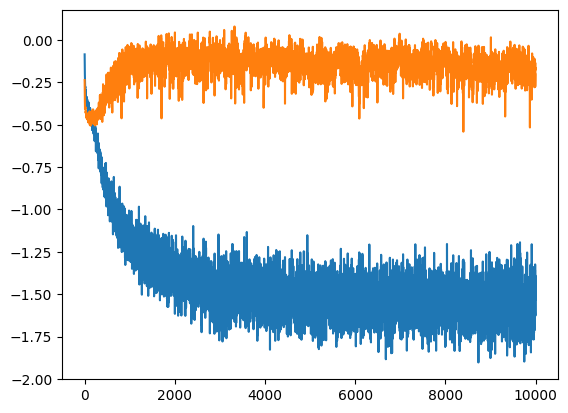

In [46]:
plt.plot(lossi_train)
plt.plot(lossi_val)

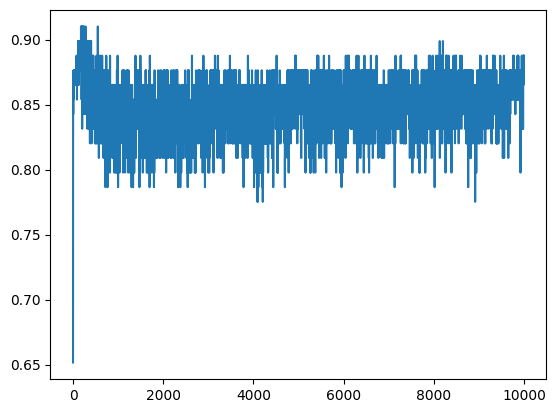

In [47]:
plt.plot(metric_val)

layer 2 (LeakyReluLayer): mean +0.01, std 0.06


layer 6 (LeakyReluLayer): mean +0.02, std 0.08


layer 10 (LeakyReluLayer): mean +0.02, std 0.11


layer 14 (LeakyReluLayer): mean +0.04, std 0.13


layer 18 (LeakyReluLayer): mean +0.08, std 0.12


layer 22 (LeakyReluLayer): mean +0.10, std 0.14


layer 26 (LeakyReluLayer): mean +0.07, std 0.15


layer 30 (LeakyReluLayer): mean +0.51, std 0.68


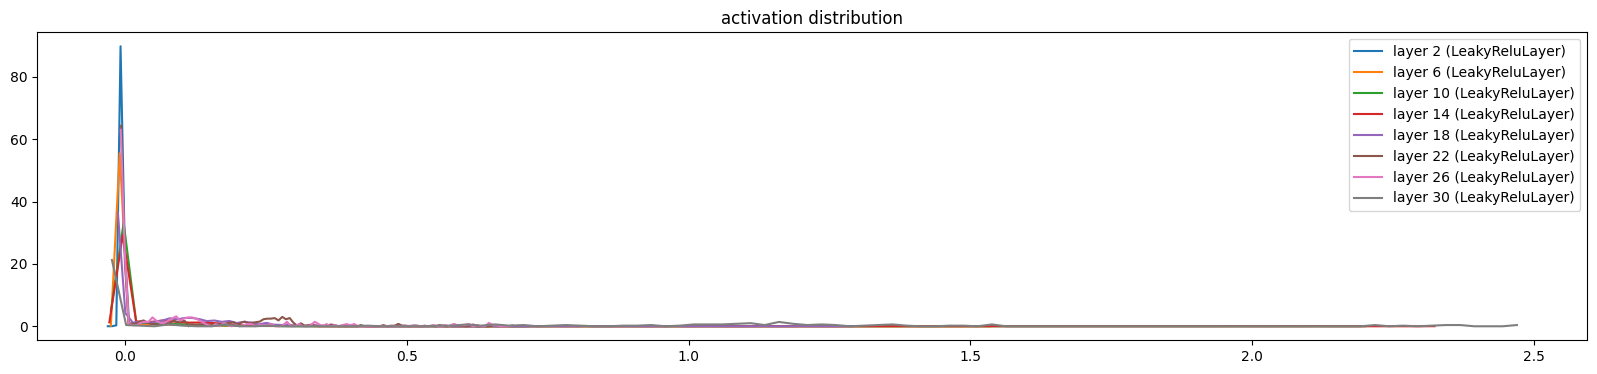

In [48]:
# visualize activations
plt.figure(figsize=(20, 4))
legends = []

if (len(model.layers) > 1):
    for i, layer in enumerate(model.layers): # exclude output layer
        layer_name = layer.__class__.__name__
        for activation_layer in activation_layers:
            if (activation_layer in layer_name):
                t = layer.output.cpu()
                print('layer %d (%10s): mean %+.2f, std %.2f' % (i, layer.__class__.__name__, t.mean(), t.std()))
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach())
                legends.append(f'layer {i} ({layer.__class__.__name__})')
    
    plt.legend(legends)
    plt.title("activation distribution")

layer (LeakyReluLayer: 2): mean +0.000117, std 2.595402e-02


layer (LeakyReluLayer: 6): mean +0.000049, std 3.207292e-02


layer (LeakyReluLayer: 10): mean +0.000047, std 3.384731e-02


layer (LeakyReluLayer: 14): mean -0.000626, std 1.861547e-02


layer (LeakyReluLayer: 18): mean +0.000213, std 1.300480e-02


layer (LeakyReluLayer: 22): mean +0.000565, std 1.765139e-02


layer (LeakyReluLayer: 26): mean -0.000099, std 5.239971e-02


layer (LeakyReluLayer: 30): mean +0.001503, std 9.758919e-03


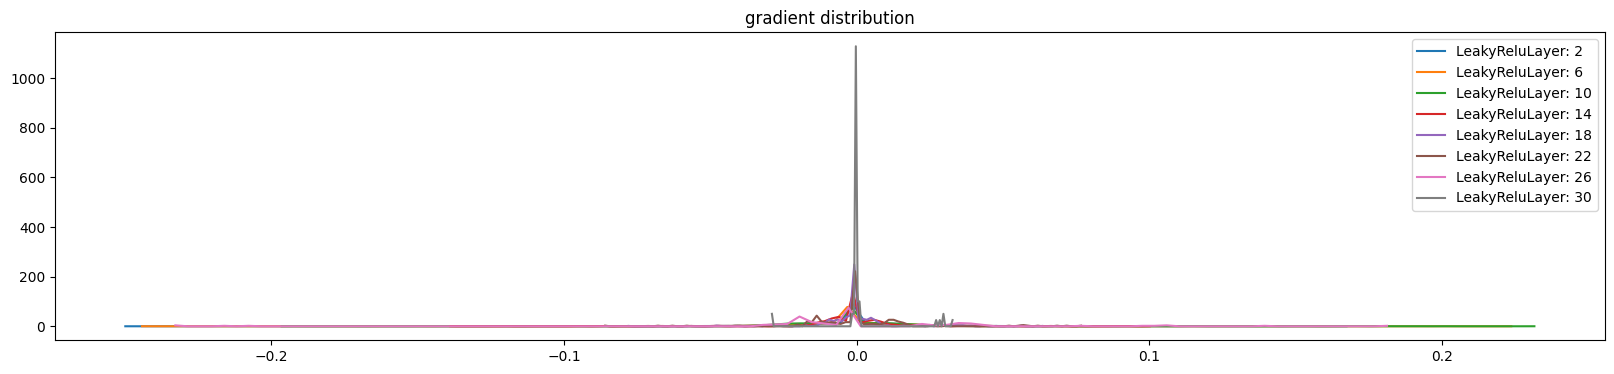

In [49]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

if (len(model.layers) > 1):
    for layer_name, layer_grad in output_grads[-1].items(): # note: exclude the output
        for activation_layer in activation_layers:
            if (activation_layer in layer_name):
                t = layer_grad.cpu()
                print('layer (%10s): mean %+f, std %e' % (layer_name, t.mean(), t.std()))
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach())
                legends.append(f'{layer_name}')
    
        plt.legend(legends);
        plt.title('gradient distribution')

weight (1024, 17) | mean -0.000028 | std 1.078100e-02 | grad:data ratio 2.537554e-02


weight (512, 1024) | mean -0.000002 | std 6.813200e-04 | grad:data ratio 3.327000e-03


weight (256, 512) | mean +0.000002 | std 1.381684e-03 | grad:data ratio 6.494320e-03


weight (128, 256) | mean -0.000035 | std 1.005106e-03 | grad:data ratio 4.176362e-03


weight  (64, 128) | mean -0.000062 | std 6.179799e-04 | grad:data ratio 2.376915e-03


weight   (32, 64) | mean -0.000064 | std 9.051775e-04 | grad:data ratio 3.350740e-03


weight   (16, 32) | mean -0.000619 | std 2.972179e-03 | grad:data ratio 1.167430e-02


weight    (8, 16) | mean +0.002473 | std 9.558672e-03 | grad:data ratio 3.891179e-02


weight     (1, 8) | mean +0.003514 | std 3.199615e-03 | grad:data ratio 1.824709e-03


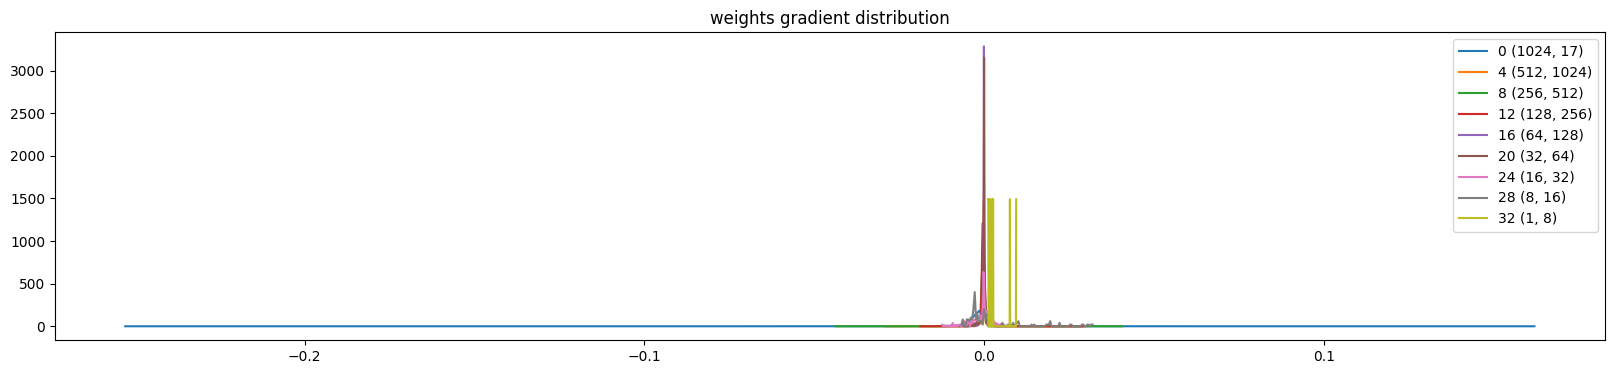

In [50]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2: # limit to weights only
    t = p.grad.cpu()
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

# gradient to data ratio should be less

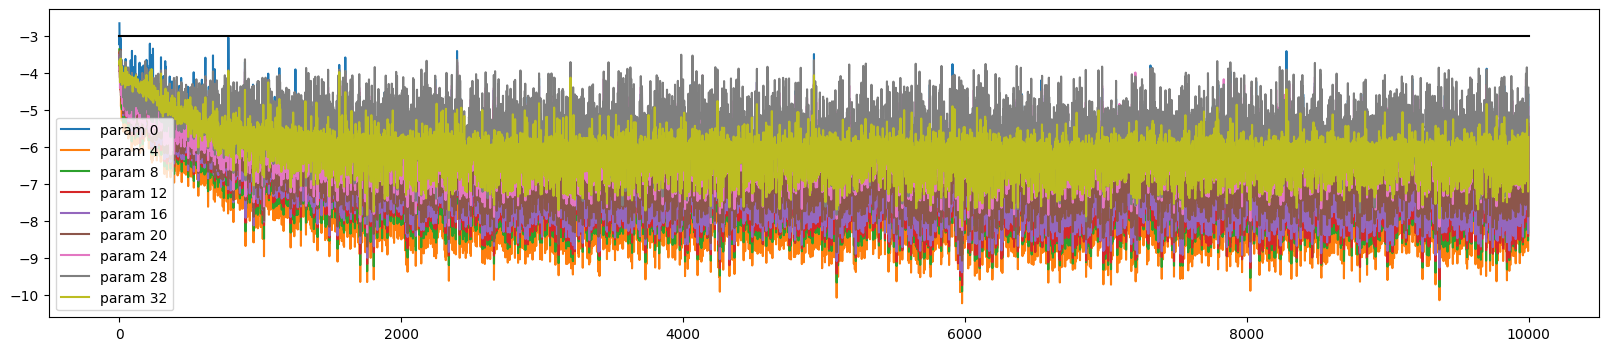

In [51]:
# plot update to data ratio
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
# less than 1e-3 means learning to slow
plt.legend(legends);

In [52]:
model.eval()  # Set model to evaluation mode

# Accuracy calculation
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
        predicted_classes = (predictions > 0.5).float()  # Convert to binary (0 or 1)
        correct += (predicted_classes == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 82.22%


In [53]:
model.eval()  # Set model to evaluation mode

# Accuracy calculation
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
        predicted_classes = (predictions > 0.5).float()  # Convert to binary (0 or 1)
        correct += (predicted_classes == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Train Accuracy: {accuracy * 100:.2f}%")

Train Accuracy: 84.55%


## Test

In [54]:
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_df.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [55]:
len(test_df)

418

In [56]:
csv_file = "/kaggle/input/titanic/test.csv"
target_col_list = ["Survived"]

transforms = torchvision.transforms.Compose([NormalizeCol(normalize_cols),
                                             ConvertNumpyArrToFloat32Tensor()])

entire_data_transform = torchvision.transforms.Compose([FillNa(fill_na), PreprocessCols(preprocess_col), one_hot_encode_transform])

final_test_dataset = CSVDataset(csv_file, features_col_list, target_col_list, transform=transforms, entire_data_transform=entire_data_transform, isTest=True)
final_test_dataset[0]

/tmp/ipykernel_74/2348786235.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[col].fillna(na_fill, inplace=True)


(tensor([0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.2300, 0.0000, 0.0000, 0.0130]),
 tensor([1.]))

In [57]:
len(final_test_dataset)

418

In [58]:
final_test_loader = DataLoader(final_test_dataset, shuffle=False)

pred = []
with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in final_test_loader:
        inputs = inputs.to(device)
    
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
        predicted_classes = (predictions > 0.5).float()  # Convert to binary (0 or 1)

        pred.append(int(predicted_classes.item()))

In [59]:
len(final_test_loader)

418

In [60]:
pred_df = pd.DataFrame(pred, columns=["Survived"])
pred_df["PassengerId"] = test_df["PassengerId"]
pred_df.to_csv("pred.csv", index=False)

In [61]:
pred_df.head()

,Survived,PassengerId
0,0,892
1,0,893
2,0,894
3,0,895
4,0,896
